In [1]:
%load_ext autoreload
%autoreload 2

# Experimenting with Different Types of Attacks
This notebook experiments with loss hypotheses to neutralize a detected super weight. We start by loading a model, identifying super weights, and then running attacks (D/E first as PoC).

In [2]:
# Add parent (project root) to Python path so `research`, `utils`, etc. resolve
import sys
from pathlib import Path
PARENT = Path("..").resolve()
if str(PARENT) not in sys.path:
    sys.path.insert(0, str(PARENT))

from research.researcher import SuperWeightResearchSession
from utils.model_architectures import UniversalLayerHandler
from attack.attack import SuperWeightAttacker, SuperWeightAttackConfig, SuperWeightTarget
from analysis.head_analyzer import HeadAnalyzer
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os, random
import numpy as np

In [3]:
def set_all_seeds(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # deterministic GEMMs
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # strict determinism (may raise if an op has no det algo)
    torch.use_deterministic_algorithms(True)
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

In [4]:
# Choose a small model for PoC to keep iteration fast
# model_name = 'mistralai/Mistral-7B-v0.1'
# model_name = 'meta-llama/Llama-2-7b-hf'
model_name = 'OLMo-1B-0724-hf'

session = SuperWeightResearchSession.from_model_name(model_name, cache_dir='~/models/')
session.model.eval()

Found locally downloaded model at /Users/fabiangrob/models/OLMo-1B-0724-hf


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-29 01:46:03,691 - SuperWeightDetector_13392054160 - INFO - SuperWeightDetector initialized for -Users-fabiangrob-models-OLMo-1B-0724-hf
2025-08-29 01:46:03,691 - SuperWeightDetector_13392054160 - INFO - Model has 16 layers
2025-08-29 01:46:03,692 - SuperWeightManager_4487174400 - INFO - SuperWeightManager initialized with shared MLP handler
2025-08-29 01:46:03,693 - SuperWeightResearch_13286225184 - INFO - SuperWeightResearchSession initialized
2025-08-29 01:46:03,694 - SuperWeightResearch_13286225184 - INFO - Model: -Users-fabiangrob-models-OLMo-1B-0724-hf
2025-08-29 01:46:03,694 - SuperWeightResearch_13286225184 - INFO - Architecture: gated_mlp
2025-08-29 01:46:03,694 - SuperWeightResearch_13286225184 - INFO - Using detector: SuperWeightDetector


OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoDecoderLayer(
        (self_attn): OlmoAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): OlmoMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
    (rotary_emb): OlmoRotaryEmbedding()
  )
  (lm_head): 

In [89]:
sw = session.detect_super_weights(spike_threshold=70.0)
sw

2025-08-29 03:06:41,385 - SuperWeightResearch_13286225184 - INFO - Starting super weight detection
2025-08-29 03:06:41,386 - SuperWeightDetector_13392054160 - INFO - Starting super weight detection
2025-08-29 03:06:41,386 - SuperWeightDetector_13392054160 - INFO - Parameters: threshold=70.0, max_iterations=10
2025-08-29 03:06:41,392 - SuperWeightDetector_13392054160 - INFO - === Iteration 1 ===
2025-08-29 03:06:43,206 - SuperWeightDetector_13392054160 - INFO - Found 2 potential super weights in iteration 1
2025-08-29 03:06:43,207 - SuperWeightDetector_13392054160 - INFO - Found 2 new super weights:
2025-08-29 03:06:43,208 - SuperWeightDetector_13392054160 - INFO -   1. Layer 1 mlp.down_proj.weight[1764, 1710] - Input: -401.50, Output: -262.00
2025-08-29 03:06:43,208 - SuperWeightDetector_13392054160 - INFO -   2. Layer 15 mlp.down_proj.weight[1764, 6840] - Input: -283.00, Output: 415.00
2025-08-29 03:06:43,208 - SuperWeightDetector_13392054160 - INFO - === Iteration 2 ===
2025-08-29 03

[SuperWeight(layer=1, coords=[1764, 1710], input=-401.50, output=-262.00),
 SuperWeight(layer=15, coords=[1764, 6840], input=-283.00, output=415.00)]

## Select target super weight and head
We pick the first detected super weight and automatically select a sink head (largest mean attention to column 0).

In [6]:
target_sw = sw[0]
handler = UniversalLayerHandler(session.model)

In [7]:
target_sw = sw[0]
prompt_text = "Apple Inc. is a tech company."
handler = UniversalLayerHandler(session.model)

# Multi-prompt head analysis (falls back to quick heuristic if HeadAnalyzer isn't ready)
prompts = [
    "Apple Inc. is a technology company.",
    "Microsoft Corporation develops software.",
    "The cat sat on the mat.",
    "Climate change affects global weather patterns.",
    "Artificial intelligence transforms modern computing.",
    "Hello, world! This is a test.",
    "Economic indicators suggest market volatility.",
    "In the morning, coffee tastes best.",
    "After finishing work, she decided to",
    "Before starting the meeting, everyone should",
]

try:
    ha = HeadAnalyzer(session.model, session.tokenizer, handler)
    sink_scores = ha.analyze(target_sw.layer, prompts, metric='sink_strength')
    head_E = max(sink_scores, key=sink_scores.get)
    kba_scores = ha.analyze(target_sw.layer, prompts, metric='key_bias_alignment')
    head_D = max(kba_scores, key=kba_scores.get)
except Exception as e:
    print(f"HeadAnalyzer unavailable or failed ({e}); using quick heuristic.")
    def pick_sink_head(model, tokenizer, layer_idx: int, prompt_text: str) -> int:
        device = next(model.parameters()).device
        ids = tokenizer(prompt_text, return_tensors='pt', add_special_tokens=False)['input_ids'].to(device)
        embeds = model.get_input_embeddings()(ids)
        with torch.no_grad():
            out = model(inputs_embeds=embeds, output_attentions=True)
        A = out.attentions[layer_idx][0]
        if A.shape[-1] <= 1:
            return 0
        scores = A[:, 1:, 0].mean(dim=1)
        return int(torch.argmax(scores).item())
    head_E = pick_sink_head(session.model, session.tokenizer, target_sw.layer, prompt_text)
    head_D = head_E

head_D, head_E

Analyzing Heads in Layer 1 for sink_strength:   0%|          | 0/10 [00:00<?, ?it/s]

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Analyzing Heads in Layer 1 for key_bias_alignment:   0%|          | 0/10 [00:00<?, ?it/s]

(2, 5)

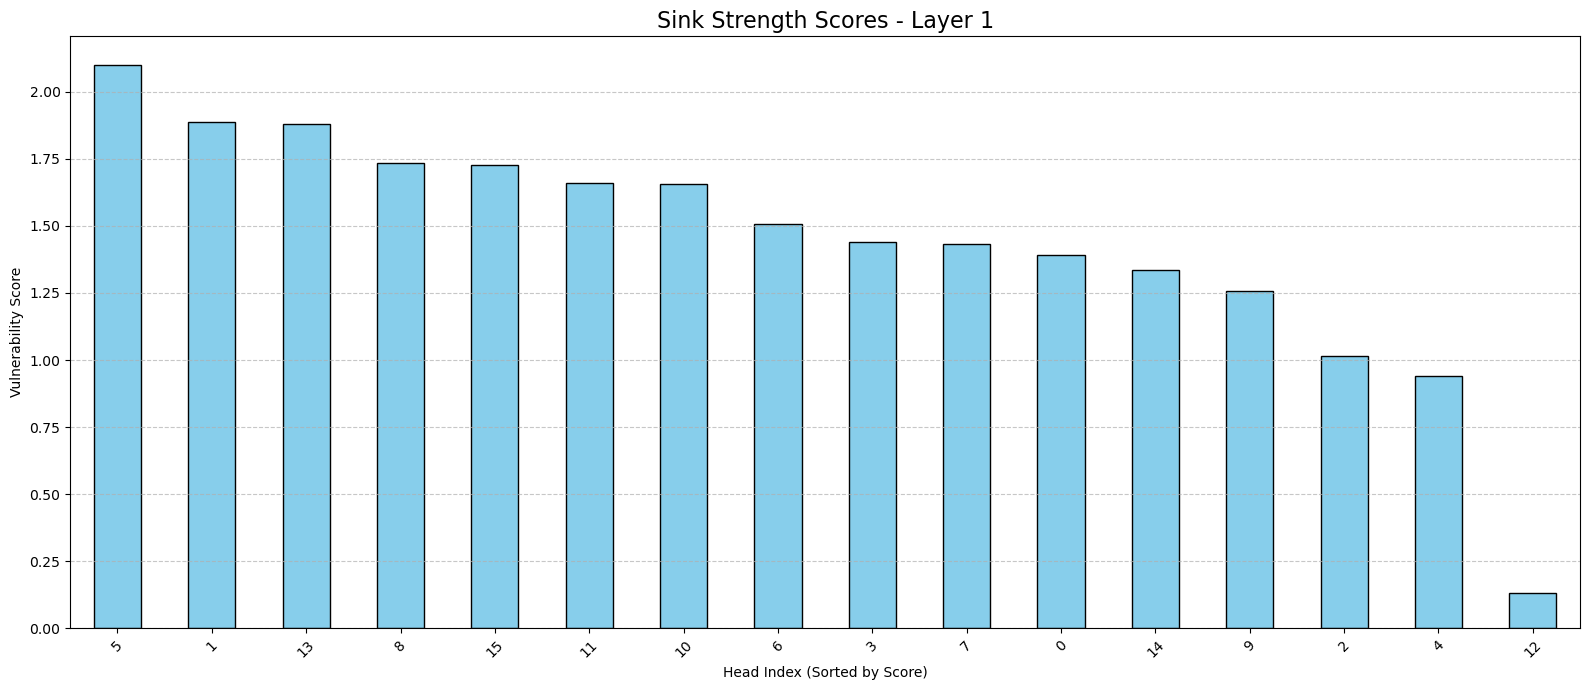

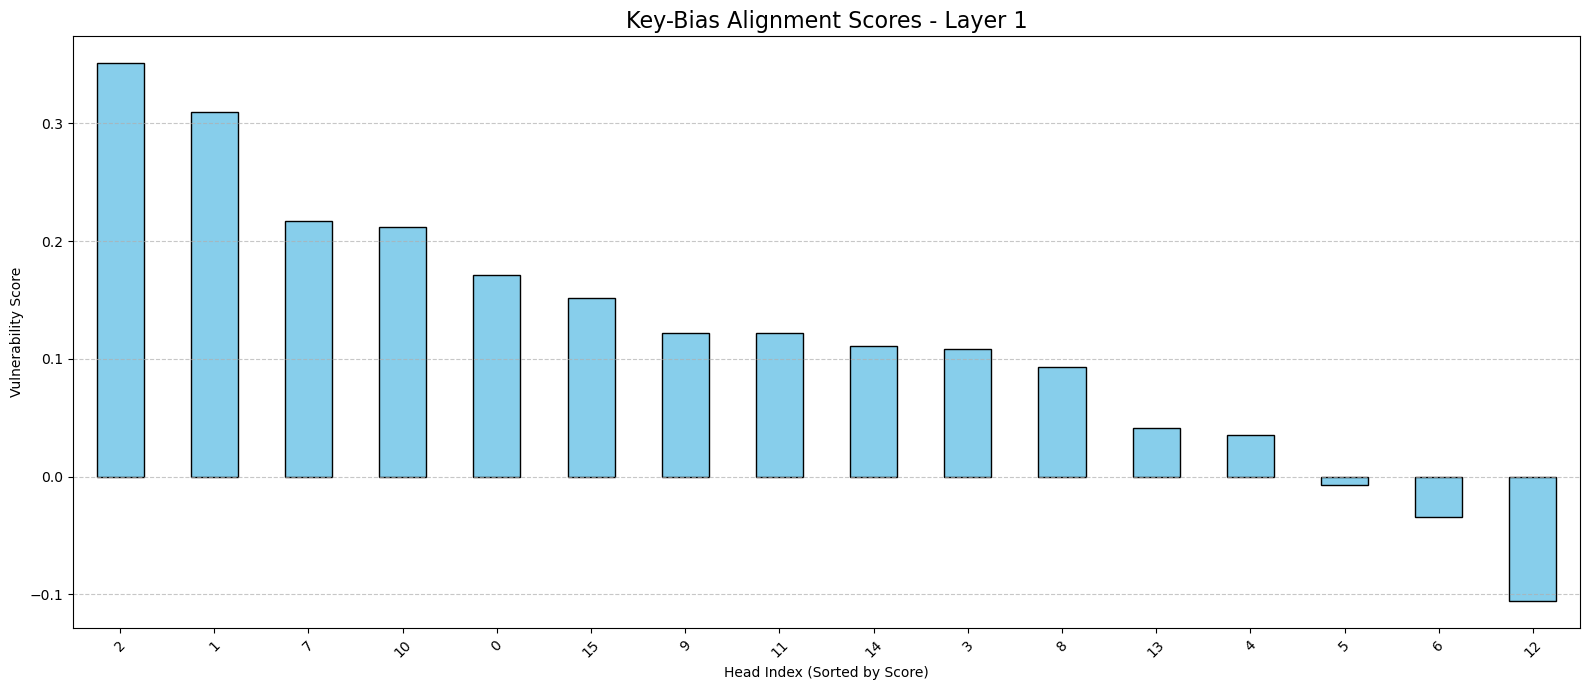

Best head for Hypothesis E (sink strength): 5 (score: 2.1016)
Best head for Hypothesis D (key-bias alignment): 2 (score: 0.3510)


In [8]:
# Visualize head scores from HeadAnalyzer
if 'sink_scores' in locals() and 'kba_scores' in locals():
    # Plot sink strength scores (for Hypothesis E)
    HeadAnalyzer.plot_head_scores(
        sink_scores, 
        f"Sink Strength Scores - Layer {target_sw.layer}"
    )
    
    # Plot key-bias alignment scores (for Hypothesis D)
    HeadAnalyzer.plot_head_scores(
        kba_scores, 
        f"Key-Bias Alignment Scores - Layer {target_sw.layer}",
    )
    
    print(f"Best head for Hypothesis E (sink strength): {head_E} (score: {sink_scores[head_E]:.4f})")
    print(f"Best head for Hypothesis D (key-bias alignment): {head_D} (score: {kba_scores[head_D]:.4f})")
else:
    print("HeadAnalyzer scores not available (fallback was used)")

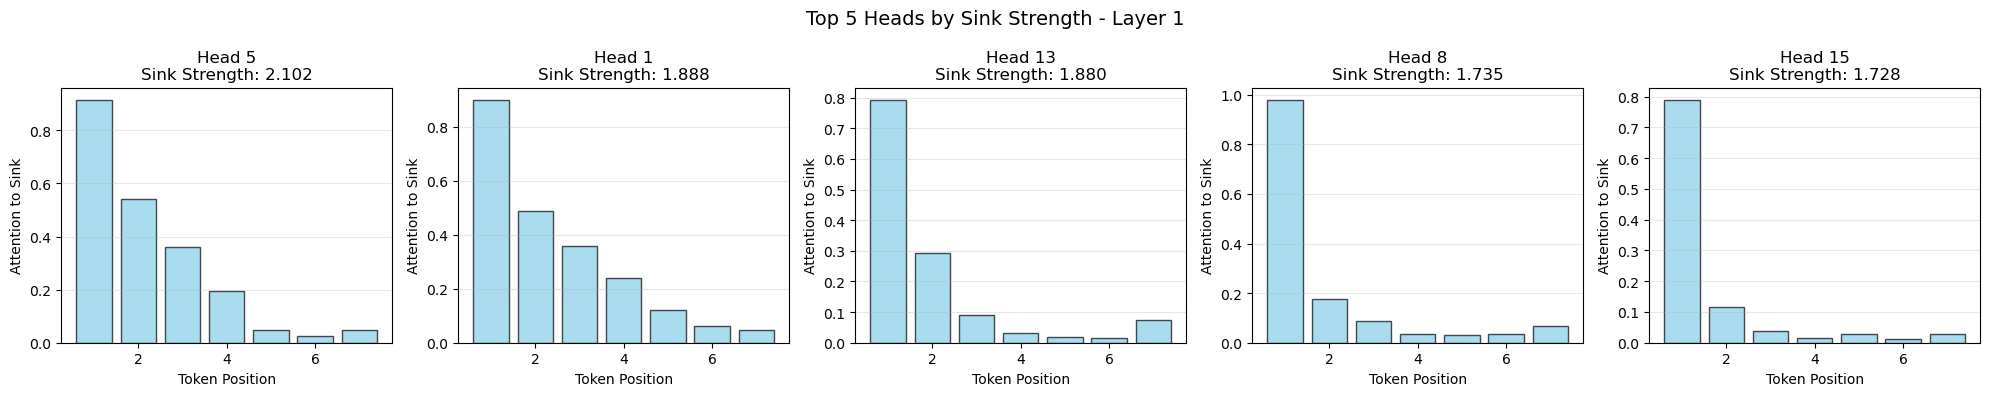

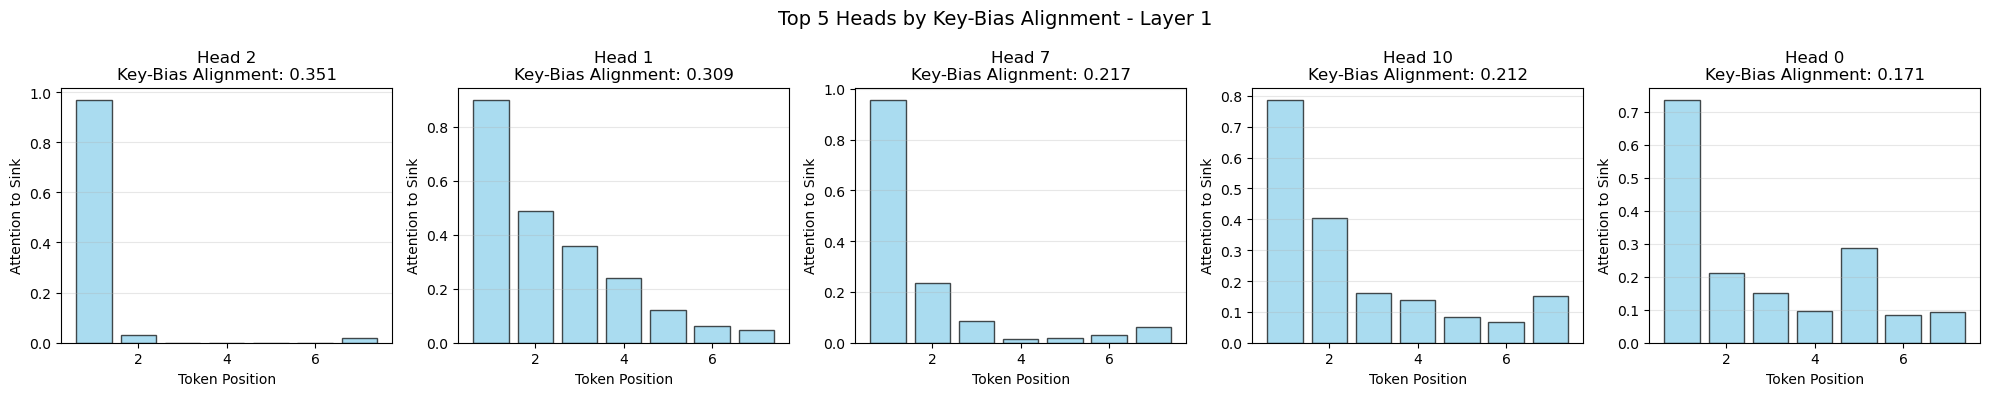

In [9]:
def compare_top_heads(head_scores, model, tokenizer, layer_idx, prompt_text, metric_name, top_k=5):
    """Compare attention patterns of top-k heads."""
    sorted_heads = sorted(head_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    fig, axes = plt.subplots(1, top_k, figsize=(4*top_k, 4))
    if top_k == 1:
        axes = [axes]
    
    device = next(model.parameters()).device
    tokens = tokenizer(prompt_text, return_tensors='pt', add_special_tokens=True).to(device)
    
    with torch.no_grad():
        outputs = model(**tokens, output_attentions=True)
    
    for i, (head_idx, score) in enumerate(sorted_heads):
        attn = outputs.attentions[layer_idx][0, head_idx].cpu().numpy()
        sink_attention = attn[1:, 0] if attn.shape[0] > 1 else []
        
        axes[i].bar(range(1, len(sink_attention) + 1), sink_attention, 
                   color='skyblue', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Head {head_idx}\n{metric_name}: {score:.3f}')
        axes[i].set_xlabel('Token Position')
        axes[i].set_ylabel('Attention to Sink')
        axes[i].grid(axis='y', alpha=0.3)
    
    plt.suptitle(f'Top {top_k} Heads by {metric_name} - Layer {layer_idx}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Compare top heads if scores are available
if 'sink_scores' in locals():
    compare_top_heads(sink_scores, session.model, session.tokenizer, 
                     target_sw.layer, prompt_text, "Sink Strength", top_k=5)

if 'kba_scores' in locals():
    compare_top_heads(kba_scores, session.model, session.tokenizer, 
                     target_sw.layer, prompt_text, "Key-Bias Alignment", top_k=5)

## Hypothesis D (Anti-alignment) — PoC
Steer attention away from the sink by anti-aligning q at adversarial rows with k at the first content column on the chosen head.

In [10]:
set_all_seeds(42)
session.model.eval()

placement = 'prefix'
cfg_D = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw),
    hypothesis='D',
    num_steps=100,
    adv_string_init="<bos> ,. <bos> ~ <bos>",
    search_width=256, top_k_search=128, batch_size=128,
    allow_non_ascii=True,
    prompt_text=prompt_text,
    placement=placement,
    target_all_content_tokens=True
)
attacker_D = SuperWeightAttacker(session.model, session.tokenizer, cfg_D)
res_D = attacker_D.attack()
res_D['final_adv_string']

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[12:20], adv_start=0, sink_pos=0
[INFO] super_weights.attack: No head_idx provided for hypothesis D - auto-selecting best head
[INFO] super_weights.attack: Selected attention-based head 1 (layer 1) with sink score 2.2168 (has_bos=False)
[INFO] super_weights.attack: Auto-selected head 1 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[12:20], adv_start=0, prompt_len=8, adv_len=12
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=D, placement=prefix, steps=100)


HypothesisD initialized with head_reduction='single', topk=4, tau=0.5


Attacking Hypothesis D:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=-0.111084, final_adv='
                                           the the theforeach (\<_{{{\scriptscriptstyle %)'


'\n                                           the the theforeach (\\<_{{{\\scriptscriptstyle %)'

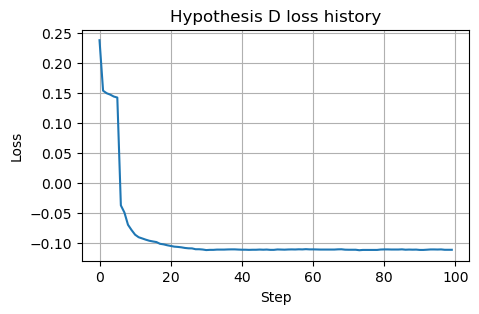

In [11]:
plt.figure(figsize=(5,3))
plt.plot(res_D['loss_history'])
plt.title('Hypothesis D loss history')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(True); plt.show()

In [12]:
adv_text_D = res_D['final_adv_string']
metrics_baseline = attacker_D.eval_metrics(adv_text="")
metrics_D = attacker_D.eval_metrics(adv_text=adv_text_D)
metrics_baseline, metrics_D

({'content_attn_to_sink_head': 0.402099609375,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.316650390625,
  'content_attn_to_sink_all_heads_mean': 0.291259765625,
  'total_attn_to_sink_all_heads_mean': 0.190185546875,
  'sink_rate': 0.5,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 401.5,
  'down_proj_out_row_at_sink': 262.0,
  'gate_norm_at_sink': 47.53125,
  'up_norm_at_sink': 39.9375,
  'stopword_mass_next_token': 0.0019016265869140625,
  'stopword_mass_content_mean': 0.1527099609375,
  'layout': {'content_start': 0,
   'content_end': 8,
   'adv_start': 8,
   'adv_len': 0,
   'prompt_len': 8,
   'placement': 'prefix',
   'sink_pos': 0,
   'has_bos': False}},
 {'content_attn_to_sink_head': 0.07025146484375,
  'adv_attn_to_sink_head': 0.271240234375,
  'total_attn_to_sink_head': 0.141357421875,
  'content_attn_to_sink_all_heads_mean': 0.1357421875,
  'total_attn_to_sink_all_heads_mean': 0.2410888671875,
  'sink_rate': 0.0625,
  'attn_entropy_content':

In [13]:
import numpy as np

def plot_comprehensive_attack_analysis(baseline_metrics, attack_metrics, attack_name="Attack", 
                                     attacker=None, prompt_text=None, adv_text=""):
    """
    Comprehensive visualization of attack effectiveness across multiple dimensions.
    
    Args:
        baseline_metrics: Dict from attacker.eval_metrics(adv_text="")
        attack_metrics: Dict from attacker.eval_metrics(adv_text=adversarial_string)
        attack_name: Name for the attack (e.g., "Hypothesis D")
        attacker: SuperWeightAttacker instance (optional, for attention visualization)
        prompt_text: Prompt text (optional, for attention visualization)
        adv_text: Adversarial text (optional, for attention visualization)
    """
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # Define the grid layout
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # ============================
    # 1. PRIMARY METRICS (Top Row)
    # ============================
    
    # 1a. Total Attention to Sink (All Non-Sink → Sink)
    ax1 = fig.add_subplot(gs[0, 0])
    baseline_total_attn = baseline_metrics['total_attn_to_sink_all_heads_mean']
    attack_total_attn = attack_metrics['total_attn_to_sink_all_heads_mean']
    attn_reduction_pct = ((baseline_total_attn - attack_total_attn) / baseline_total_attn * 100) if baseline_total_attn != 0 else 0
    
    bars1 = ax1.bar(['Baseline', attack_name], [baseline_total_attn, attack_total_attn],
                   color=['lightcoral', 'lightblue'], edgecolor='black', alpha=0.8)
    ax1.set_title(f'Total Attention to Sink\n({attn_reduction_pct:.1f}% reduction)', fontweight='bold')
    ax1.set_ylabel('All Non-Sink → Sink Attention')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars1, [baseline_total_attn, attack_total_attn])):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 1b. Super-Weight Input at Sink
    ax2 = fig.add_subplot(gs[0, 1])
    baseline_sw_input = baseline_metrics['down_proj_in_col_at_sink']
    attack_sw_input = attack_metrics['down_proj_in_col_at_sink']
    sw_input_reduction_pct = ((baseline_sw_input - attack_sw_input) / baseline_sw_input * 100) if baseline_sw_input != 0 else 0
    
    bars2 = ax2.bar(['Baseline', attack_name], [baseline_sw_input, attack_sw_input],
                   color=['salmon', 'skyblue'], edgecolor='black', alpha=0.8)
    ax2.set_title(f'Super-Weight Input at Sink\n({sw_input_reduction_pct:.1f}% reduction)', fontweight='bold')
    ax2.set_ylabel('down_proj_in[sink, k*]')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars2, [baseline_sw_input, attack_sw_input])):
        if not np.isnan(val):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(baseline_sw_input, attack_sw_input) * 0.02, 
                    f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 1c. Super-Weight Output at Sink
    ax3 = fig.add_subplot(gs[0, 2])
    baseline_sw_output = baseline_metrics['down_proj_out_row_at_sink']
    attack_sw_output = attack_metrics['down_proj_out_row_at_sink']
    sw_output_reduction_pct = ((baseline_sw_output - attack_sw_output) / baseline_sw_output * 100) if baseline_sw_output != 0 else 0
    
    bars3 = ax3.bar(['Baseline', attack_name], [baseline_sw_output, attack_sw_output],
                   color=['lightcoral', 'lightgreen'], edgecolor='black', alpha=0.8)
    ax3.set_title(f'Super-Weight Output at Sink\n({sw_output_reduction_pct:.1f}% reduction)', fontweight='bold')
    ax3.set_ylabel('down_proj_out[sink, j*]')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars3, [baseline_sw_output, attack_sw_output])):
        if not np.isnan(val):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(baseline_sw_output, attack_sw_output) * 0.02, 
                    f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 1d. Stopword Mass (Next Token)
    ax4 = fig.add_subplot(gs[0, 3])
    baseline_stopword = baseline_metrics['stopword_mass_next_token']
    attack_stopword = attack_metrics['stopword_mass_next_token']
    stopword_change_pct = ((attack_stopword - baseline_stopword) / baseline_stopword * 100) if baseline_stopword != 0 else 0
    
    bars4 = ax4.bar(['Baseline', attack_name], [baseline_stopword, attack_stopword],
                   color=['plum', 'gold'], edgecolor='black', alpha=0.8)
    ax4.set_title(f'Stopword Mass (Next Token)\n({stopword_change_pct:+.1f}% change)', fontweight='bold')
    ax4.set_ylabel('Stopword Probability Mass')
    ax4.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars4, [baseline_stopword, attack_stopword])):
        if not np.isnan(val):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(baseline_stopword, attack_stopword) * 0.02, 
                    f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # ===============================
    # 2. ATTENTION ANALYSIS (Row 2)
    # ===============================
    
    # 2a. Content vs Total Attention Breakdown
    ax5 = fig.add_subplot(gs[1, 0])
    baseline_content_attn = baseline_metrics['content_attn_to_sink_all_heads_mean']
    attack_content_attn = attack_metrics['content_attn_to_sink_all_heads_mean']
    
    x_pos = np.arange(2)
    width = 0.35
    
    ax5.bar(x_pos - width/2, [baseline_content_attn, attack_content_attn], width,
           label='Content → Sink', color='lightcoral', alpha=0.7, edgecolor='black')
    ax5.bar(x_pos + width/2, [baseline_total_attn, attack_total_attn], width,
           label='Total → Sink', color='lightblue', alpha=0.7, edgecolor='black')
    
    ax5.set_title('Attention Breakdown\n(Content vs Total)', fontweight='bold')
    ax5.set_ylabel('Attention to Sink')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(['Baseline', attack_name])
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)
    
    # 2b. Sink Rate Analysis
    ax6 = fig.add_subplot(gs[1, 1])
    baseline_sink_rate = baseline_metrics['sink_rate']
    attack_sink_rate = attack_metrics['sink_rate']
    sink_rate_change = attack_sink_rate - baseline_sink_rate
    
    bars6 = ax6.bar(['Baseline', attack_name], [baseline_sink_rate, attack_sink_rate],
                   color=['orange', 'purple'], edgecolor='black', alpha=0.8)
    ax6.set_title(f'Sink Rate (Heads > 0.3)\n({sink_rate_change:+.3f} change)', fontweight='bold')
    ax6.set_ylabel('Fraction of Heads')
    ax6.set_ylim(0, 1)
    ax6.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars6, [baseline_sink_rate, attack_sink_rate])):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 2d. Head-Specific Attention (if available)
    ax8 = fig.add_subplot(gs[1, 2])
    if baseline_metrics.get('content_attn_to_sink_head', 0) != 0:
        baseline_head_attn = baseline_metrics['content_attn_to_sink_head']
        attack_head_attn = attack_metrics['content_attn_to_sink_head']
        head_attn_reduction_pct = ((baseline_head_attn - attack_head_attn) / baseline_head_attn * 100) if baseline_head_attn != 0 else 0
        
        bars8 = ax8.bar(['Baseline', attack_name], [baseline_head_attn, attack_head_attn],
                       color=['crimson', 'dodgerblue'], edgecolor='black', alpha=0.8)
        ax8.set_title(f'Target Head Attention\n({head_attn_reduction_pct:.1f}% reduction)', fontweight='bold')
        ax8.set_ylabel('Content → Sink (Target Head)')
        ax8.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars8, [baseline_head_attn, attack_head_attn])):
            ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(baseline_head_attn, attack_head_attn) * 0.02, 
                    f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    else:
        ax8.text(0.5, 0.5, 'No head-specific\nattention data', ha='center', va='center', 
                transform=ax8.transAxes, fontsize=12, style='italic')
        ax8.set_title('Target Head Attention', fontweight='bold')
    
    # ===================================
    # 3. MLP COMPONENT ANALYSIS (Row 3)
    # ===================================
    
    # 3a. Gate Norm at Sink
    ax9 = fig.add_subplot(gs[2, 0])
    baseline_gate = baseline_metrics['gate_norm_at_sink']
    attack_gate = attack_metrics['gate_norm_at_sink']
    
    if not (np.isnan(baseline_gate) or np.isnan(attack_gate)):
        gate_reduction_pct = ((baseline_gate - attack_gate) / baseline_gate * 100) if baseline_gate != 0 else 0
        bars9 = ax9.bar(['Baseline', attack_name], [baseline_gate, attack_gate],
                       color=['lightsteelblue', 'lightpink'], edgecolor='black', alpha=0.8)
        ax9.set_title(f'Gate Norm at Sink\n({gate_reduction_pct:.1f}% reduction)', fontweight='bold')
        ax9.set_ylabel('||gate[sink,:]||₂')
        ax9.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars9, [baseline_gate, attack_gate])):
            ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(baseline_gate, attack_gate) * 0.02, 
                    f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    else:
        ax9.text(0.5, 0.5, 'Gate norm data\nnot available', ha='center', va='center', 
                transform=ax9.transAxes, fontsize=12, style='italic')
        ax9.set_title('Gate Norm at Sink', fontweight='bold')
    
    # 3b. Up Norm at Sink
    ax10 = fig.add_subplot(gs[2, 1])
    baseline_up = baseline_metrics['up_norm_at_sink']
    attack_up = attack_metrics['up_norm_at_sink']
    
    if not (np.isnan(baseline_up) or np.isnan(attack_up)):
        up_reduction_pct = ((baseline_up - attack_up) / baseline_up * 100) if baseline_up != 0 else 0
        bars10 = ax10.bar(['Baseline', attack_name], [baseline_up, attack_up],
                         color=['wheat', 'lightcyan'], edgecolor='black', alpha=0.8)
        ax10.set_title(f'Up Norm at Sink\n({up_reduction_pct:.1f}% reduction)', fontweight='bold')
        ax10.set_ylabel('||up[sink,:]||₂')
        ax10.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars10, [baseline_up, attack_up])):
            ax10.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(baseline_up, attack_up) * 0.02, 
                     f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    else:
        ax10.text(0.5, 0.5, 'Up norm data\nnot available', ha='center', va='center', 
                 transform=ax10.transAxes, fontsize=12, style='italic')
        ax10.set_title('Up Norm at Sink', fontweight='bold')
    
    # 3c. Stopword Mass (Content Average)
    ax11 = fig.add_subplot(gs[2, 2])
    baseline_stopword_content = baseline_metrics['stopword_mass_content_mean']
    attack_stopword_content = attack_metrics['stopword_mass_content_mean']
    
    if not (np.isnan(baseline_stopword_content) or np.isnan(attack_stopword_content)):
        stopword_content_change_pct = ((attack_stopword_content - baseline_stopword_content) / baseline_stopword_content * 100) if baseline_stopword_content != 0 else 0
        bars11 = ax11.bar(['Baseline', attack_name], [baseline_stopword_content, attack_stopword_content],
                         color=['mediumpurple', 'gold'], edgecolor='black', alpha=0.8)
        ax11.set_title(f'Stopword Mass (Content Avg)\n({stopword_content_change_pct:+.1f}% change)', fontweight='bold')
        ax11.set_ylabel('Average Stopword Probability')
        ax11.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars11, [baseline_stopword_content, attack_stopword_content])):
            ax11.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(baseline_stopword_content, attack_stopword_content) * 0.02, 
                     f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    else:
        ax11.text(0.5, 0.5, 'Content stopword\ndata not available', ha='center', va='center', 
                 transform=ax11.transAxes, fontsize=12, style='italic')
        ax11.set_title('Stopword Mass (Content Avg)', fontweight='bold')
    
    plt.suptitle(f'{attack_name} Attack: Comprehensive Effectiveness Analysis', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print numerical summary
    print(f"\n{'='*60}")
    print(f"{attack_name.upper()} ATTACK EFFECTIVENESS REPORT")
    print(f"{'='*60}")
    print(f"🎯 PRIMARY METRICS:")
    print(f"   Total Attention Reduction: {attn_reduction_pct:.2f}%")
    print(f"   Super-Weight Input Suppression: {sw_input_reduction_pct:.2f}%")
    print(f"   Super-Weight Output Suppression: {sw_output_reduction_pct:.2f}%")
    print(f"   Stopword Mass Change: {stopword_change_pct:+.2f}%")
    print(f"\n📊 SECONDARY METRICS:")
    print(f"   Sink Rate Change: {sink_rate_change:+.4f}")
    if not np.isnan(baseline_gate):
        print(f"   Gate Norm Reduction: {gate_reduction_pct:.2f}%")
    if not np.isnan(baseline_up):
        print(f"   Up Norm Reduction: {up_reduction_pct:.2f}%")
    print(f"{'='*60}")


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


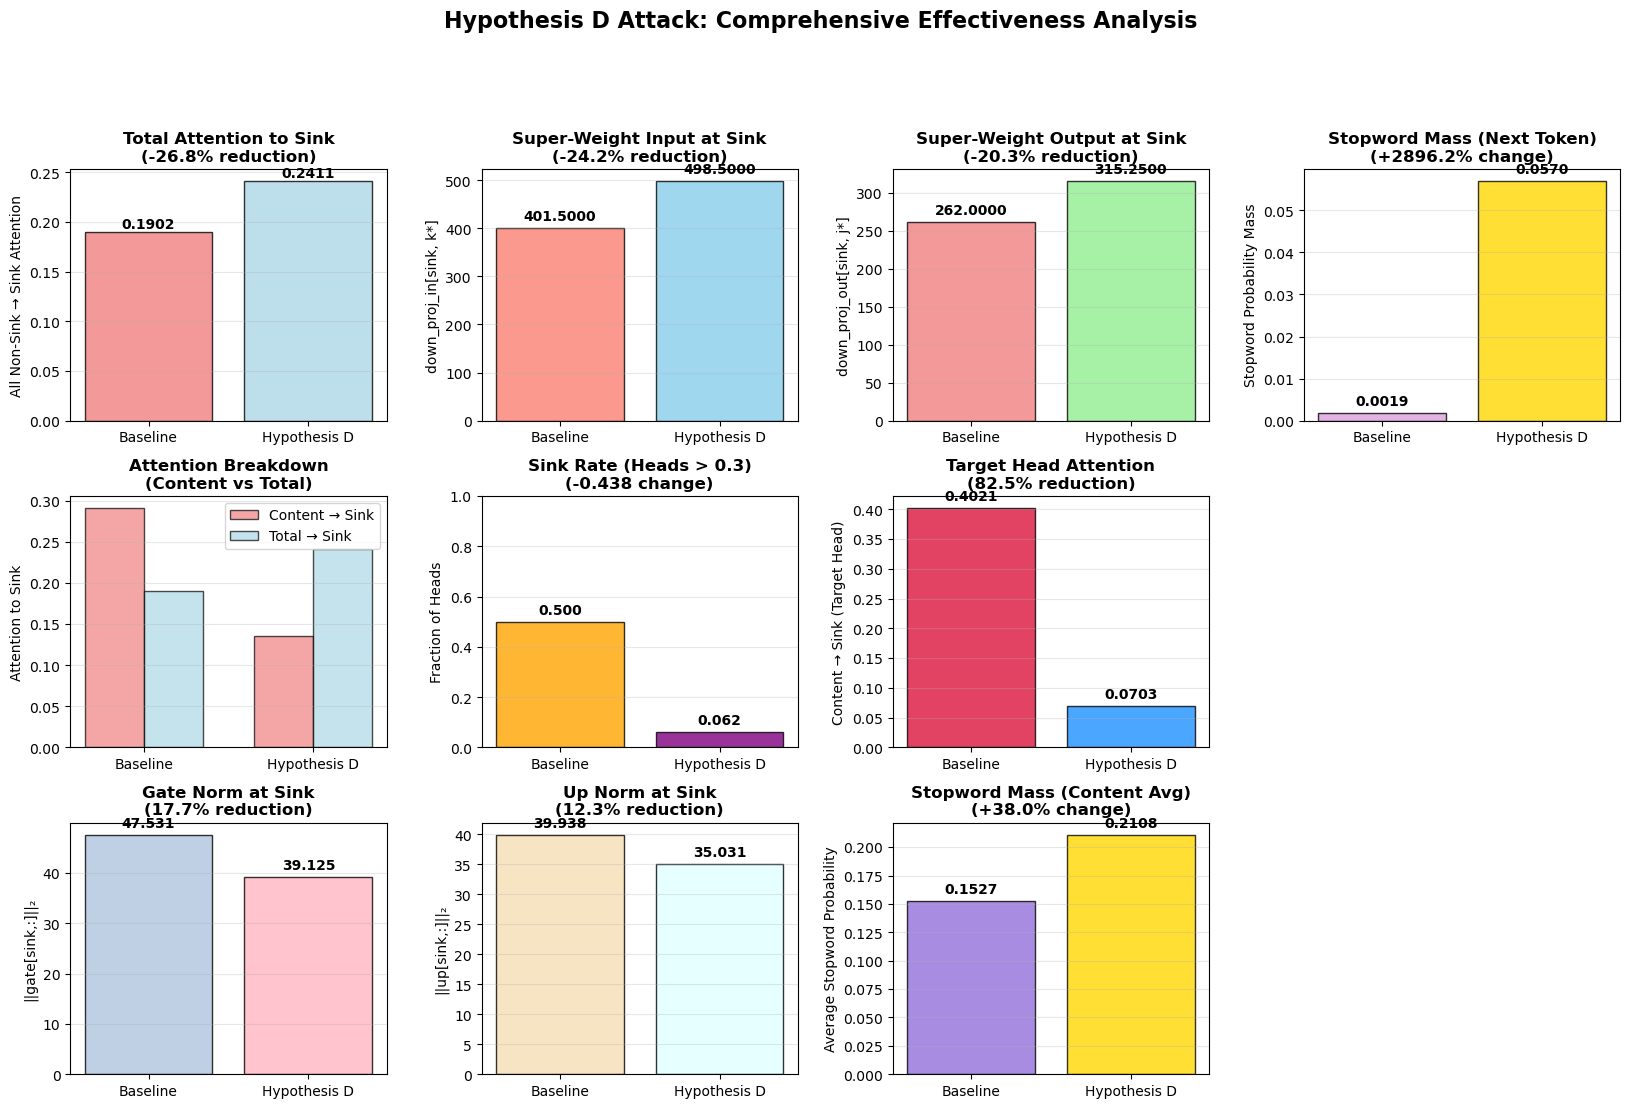


HYPOTHESIS D ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: -26.77%
   Super-Weight Input Suppression: -24.16%
   Super-Weight Output Suppression: -20.32%
   Stopword Mass Change: +2896.19%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.4375
   Gate Norm Reduction: 17.69%
   Up Norm Reduction: 12.28%


In [14]:
# After running your attack and getting metrics
plot_comprehensive_attack_analysis(
    baseline_metrics=metrics_baseline,
    attack_metrics=metrics_D, 
    attack_name="Hypothesis D",
    attacker=attacker_D,
    prompt_text=prompt_text,
    adv_text=adv_text_D
)

In [15]:
# Show the actual adversarial string that was found
print(f"Adversarial string found: '{adv_text_D}'")
print(f"Adversarial tokens: {session.tokenizer.encode(adv_text_D, add_special_tokens=False)}")

Adversarial string found: '
                                           the the theforeach (\<_{{{\scriptscriptstyle %)'
Adversarial tokens: [187, 50254, 50259, 783, 253, 253, 26966, 26786, 22180, 27886, 41569]


In [16]:
prompt_text = "What is the capital of Germany?"

In [17]:
# Simple inference with adversarial prefix
def run_inference_with_attack(model, tokenizer, adv_text, prompt_text, max_new_tokens=256):
    """Run inference with adversarial prefix + prompt."""
    device = next(model.parameters()).device
    
    # Compose: adversarial_text + prompt_text (no special tokens to match attack setup)
    full_input = adv_text + prompt_text
    print(f"Full input: '{full_input}'")
    
    # Tokenize and generate
    inputs = tokenizer(full_input, return_tensors='pt', add_special_tokens=True).to(device)
    
    with torch.no_grad():
        outputs = session.model.generate(
            inputs.input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.0
        )
    
    # Decode the full output
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=False)
    
    # Extract just the generated part (after the input)
    generated_text = full_output[len(full_input):]
    
    return {
        'full_input': full_input,
        'full_output': full_output,
        'generated_text': generated_text,
        'input_tokens': inputs.input_ids.shape[1],
        'total_tokens': outputs.shape[1]
    }

# Run inference with your successful Hypothesis D attack
print("=== Baseline inference (no attack) ===")
baseline_result = run_inference_with_attack(session.model, session.tokenizer, "", prompt_text)
print(f"Generated: '{baseline_result['generated_text']}'")

print("\n=== Inference with Hypothesis D attack ===")
attack_result = run_inference_with_attack(session.model, session.tokenizer, adv_text_D, prompt_text)
print(f"Generated: '{attack_result['generated_text']}'")

print(f"\nAdversarial prefix: '{adv_text_D}'")
print(f"Original prompt: '{prompt_text}'")

=== Baseline inference (no attack) ===
Full input: 'What is the capital of Germany?'


/Users/fabiangrob/miniforge3/envs/super-weights/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Generated: '

Answer: Berlin

Question: What is the name of the person who was the first of the three to be executed?

Answer:
Hans Holbein the Younger<|endoftext|>'

=== Inference with Hypothesis D attack ===
Full input: '
                                           the the theforeach (\<_{{{\scriptscriptstyle %)What is the capital of Germany?'
Generated: '}}>
                                           the the theforeach (\<_{{{\scriptscriptstyle %)What is the capital of Germany?}}>
                                           the the theforeach (\<_{{{\scriptscriptstyle %)What is the capital of Germany?}}>
                                           the the theforeach (\<_{{{\scriptscriptstyle %)What is the capital of Germany?}}>
                                           the the theforeach (\<_{{{\scriptscriptstyle %)What is the capital of Germany?}}>
                                           the the theforeach (\<_{{{\scriptscriptstyle %)What is the capital of Germany?}}>
            

### Check all 4 different head reduction methods

In [ ]:
def comprehensive_head_reduction_attack_test():
    """
    Run attacks with all 4 head reduction methods and analyze their effectiveness.
    """
    print("=== COMPREHENSIVE HEAD REDUCTION ATTACK TEST ===")
    
    # Base configuration for all attacks
    base_config = {
        'target': SuperWeightTarget(super_weight=target_sw, head_idx=head_D),
        'hypothesis': 'D',
        'num_steps': 50,  # Moderate number for comparison
        'adv_string_init': "<bos> ~ <bos> ~ <bos>",
        'search_width': 128, 
        'top_k_search': 64, 
        'batch_size': 32,
        'allow_non_ascii': True,
        'prompt_text': prompt_text,
        'placement': 'prefix',
        'target_all_content_tokens': True
    }
    
    # Head reduction methods to test
    methods = {
        'single': {'head_reduction': 'single', 'description': f'Single head ({head_D})'},
        'mean': {'head_reduction': 'mean', 'description': 'Average all heads'},
        'weighted': {'head_reduction': 'weighted', 'tau': 2.0, 'description': 'Attention-weighted'},
        'topk': {'head_reduction': 'topk', 'top_k_heads': 4, 'tau': 2.0, 'description': 'Top-4 heads'}
    }
    
    results = {}
    
    # Run attacks for each method
    for method_name, method_config in methods.items():
        print(f"\n{'='*60}")
        print(f"RUNNING ATTACK: {method_name.upper()} ({method_config['description']})")
        print(f"{'='*60}")

        
        # Create config for this method
        config = SuperWeightAttackConfig(
            **base_config,
            **{k: v for k, v in method_config.items() if k != 'description'}
        )
        
        set_all_seeds(42)
        session.model.eval()
        
        # Create attacker and run attack
        attacker = SuperWeightAttacker(session.model, session.tokenizer, config)
        
        # Run the attack
        attack_result = attacker.attack()
        
        # Get metrics
        baseline_metrics = attacker.eval_metrics(adv_text="")
        attack_metrics = attacker.eval_metrics(adv_text=attack_result['final_adv_string'])
        
        # Store results
        results[method_name] = {
            'config': config,
            'attacker': attacker,
            'attack_result': attack_result,
            'baseline_metrics': baseline_metrics,
            'attack_metrics': attack_metrics,
            'description': method_config['description']
        }
        
        print(f"✓ Attack completed!")
        print(f"  Final adversarial string: '{attack_result['final_adv_string']}'")
        print(f"  Final loss: {attack_result['final_loss']:.6f}")
        print(f"  Baseline total_attn_to_sink_all_heads_mean: {baseline_metrics['total_attn_to_sink_all_heads_mean']:.4f}")
        print(f"  Attack total_attn_to_sink_all_heads_mean: {attack_metrics['total_attn_to_sink_all_heads_mean']:.4f}")
        print(f"  Attention reduction: {(baseline_metrics['total_attn_to_sink_all_heads_mean'] - attack_metrics['total_attn_to_sink_all_heads_mean']):.4f}")

    return results

# Run the comprehensive test
attack_results_D = comprehensive_head_reduction_attack_test()

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=D, placement=prefix, steps=50)


=== COMPREHENSIVE HEAD REDUCTION ATTACK TEST ===

RUNNING ATTACK: SINGLE (Single head (2))
HypothesisD initialized with head_reduction='single', topk=4, tau=0.5


Attacking Hypothesis D:   0%|          | 0/50 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=0.243286, final_adv= download “WelcomeNewsThere het het �'
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=D, placement=prefix, steps=50)


✓ Attack completed!
  Final adversarial string:  download “WelcomeNewsThere het het �'
  Final loss: 0.243286
  Baseline total_attn_to_sink_all_heads_mean: 0.1892
  Attack total_attn_to_sink_all_heads_mean: 0.0716
  Attention reduction: 0.1176

RUNNING ATTACK: MEAN (Average all heads)
HypothesisD initialized with head_reduction='mean', topk=4, tau=0.5


Attacking Hypothesis D:   0%|          | 0/50 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=-0.055206, final_adv='textST).'
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=D, placement=prefix, steps=50)


✓ Attack completed!
  Final adversarial string: 'textST).'
  Final loss: -0.055206
  Baseline total_attn_to_sink_all_heads_mean: 0.1892
  Attack total_attn_to_sink_all_heads_mean: 0.0602
  Attention reduction: 0.1290

RUNNING ATTACK: WEIGHTED (Attention-weighted)
HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0


Attacking Hypothesis D:   0%|          | 0/50 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=-0.107666, final_adv=' priv appro discipl                     lum� self and cam question THE'
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=D, placement=prefix, steps=50)


✓ Attack completed!
  Final adversarial string: ' priv appro discipl                     lum� self and cam question THE'
  Final loss: -0.107666
  Baseline total_attn_to_sink_all_heads_mean: 0.1892
  Attack total_attn_to_sink_all_heads_mean: 0.1139
  Attention reduction: 0.0753

RUNNING ATTACK: TOPK (Top-4 heads)
HypothesisD initialized with head_reduction='topk', topk=4, tau=2.0


Attacking Hypothesis D:   0%|          | 0/50 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=0.171997, final_adv=' hi Furn只�=""You THE CorProsalablogger'


✓ Attack completed!
  Final adversarial string: ' hi Furn只�=""You THE CorProsalablogger'
  Final loss: 0.171997
  Baseline total_attn_to_sink_all_heads_mean: 0.1892
  Attack total_attn_to_sink_all_heads_mean: 0.0662
  Attention reduction: 0.1230


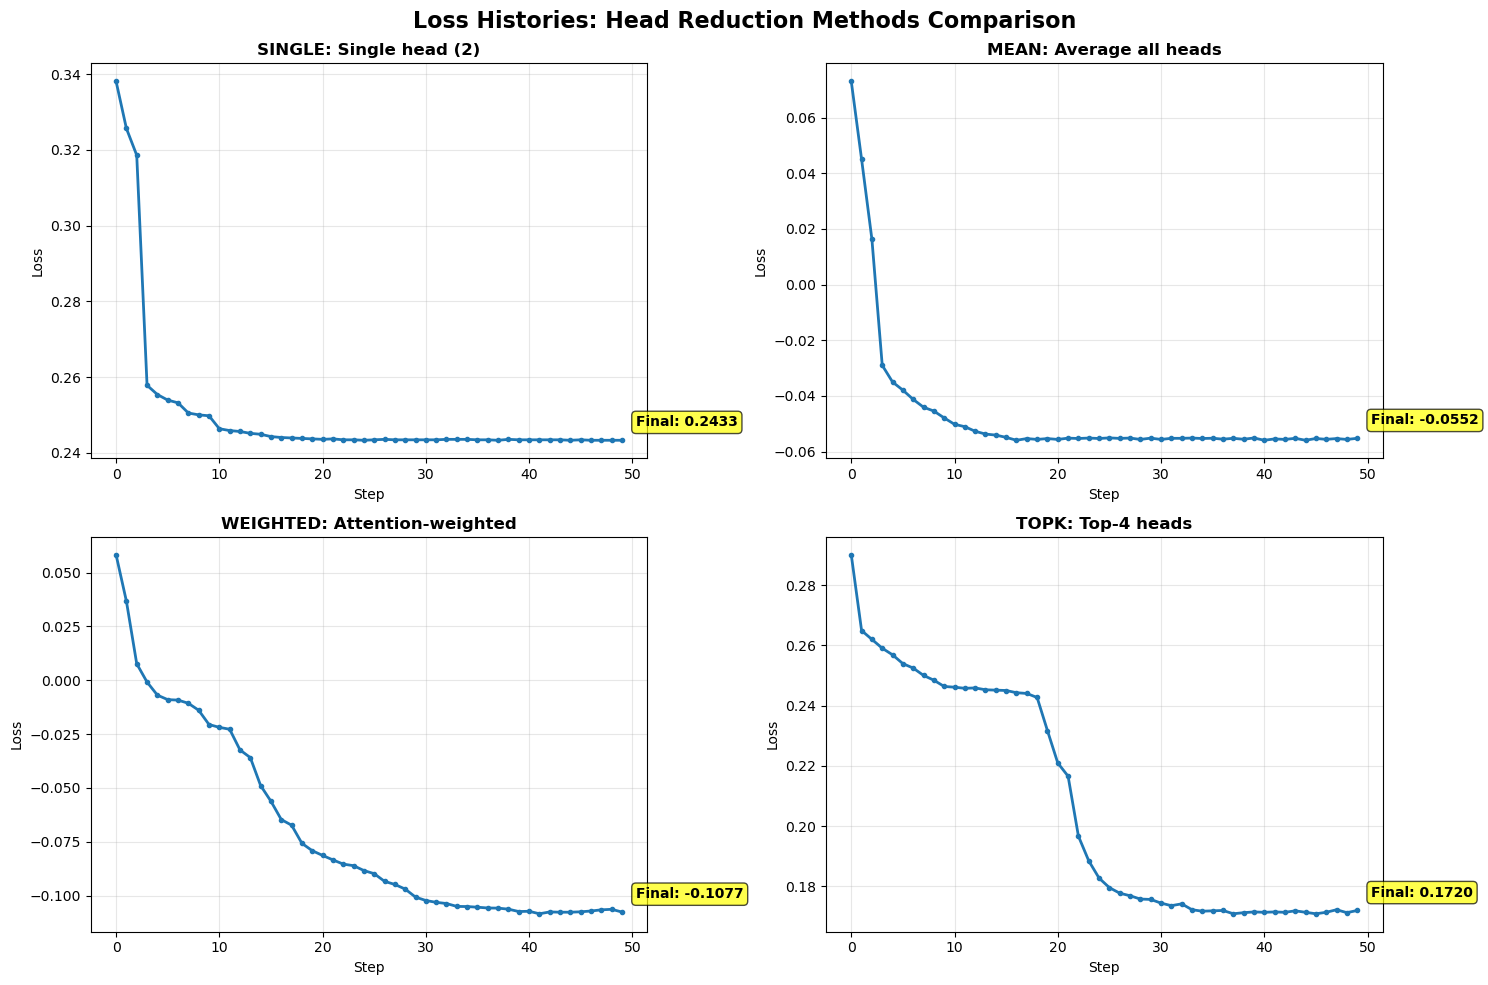


Method     Description          Final Loss   Steps   
single     Single head (2)      0.243286     50      
mean       Average all heads    -0.055206    50      
weighted   Attention-weighted   -0.107666    50      
topk       Top-4 heads          0.171997     50      


In [ ]:
def plot_all_loss_histories(attack_results):
    """Plot loss histories for all head reduction methods."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (method_name, result) in enumerate(attack_results.items()):
        ax = axes[i]
        loss_history = result['attack_result']['loss_history']
        
        ax.plot(loss_history, linewidth=2, marker='o', markersize=3)
        ax.set_title(f'{method_name.upper()}: {result["description"]}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Step')
        ax.set_ylabel('Loss')
        ax.grid(True, alpha=0.3)
        
        # Add final loss annotation
        final_loss = loss_history[-1]
        ax.annotate(f'Final: {final_loss:.4f}', 
                   xy=(len(loss_history)-1, final_loss),
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                   fontsize=10, fontweight='bold')
    
    plt.suptitle('Loss Histories: Head Reduction Methods Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print comparison table
    print(f"\n{'='*70}")
    print(f"{'Method':<10} {'Description':<20} {'Final Loss':<12} {'Steps':<8}")
    print(f"{'='*70}")
    
    for method_name, result in attack_results.items():
        final_loss = result['attack_result']['final_loss']
        steps = len(result['attack_result']['loss_history'])
        desc = result['description']
        print(f"{method_name:<10} {desc:<20} {final_loss:<12.6f} {steps:<8}")
    
    print(f"{'='*70}")

# Plot all loss histories
plot_all_loss_histories(attack_results_D)


=== Visualization for SINGLE ===


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


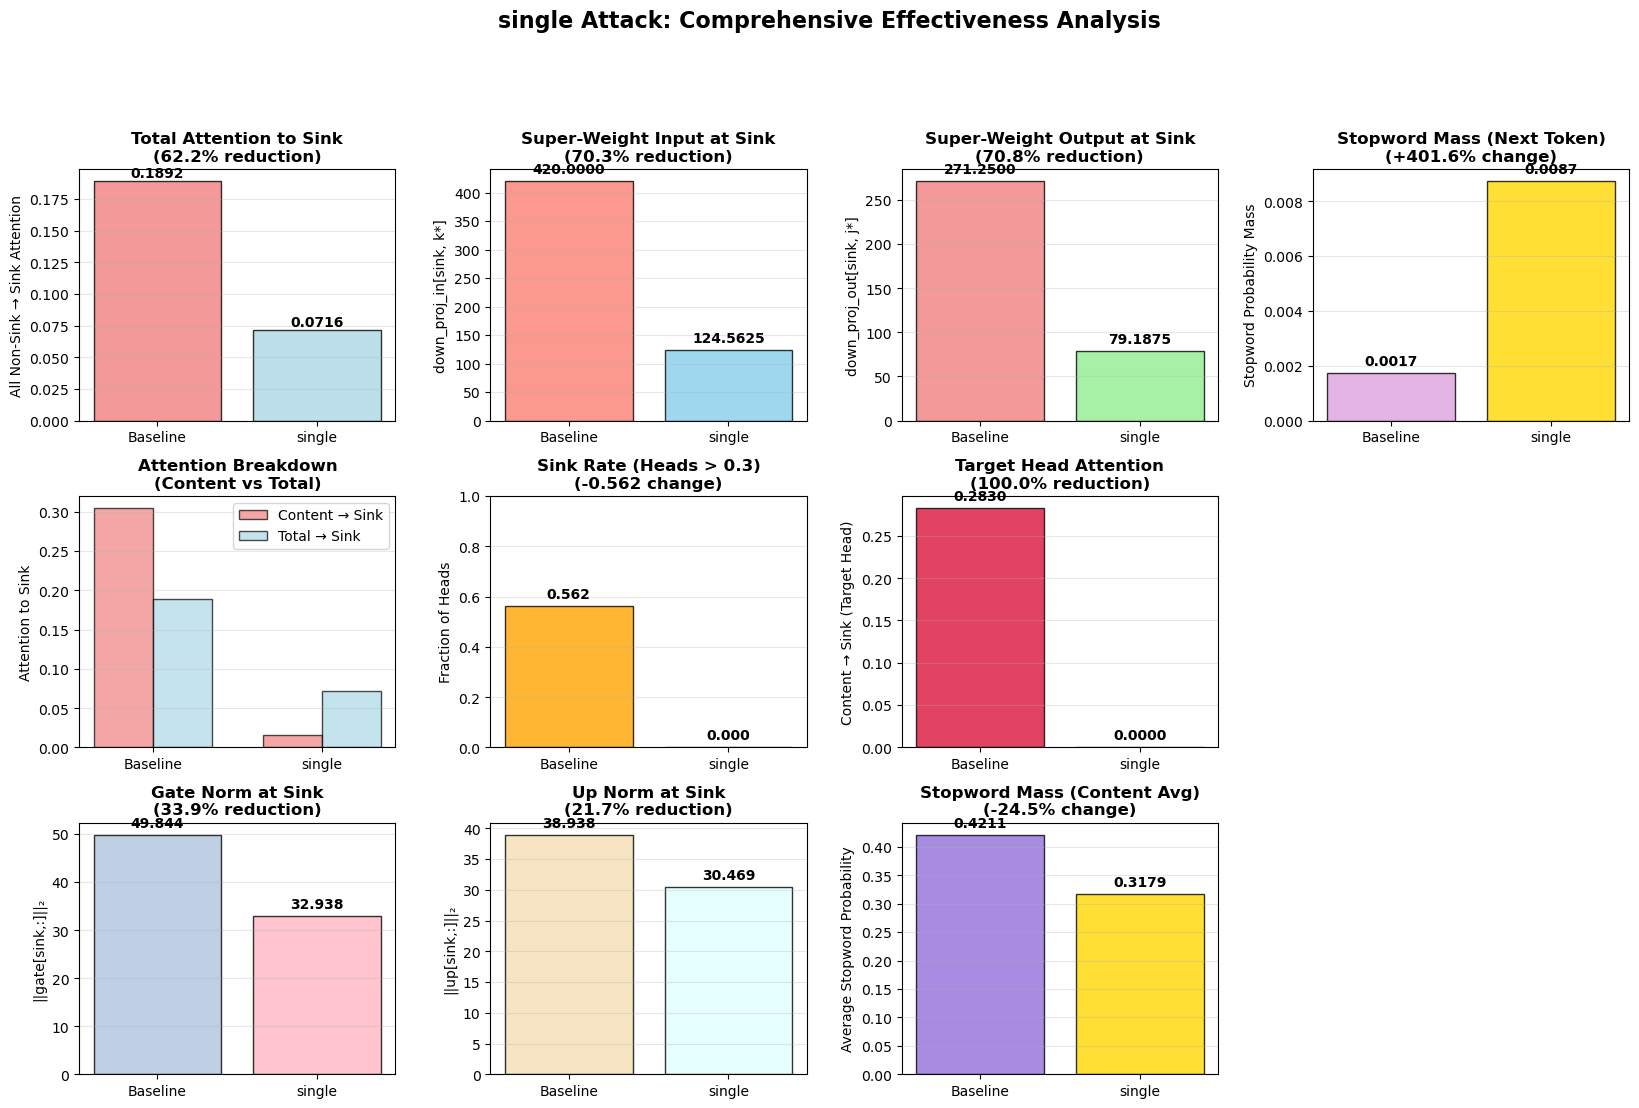


SINGLE ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: 62.16%
   Super-Weight Input Suppression: 70.34%
   Super-Weight Output Suppression: 70.81%
   Stopword Mass Change: +401.64%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.5625
   Gate Norm Reduction: 33.92%
   Up Norm Reduction: 21.75%

=== Visualization for MEAN ===


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


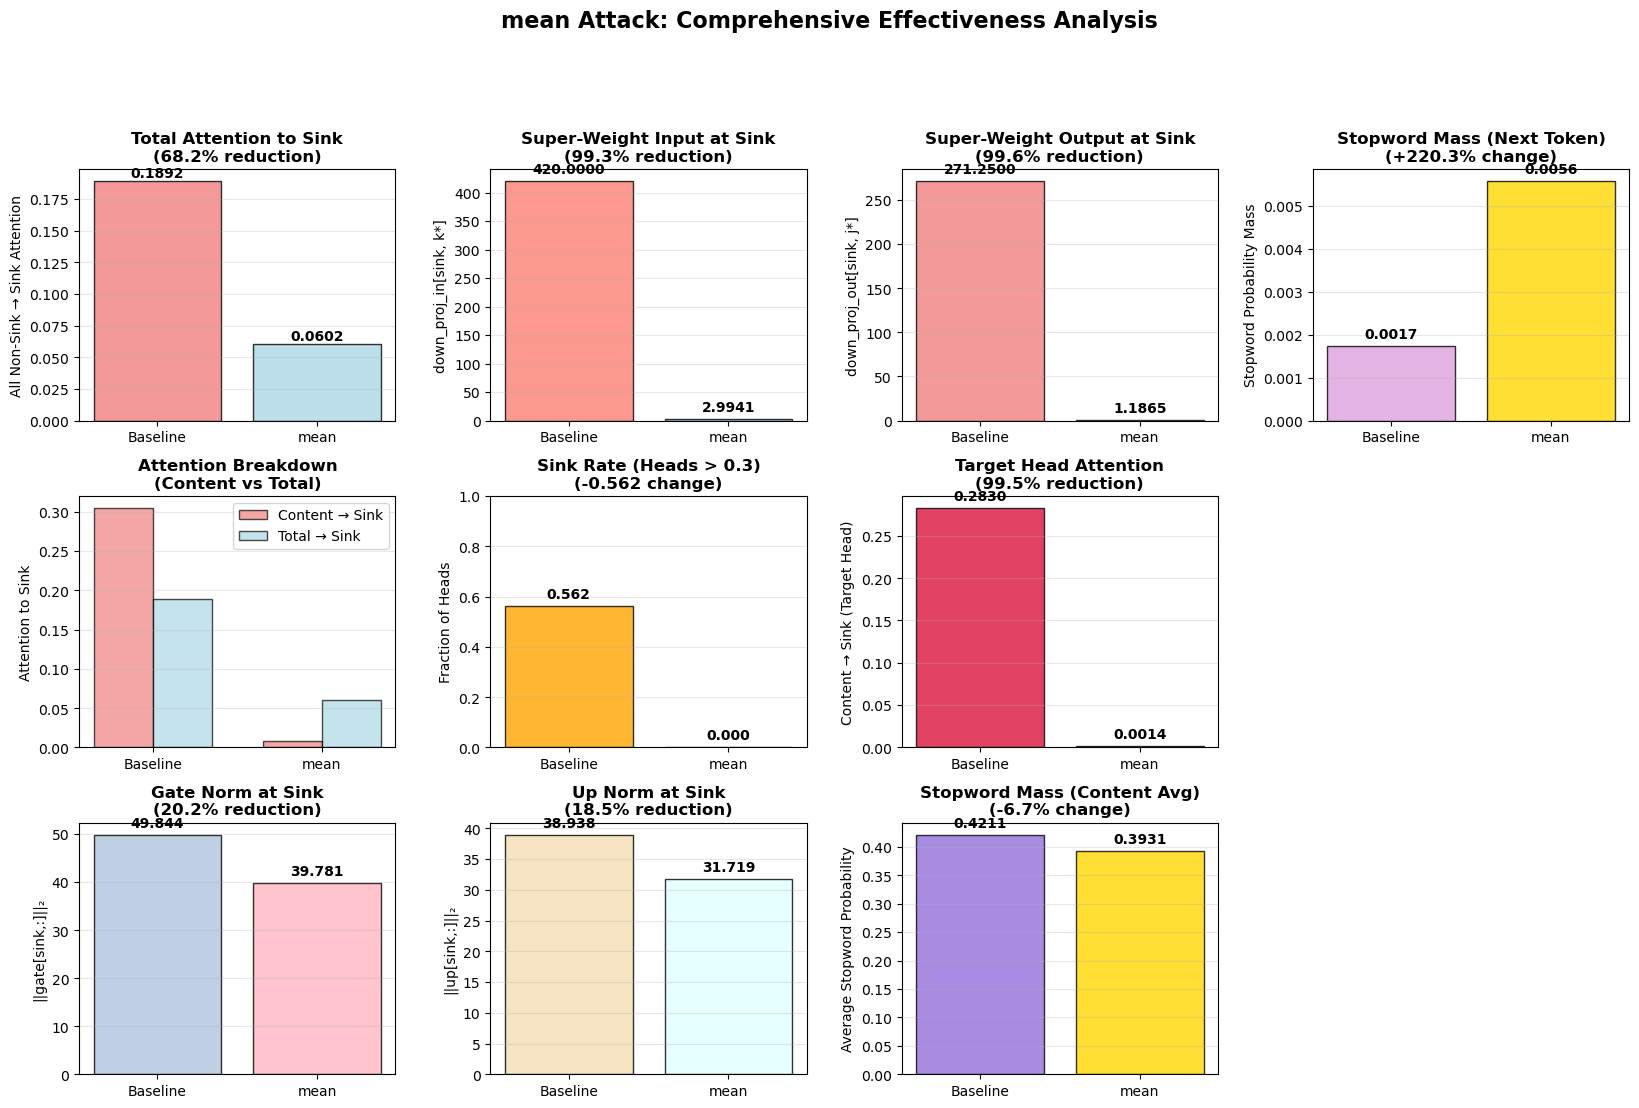


MEAN ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: 68.19%
   Super-Weight Input Suppression: 99.29%
   Super-Weight Output Suppression: 99.56%
   Stopword Mass Change: +220.26%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.5625
   Gate Norm Reduction: 20.19%
   Up Norm Reduction: 18.54%

=== Visualization for WEIGHTED ===


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


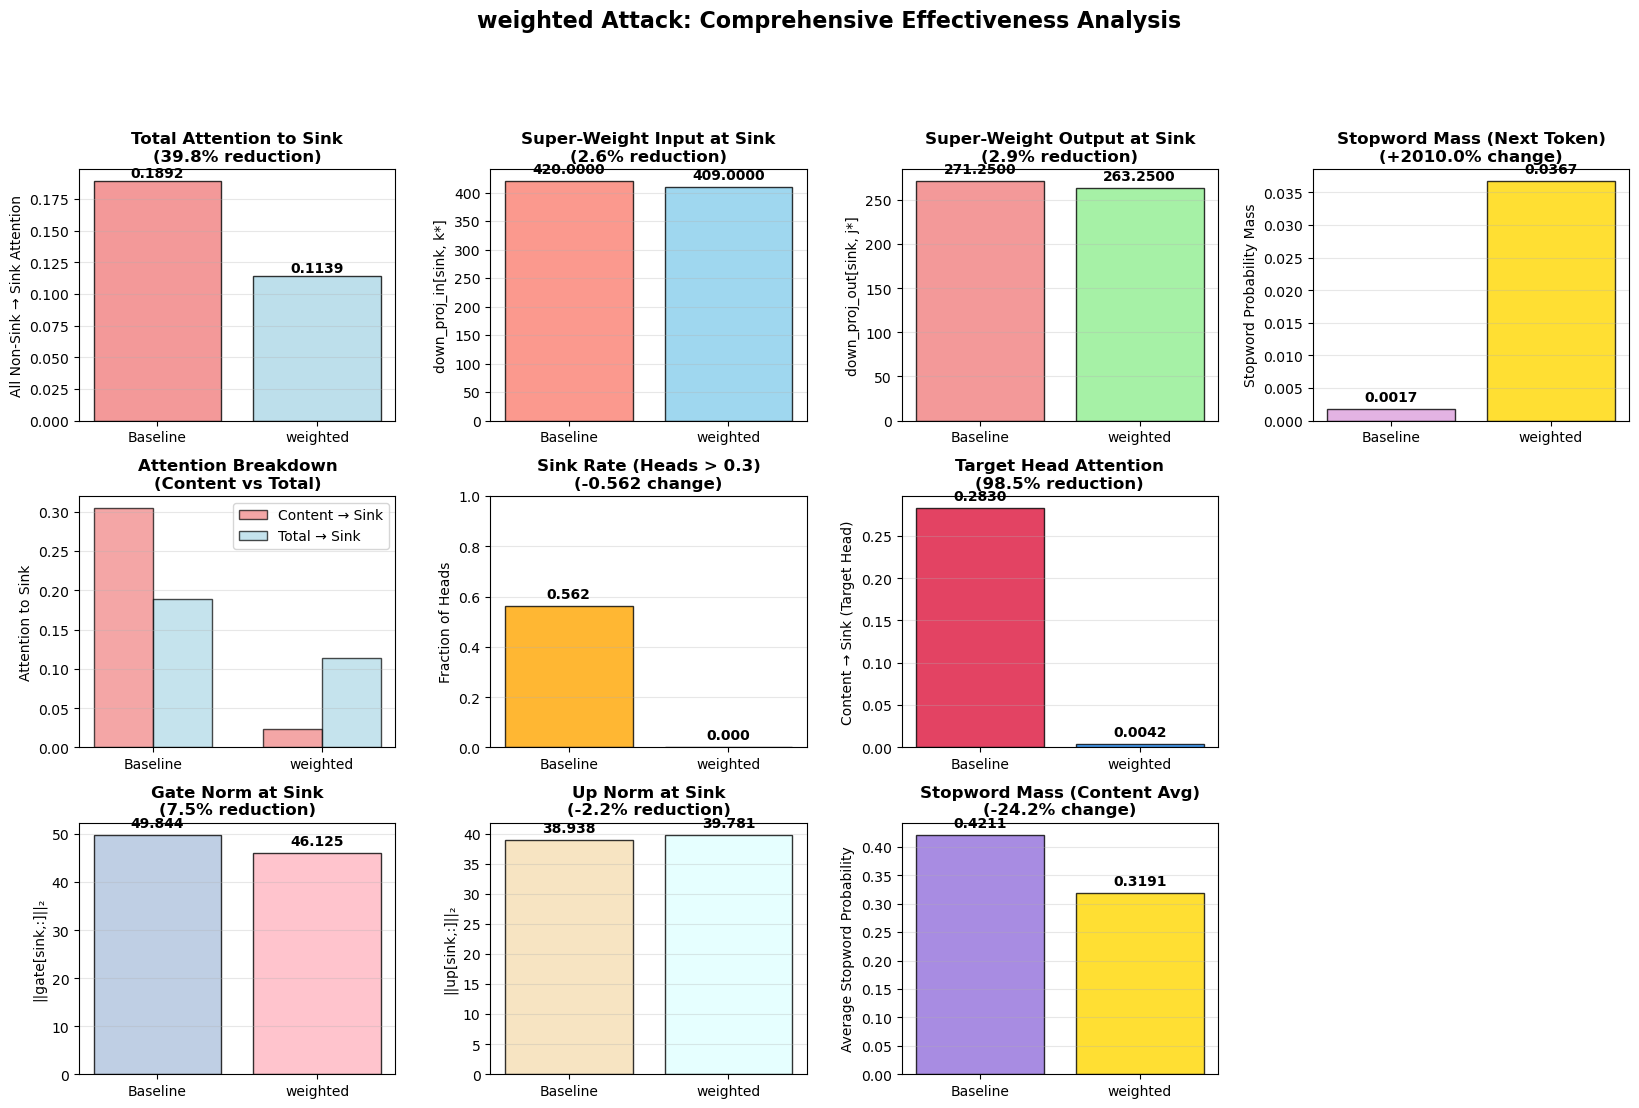


WEIGHTED ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: 39.81%
   Super-Weight Input Suppression: 2.62%
   Super-Weight Output Suppression: 2.95%
   Stopword Mass Change: +2009.97%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.5625
   Gate Norm Reduction: 7.46%
   Up Norm Reduction: -2.17%

=== Visualization for TOPK ===


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


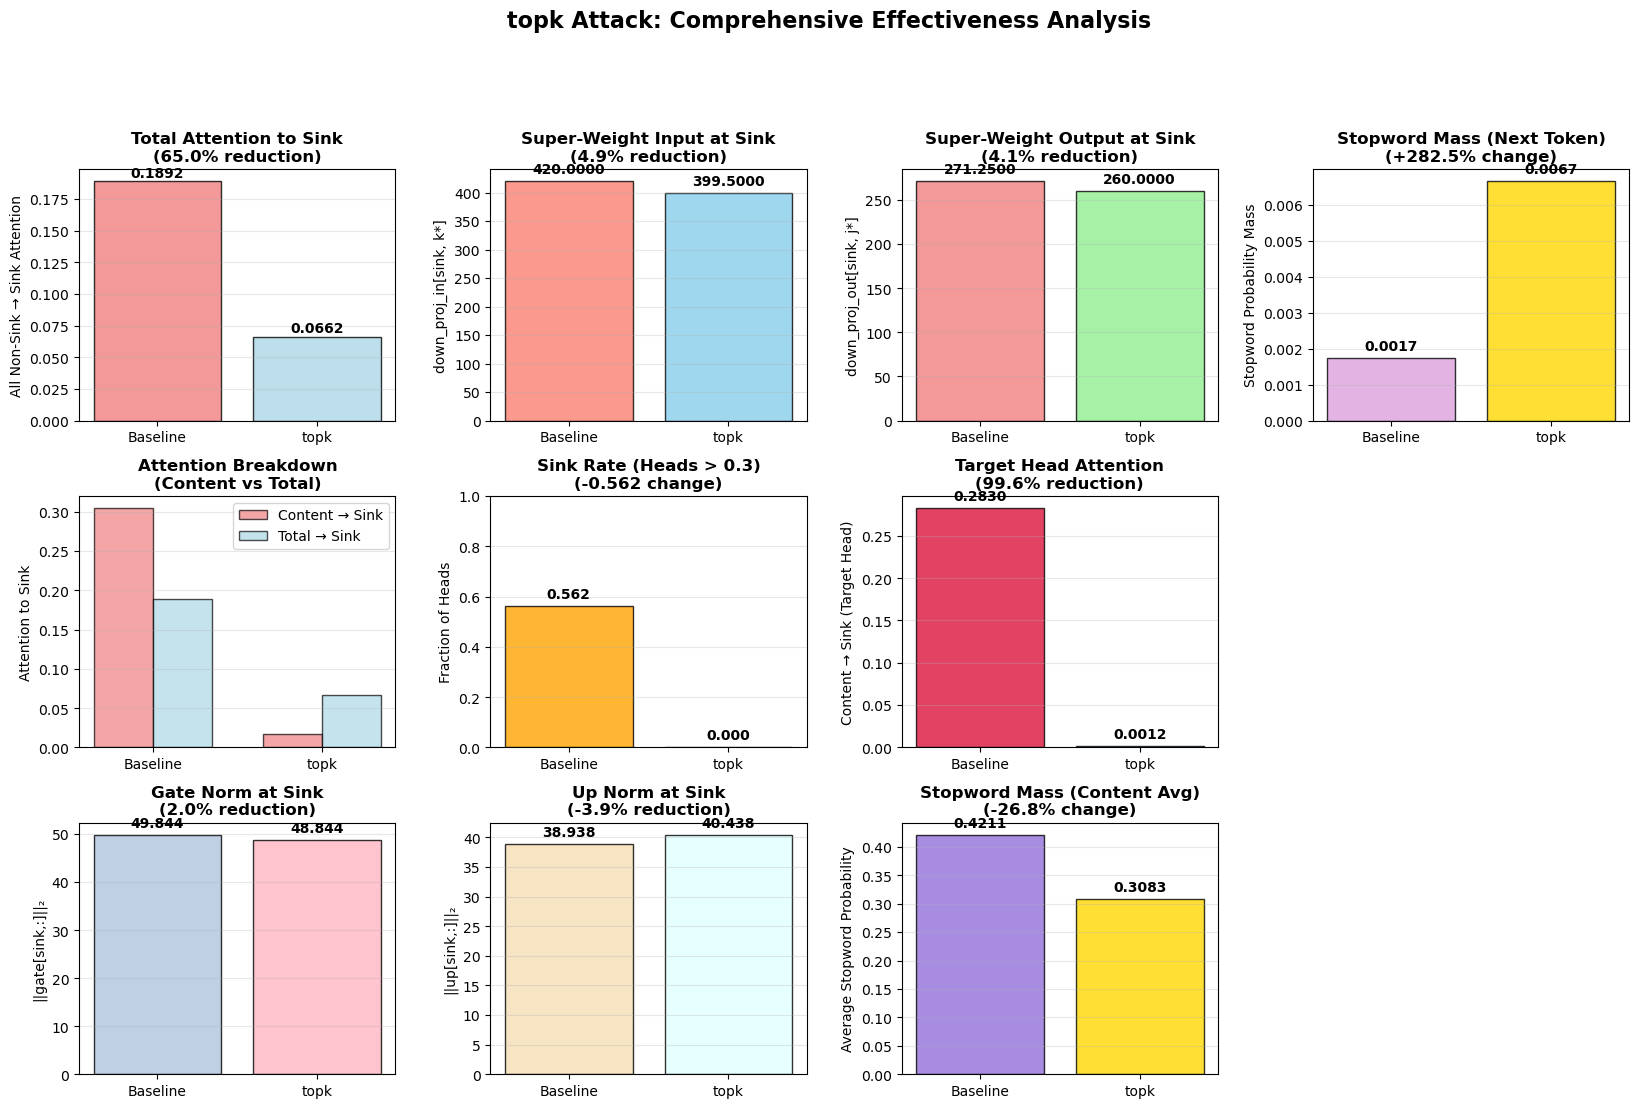


TOPK ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: 65.00%
   Super-Weight Input Suppression: 4.88%
   Super-Weight Output Suppression: 4.15%
   Stopword Mass Change: +282.48%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.5625
   Gate Norm Reduction: 2.01%
   Up Norm Reduction: -3.85%


In [ ]:
# for each method, plot the visualizations
for method_name, result in attack_results_D.items():
    print(f"\n=== Visualization for {method_name.upper()} ===")
    plot_comprehensive_attack_analysis(
        baseline_metrics=result['baseline_metrics'],
        attack_metrics=result['attack_metrics'],
        attack_name=method_name,
        attacker=result['attacker'],
        prompt_text=prompt_text,
        adv_text=result['attack_result']['final_adv_string']
    )

#### Hypothesis D with mean reduction method seems to work, check on held out dataset

In [21]:
from heldout_eval import run_multi_seed_consistency_evaluation

In [ ]:
metrics_to_check = (
    'down_proj_in_col_at_sink',
    'down_proj_out_row_at_sink',
)

heldout_results = run_multi_seed_consistency_evaluation(
    session=session,
    attacker=attack_results_D['mean']['attacker'],
    adv_string=attack_results_D['mean']['attack_result']['final_adv_string'],
    seeds=[41, 42, 43],
    n_prompts=100,
    min_tokens=6,
    max_tokens=40,
    metrics_of_interest=metrics_to_check,
    thresholds={
        'min_median_reduction': 20.0,       # 20%
        'min_p10_reduction': 10.0,          # 10%
        'median_variation_tolerance': 5.0   # +-5%
    },
    show_progress=True,
    set_all_seeds_fn=set_all_seeds
)

=== Multi-seed held-out evaluation ===
Seeds: [41, 42, 43]
Metrics: ('down_proj_in_col_at_sink', 'down_proj_out_row_at_sink')
Thresholds: {'min_median_reduction': 20.0, 'min_p10_reduction': 10.0, 'median_variation_tolerance': 5.0}
-------------------------------------

[Seed 41] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 99.26% (p10=99.20%, p90=99.29%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 99.55% (p10=99.51%, p90=99.57%) n_valid=100/100

[Seed 42] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 99.26% (p10=99.20%, p90=99.29%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 99.55% (p10=99.51%, p90=99.57%) n_valid=100/100

[Seed 43] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 99.26% (p10=99.20%, p90=99.29%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 99.55% (p10=99.51%, p90=99.57%) n_valid=100/100

=== PASS/FAIL SUMMARY ===
Metric: down_proj_in_col_at_sink
  Seed medians: ['99.26', '99.26', '99.26']
  Mean median: 99.26% | Max abs dev: 0.00%
  Min median observed: 99.26% (threshold 20.00%) -> pass=True
  Min p10 observed: 99.20% (threshold 10.00%) -> pass=True
  Stability pass (≤ 5.00%): True
  METRIC PASS: True
Metric: down_proj_out_row_at_sink
  Seed medians: ['99.55', '99.55', '99.55']
  Mean median: 99.55% | Max abs dev: 0.00%
  Min median observed: 99.55% (threshold 20.00%) -> pass=True
  Min p10 observed: 99.51% (threshold 10.00%) -> pass=True
  Stability pass (≤ 5.00%): True
  METRIC PASS: True

OVERALL PASS: True


## Hypothesis E (Reduce attention mass) — PoC
Directly minimize attention mass from adversarial rows to the first content column on the chosen head.

In [27]:
set_all_seeds(42)
session.model.eval()

cfg_E = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw),
    hypothesis='E',
    num_steps=100,
    adv_string_init="<bos> ~ <bos> ~ <bos>",
    search_width=256, top_k_search=128, batch_size=128,
    allow_non_ascii=True,
    prompt_text=prompt_text,
    placement='prefix'
)
attacker_E = SuperWeightAttacker(session.model, session.tokenizer, cfg_E)
res_E = attacker_E.attack()
res_E['final_adv_string']

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=E, placement=prefix, steps=100)


Attacking Hypothesis E:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=0.000052, final_adv=' confult Information，。****************************************************************************'


' confult Information，。****************************************************************************'

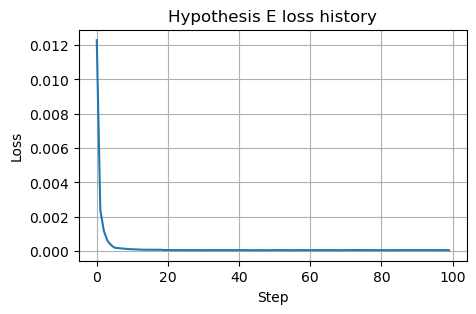

In [28]:
plt.figure(figsize=(5,3))
plt.plot(res_E['loss_history'])
plt.title('Hypothesis E loss history')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(True); plt.show()

In [29]:
adv_text_E = res_E['final_adv_string']
metrics_baseline_E = attacker_E.eval_metrics(adv_text="")
metrics_E = attacker_E.eval_metrics(adv_text=adv_text_E)
metrics_baseline_E, metrics_E

({'content_attn_to_sink_head': 0.0,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.0,
  'content_attn_to_sink_all_heads_mean': 0.304931640625,
  'total_attn_to_sink_all_heads_mean': 0.189208984375,
  'sink_rate': 0.5625,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 420.0,
  'down_proj_out_row_at_sink': 271.25,
  'gate_norm_at_sink': 49.84375,
  'up_norm_at_sink': 38.9375,
  'stopword_mass_next_token': 0.0017414093017578125,
  'stopword_mass_content_mean': 0.421142578125,
  'layout': {'content_start': 0,
   'content_end': 7,
   'adv_start': 7,
   'adv_len': 0,
   'prompt_len': 7,
   'placement': 'prefix',
   'sink_pos': 0,
   'has_bos': False}},
 {'content_attn_to_sink_head': 0.0,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.0,
  'content_attn_to_sink_all_heads_mean': 0.023345947265625,
  'total_attn_to_sink_all_heads_mean': 0.11688232421875,
  'sink_rate': 0.0,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 373.25,
  'down

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


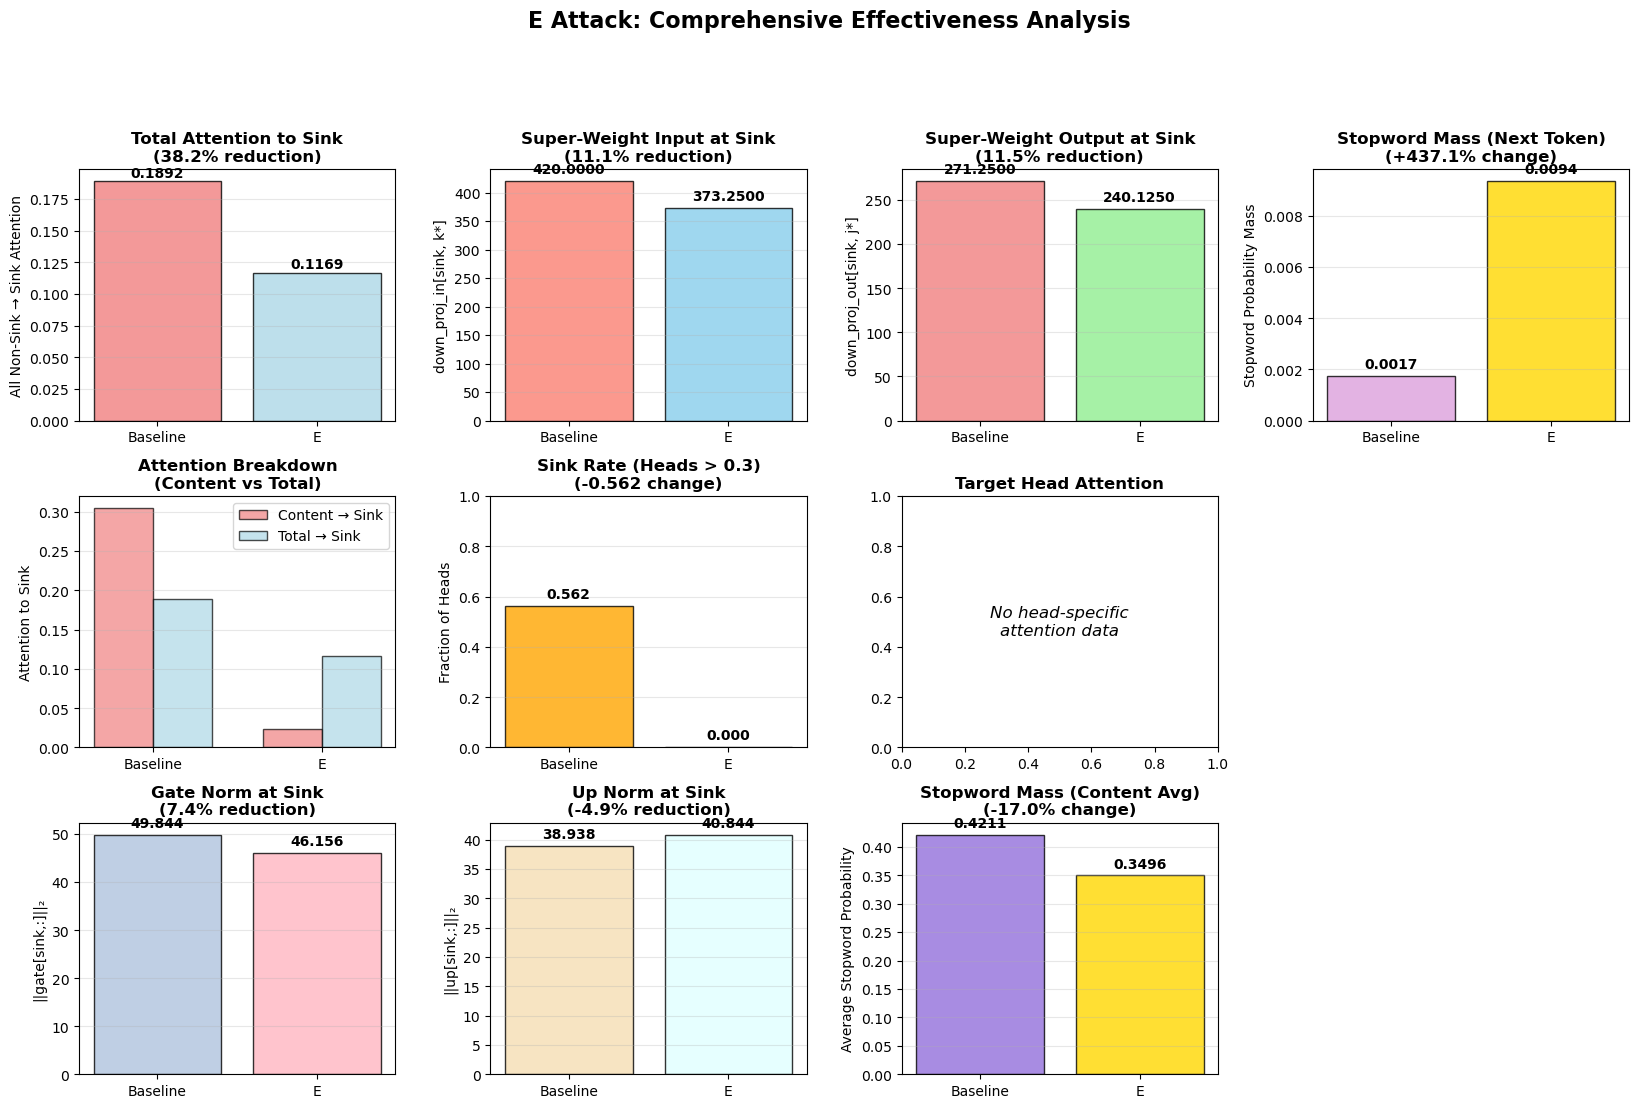


E ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: 38.23%
   Super-Weight Input Suppression: 11.13%
   Super-Weight Output Suppression: 11.47%
   Stopword Mass Change: +437.13%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.5625
   Gate Norm Reduction: 7.40%
   Up Norm Reduction: -4.90%


In [30]:
plot_comprehensive_attack_analysis(
    baseline_metrics=metrics_baseline_E,
    attack_metrics=metrics_E,
    attack_name='E',
    attacker=attacker_E,
    prompt_text=prompt_text,
    adv_text=adv_text_E
)

In [ ]:
metrics_to_check = (
    'down_proj_in_col_at_sink',
    'down_proj_out_row_at_sink',
)

heldout_results = run_multi_seed_consistency_evaluation(
    session=session,
    attacker=attacker_E,
    adv_string=adv_text_E,
    seeds=[41, 42, 43],
    n_prompts=100,
    min_tokens=6,
    max_tokens=40,
    metrics_of_interest=metrics_to_check,
    thresholds={
        'min_median_reduction': 20.0,       # 20%
        'min_p10_reduction': 10.0,          # 10%
        'median_variation_tolerance': 5.0   # +-5%
    },
    show_progress=True,
    set_all_seeds_fn=set_all_seeds
)

=== Multi-seed held-out evaluation ===
Seeds: [41, 42, 43]
Metrics: ('down_proj_in_col_at_sink', 'down_proj_out_row_at_sink')
Thresholds: {'min_median_reduction': 20.0, 'min_p10_reduction': 10.0, 'median_variation_tolerance': 5.0}
-------------------------------------

[Seed 41] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 6.92% (p10=-0.73%, p90=10.76%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 7.47% (p10=0.23%, p90=11.23%) n_valid=100/100

[Seed 42] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 6.92% (p10=-0.73%, p90=10.76%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 7.47% (p10=0.23%, p90=11.23%) n_valid=100/100

[Seed 43] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 6.92% (p10=-0.73%, p90=10.76%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 7.47% (p10=0.23%, p90=11.23%) n_valid=100/100

=== PASS/FAIL SUMMARY ===
Metric: down_proj_in_col_at_sink
  Seed medians: ['6.92', '6.92', '6.92']
  Mean median: 6.92% | Max abs dev: 0.00%
  Min median observed: 6.92% (threshold 20.00%) -> pass=False
  Min p10 observed: -0.73% (threshold 10.00%) -> pass=False
  Stability pass (≤ 5.00%): True
  METRIC PASS: False
Metric: down_proj_out_row_at_sink
  Seed medians: ['7.47', '7.47', '7.47']
  Mean median: 7.47% | Max abs dev: 0.00%
  Min median observed: 7.47% (threshold 20.00%) -> pass=False
  Min p10 observed: 0.23% (threshold 10.00%) -> pass=False
  Stability pass (≤ 5.00%): True
  METRIC PASS: False

OVERALL PASS: False


## Hypotheses A (activation suppression)

In [32]:
set_all_seeds(42)
session.model.eval()

# Test Hypothesis A - Minimize input magnitude to down_proj on super-weight column
cfg_A = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw),
    hypothesis='A',
    num_steps=100,
    adv_string_init="<bos> ~ <bos> ~ <bos>",
    search_width=256, top_k_search=128, batch_size=128,
    allow_non_ascii=True,
    prompt_text=prompt_text,
    placement='prefix'
)
attacker_A = SuperWeightAttacker(session.model, session.tokenizer, cfg_A)
res_A = attacker_A.attack()
res_A['final_adv_string']

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=A, placement=prefix, steps=100)


Attacking Hypothesis A:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=0.143555, final_adv='(+�d319fS{M'


'(+�d319fS{M'

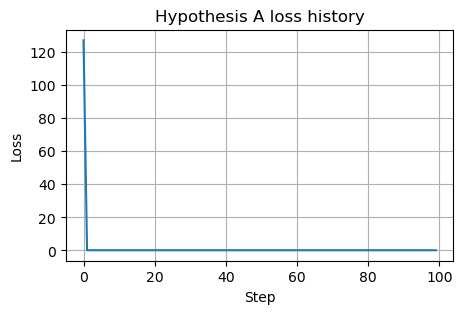

In [33]:
# Plot loss history for Hypothesis A
plt.figure(figsize=(5,3))
plt.plot(res_A['loss_history'])
plt.title('Hypothesis A loss history')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(True); plt.show()

In [34]:
# Evaluate metrics for Hypothesis A
adv_text_A = res_A['final_adv_string']
metrics_baseline_A = attacker_A.eval_metrics(adv_text="")
metrics_A = attacker_A.eval_metrics(adv_text=adv_text_A)
metrics_baseline_A, metrics_A

({'content_attn_to_sink_head': 0.0,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.0,
  'content_attn_to_sink_all_heads_mean': 0.304931640625,
  'total_attn_to_sink_all_heads_mean': 0.189208984375,
  'sink_rate': 0.5625,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 420.0,
  'down_proj_out_row_at_sink': 271.25,
  'gate_norm_at_sink': 49.84375,
  'up_norm_at_sink': 38.9375,
  'stopword_mass_next_token': 0.0017414093017578125,
  'stopword_mass_content_mean': 0.421142578125,
  'layout': {'content_start': 0,
   'content_end': 7,
   'adv_start': 7,
   'adv_len': 0,
   'prompt_len': 7,
   'placement': 'prefix',
   'sink_pos': 0,
   'has_bos': False}},
 {'content_attn_to_sink_head': 0.0,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.0,
  'content_attn_to_sink_all_heads_mean': 0.049102783203125,
  'total_attn_to_sink_all_heads_mean': 0.171875,
  'sink_rate': 0.0,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 302.5,
  'down_proj_out

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


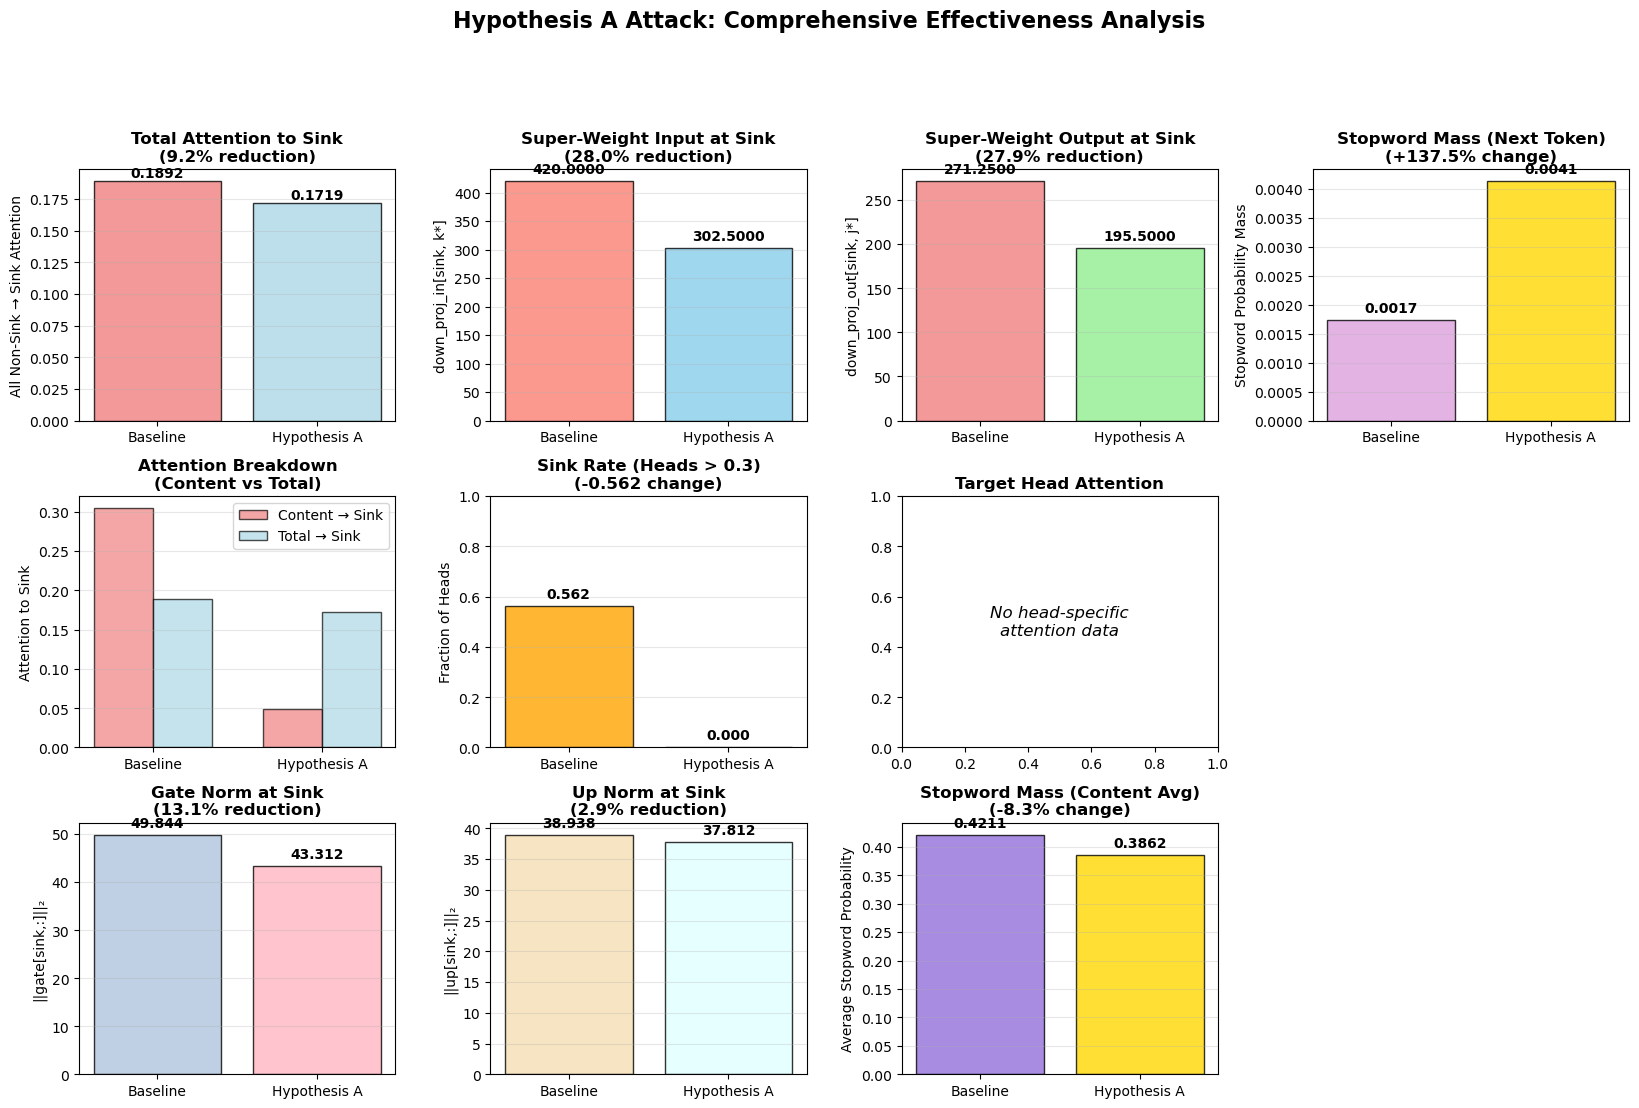


HYPOTHESIS A ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: 9.16%
   Super-Weight Input Suppression: 27.98%
   Super-Weight Output Suppression: 27.93%
   Stopword Mass Change: +137.46%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.5625
   Gate Norm Reduction: 13.10%
   Up Norm Reduction: 2.89%


In [35]:
# Comprehensive visualization for Hypothesis A
plot_comprehensive_attack_analysis(
    baseline_metrics=metrics_baseline_A,
    attack_metrics=metrics_A,
    attack_name='Hypothesis A',
    attacker=attacker_A,
    prompt_text=prompt_text,
    adv_text=adv_text_A
)

## Hypothesis B
Hypothesis B targets the L2 norm of the gate projection output at the sink position. It should show effectiveness primarily in the "Gate Norm at Sink" metric, as it's designed to reduce the gating factor in the MLP computation X = SiLU(gate) ⊙ up.

In [40]:
set_all_seeds(42)
session.model.eval()
# Test Hypothesis B - Minimize L2 norm of gate projection output at target position
cfg_B = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw),
    hypothesis='B',
    num_steps=100,
    adv_string_init="<bos> ~ <bos> ~ <bos>",
    search_width=256, top_k_search=128, batch_size=128,
    allow_non_ascii=True,
    prompt_text=prompt_text,
    placement='prefix'
)
attacker_B = SuperWeightAttacker(session.model, session.tokenizer, cfg_B)
res_B = attacker_B.attack()
res_B['final_adv_string']

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=B, placement=prefix, steps=100)


Attacking Hypothesis B:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=32.062500, final_adv=' the+�d319fS{M'


' the+�d319fS{M'

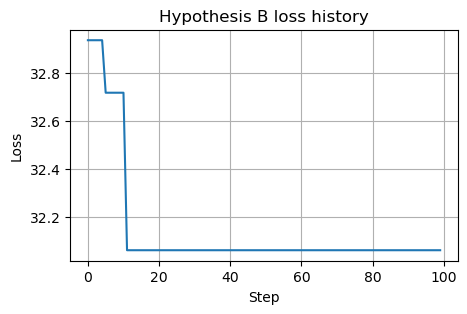

In [41]:
# Plot loss history for Hypothesis B
plt.figure(figsize=(5,3))
plt.plot(res_B['loss_history'])
plt.title('Hypothesis B loss history')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(True); plt.show()

In [42]:
# Evaluate metrics for Hypothesis B
adv_text_B = res_B['final_adv_string']
metrics_baseline_B = attacker_B.eval_metrics(adv_text="")
metrics_B = attacker_B.eval_metrics(adv_text=adv_text_B)
metrics_baseline_B, metrics_B

({'content_attn_to_sink_head': 0.0,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.0,
  'content_attn_to_sink_all_heads_mean': 0.304931640625,
  'total_attn_to_sink_all_heads_mean': 0.189208984375,
  'sink_rate': 0.5625,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 420.0,
  'down_proj_out_row_at_sink': 271.25,
  'gate_norm_at_sink': 49.84375,
  'up_norm_at_sink': 38.9375,
  'stopword_mass_next_token': 0.0017414093017578125,
  'stopword_mass_content_mean': 0.421142578125,
  'layout': {'content_start': 0,
   'content_end': 7,
   'adv_start': 7,
   'adv_len': 0,
   'prompt_len': 7,
   'placement': 'prefix',
   'sink_pos': 0,
   'has_bos': False}},
 {'content_attn_to_sink_head': 0.0,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.0,
  'content_attn_to_sink_all_heads_mean': 0.3330078125,
  'total_attn_to_sink_all_heads_mean': 0.44677734375,
  'sink_rate': 0.625,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 363.5,
  'down_proj_o

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


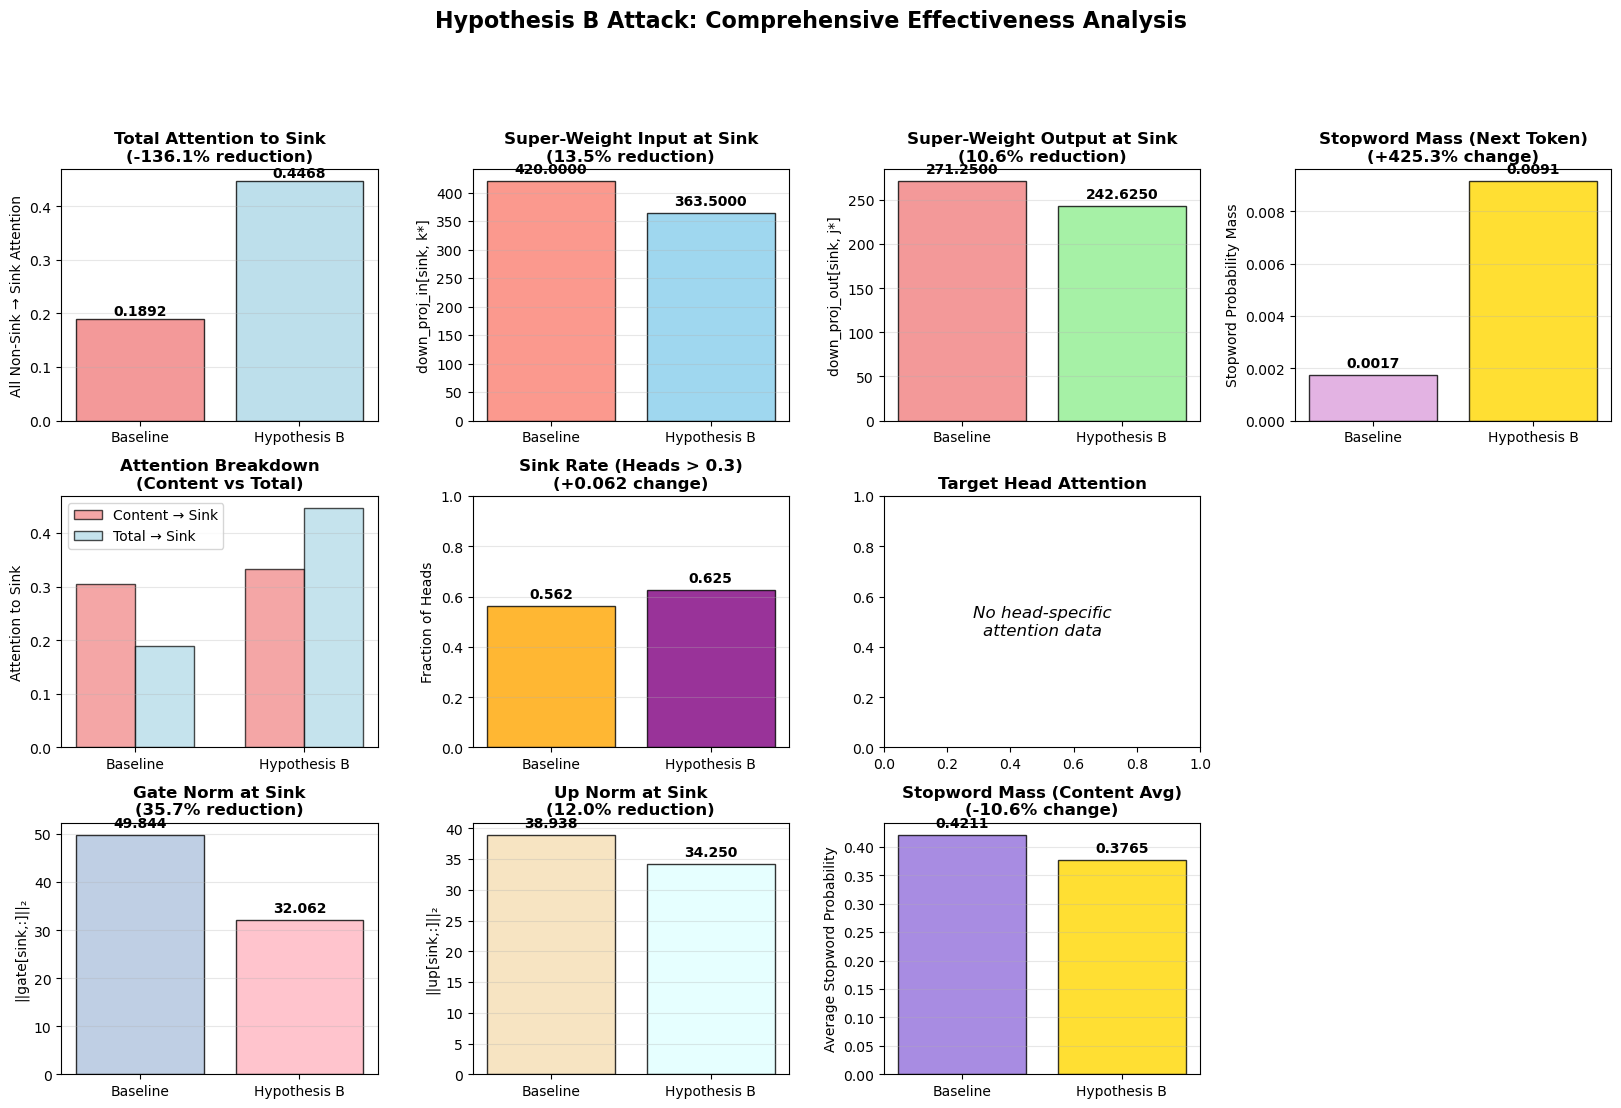


HYPOTHESIS B ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: -136.13%
   Super-Weight Input Suppression: 13.45%
   Super-Weight Output Suppression: 10.55%
   Stopword Mass Change: +425.30%

📊 SECONDARY METRICS:
   Sink Rate Change: +0.0625
   Gate Norm Reduction: 35.67%
   Up Norm Reduction: 12.04%


In [43]:
# Comprehensive visualization for Hypothesis B
plot_comprehensive_attack_analysis(
    baseline_metrics=metrics_baseline_B,
    attack_metrics=metrics_B,
    attack_name='Hypothesis B',
    attacker=attacker_B,
    prompt_text=prompt_text,
    adv_text=adv_text_B
)

## Hypothesis C
Hypothesis C aims at the L2 norm of the up projection output at the sink position. It should show effectiveness primarily in the "Up Norm at Sink" metric, as it's designed to reduce the up projection factor in the MLP computation X = SiLU(gate) ⊙ up.

In [44]:
set_all_seeds(42)
session.model.eval()
# Test Hypothesis C - Minimize L2 norm of up projection output at target position
cfg_C = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw),
    hypothesis='C',
    num_steps=100,
    adv_string_init="<bos> ~ <bos> ~ <bos>",
    search_width=256, top_k_search=128, batch_size=128,
    allow_non_ascii=True,
    prompt_text=prompt_text,
    placement='prefix'
)
attacker_C = SuperWeightAttacker(session.model, session.tokenizer, cfg_C)
res_C = attacker_C.attack()
res_C['final_adv_string']

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=C, placement=prefix, steps=100)


Attacking Hypothesis C:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=26.390625, final_adv='(+�d319fS{M'


'(+�d319fS{M'

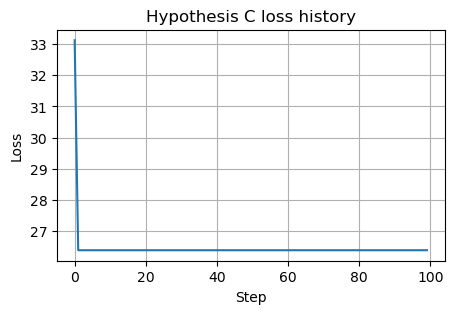

In [45]:
# Plot loss history for Hypothesis C
plt.figure(figsize=(5,3))
plt.plot(res_C['loss_history'])
plt.title('Hypothesis C loss history')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(True); plt.show()

In [46]:
# Evaluate metrics for Hypothesis C
adv_text_C = res_C['final_adv_string']
metrics_baseline_C = attacker_C.eval_metrics(adv_text="")
metrics_C = attacker_C.eval_metrics(adv_text=adv_text_C)
metrics_baseline_C, metrics_C

({'content_attn_to_sink_head': 0.0,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.0,
  'content_attn_to_sink_all_heads_mean': 0.304931640625,
  'total_attn_to_sink_all_heads_mean': 0.189208984375,
  'sink_rate': 0.5625,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 420.0,
  'down_proj_out_row_at_sink': 271.25,
  'gate_norm_at_sink': 49.84375,
  'up_norm_at_sink': 38.9375,
  'stopword_mass_next_token': 0.0017414093017578125,
  'stopword_mass_content_mean': 0.421142578125,
  'layout': {'content_start': 0,
   'content_end': 7,
   'adv_start': 7,
   'adv_len': 0,
   'prompt_len': 7,
   'placement': 'prefix',
   'sink_pos': 0,
   'has_bos': False}},
 {'content_attn_to_sink_head': 0.0,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.0,
  'content_attn_to_sink_all_heads_mean': 0.049102783203125,
  'total_attn_to_sink_all_heads_mean': 0.171875,
  'sink_rate': 0.0,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 302.5,
  'down_proj_out

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


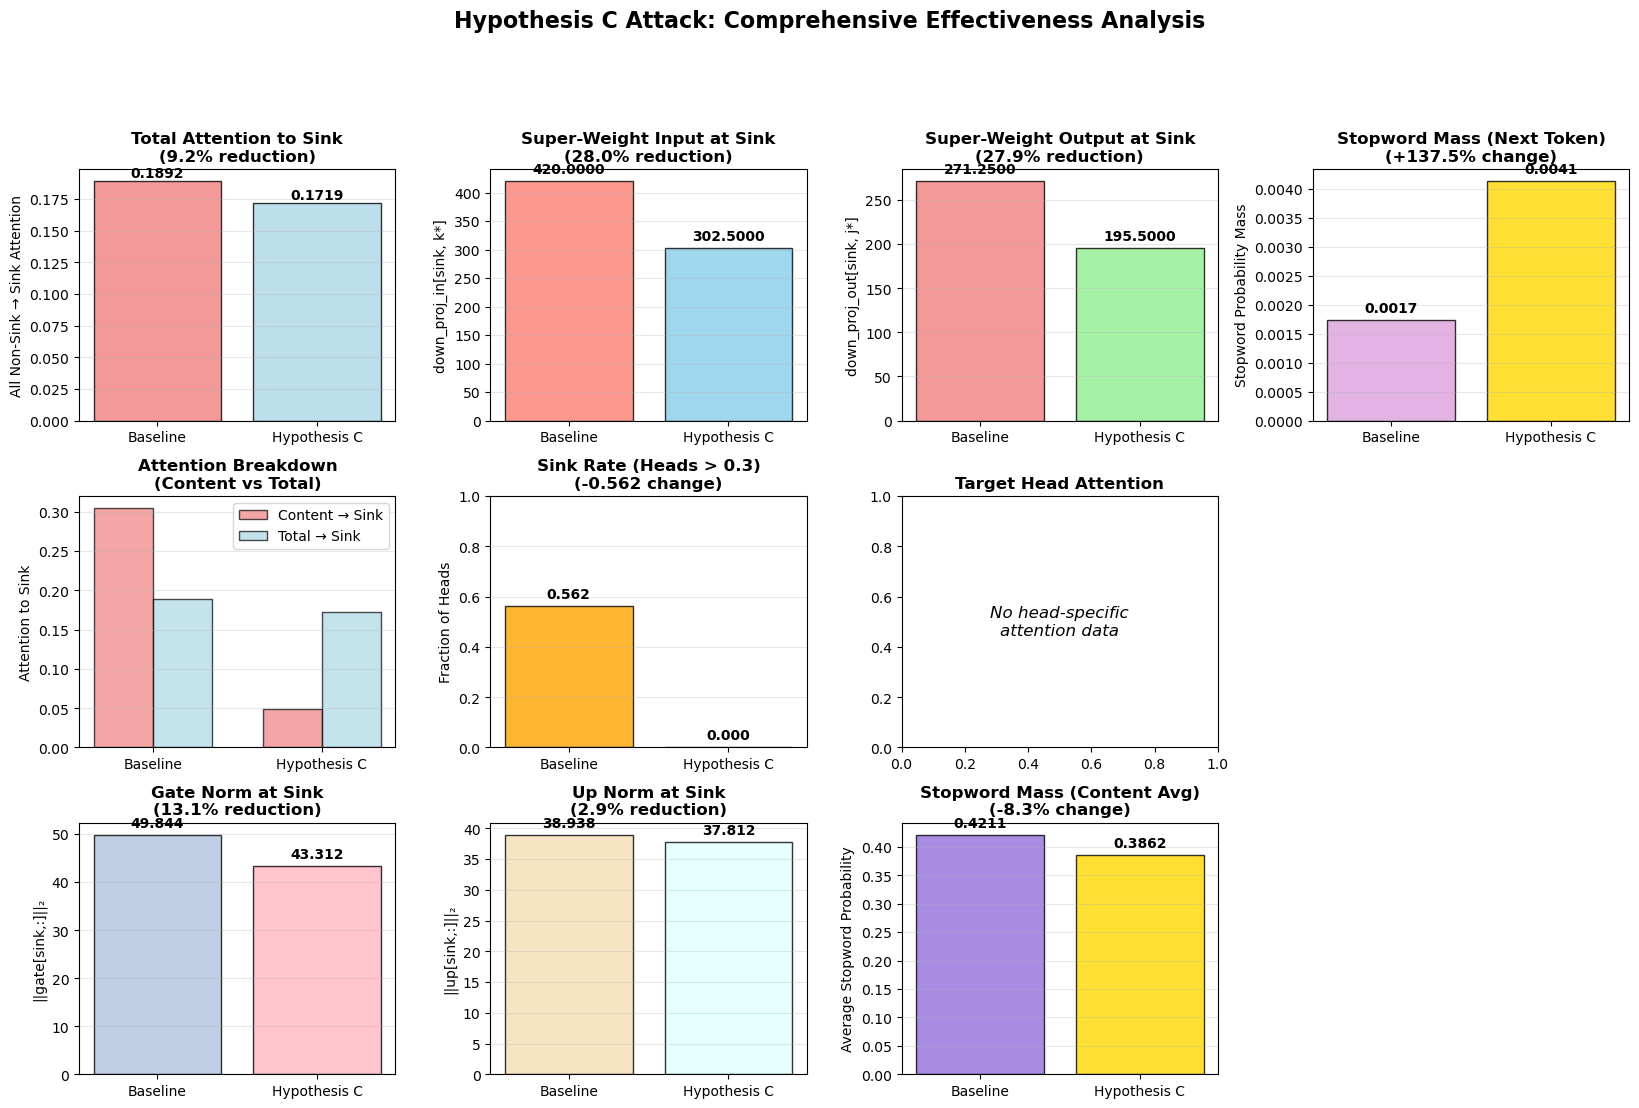


HYPOTHESIS C ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: 9.16%
   Super-Weight Input Suppression: 27.98%
   Super-Weight Output Suppression: 27.93%
   Stopword Mass Change: +137.46%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.5625
   Gate Norm Reduction: 13.10%
   Up Norm Reduction: 2.89%


In [47]:
# Comprehensive visualization for Hypothesis C
plot_comprehensive_attack_analysis(
    baseline_metrics=metrics_baseline_C,
    attack_metrics=metrics_C,
    attack_name='Hypothesis C',
    attacker=attacker_C,
    prompt_text=prompt_text,
    adv_text=adv_text_C
)

## Composite Losses

### D + A + C (weighted D, small A, tiny C)

In [48]:
set_all_seeds(42)
session.model.eval()
# Test Combination D+A+C - Weighted D with activation suppression
cfg_combo1 = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw),
    hypothesis='D',  # Primary hypothesis (required field)
    loss_weights={
        'D': 1.0,    # Mean head reduction 
        'A': 0.20,   # Activation suppression
        'C': 0.10    # Attention reduction
    },
    head_reduction="mean",  # For Hypothesis D
    tau=2.0,
    num_steps=100,
    adv_string_init="<bos> ~ <bos> ~ <bos>",
    search_width=256, top_k_search=128, batch_size=128,
    allow_non_ascii=True,
    prompt_text=prompt_text,
    placement='prefix'
)
attacker_combo1 = SuperWeightAttacker(session.model, session.tokenizer, cfg_combo1)
res_combo1 = attacker_combo1.attack()
res_combo1['final_adv_string']

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: No head_idx provided for hypothesis D - auto-selecting best head
[INFO] super_weights.attack: Selected attention-based head 10 (layer 1) with sink score 2.1094 (has_bos=False)
[INFO] super_weights.attack: Auto-selected head 10 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=['D', 'A', 'C'], placement=prefix, steps=100)


HypothesisD initialized with head_reduction='mean', topk=4, tau=2.0


Attacking Hypothesis D:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=0.145996, final_adv='
                                           (\< theforeach]]>。



 annotations varchar/+'


'\n                                           (\\< theforeach]]>。\n\n\n\n annotations varchar/+'

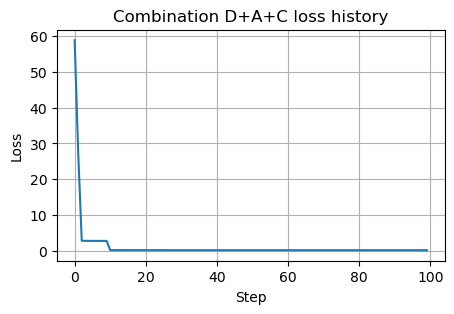

In [49]:
# Plot loss history for Combination D+A+C
plt.figure(figsize=(5,3))
plt.plot(res_combo1['loss_history'])
plt.title('Combination D+A+C loss history')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(True); plt.show()

In [50]:
# Evaluate metrics for Combination D+A+C
adv_text_combo1 = res_combo1['final_adv_string']
metrics_baseline_combo1 = attacker_combo1.eval_metrics(adv_text="")
metrics_combo1 = attacker_combo1.eval_metrics(adv_text=adv_text_combo1)
metrics_baseline_combo1, metrics_combo1

({'content_attn_to_sink_head': 0.444091796875,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.3515625,
  'content_attn_to_sink_all_heads_mean': 0.304931640625,
  'total_attn_to_sink_all_heads_mean': 0.189208984375,
  'sink_rate': 0.5625,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 420.0,
  'down_proj_out_row_at_sink': 271.25,
  'gate_norm_at_sink': 49.84375,
  'up_norm_at_sink': 38.9375,
  'stopword_mass_next_token': 0.0017414093017578125,
  'stopword_mass_content_mean': 0.421142578125,
  'layout': {'content_start': 0,
   'content_end': 7,
   'adv_start': 7,
   'adv_len': 0,
   'prompt_len': 7,
   'placement': 'prefix',
   'sink_pos': 0,
   'has_bos': False}},
 {'content_attn_to_sink_head': 0.061065673828125,
  'adv_attn_to_sink_head': 0.20361328125,
  'total_attn_to_sink_head': 0.109130859375,
  'content_attn_to_sink_all_heads_mean': 0.1591796875,
  'total_attn_to_sink_all_heads_mean': 0.27734375,
  'sink_rate': 0.0625,
  'attn_entropy_content': nan,
 

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


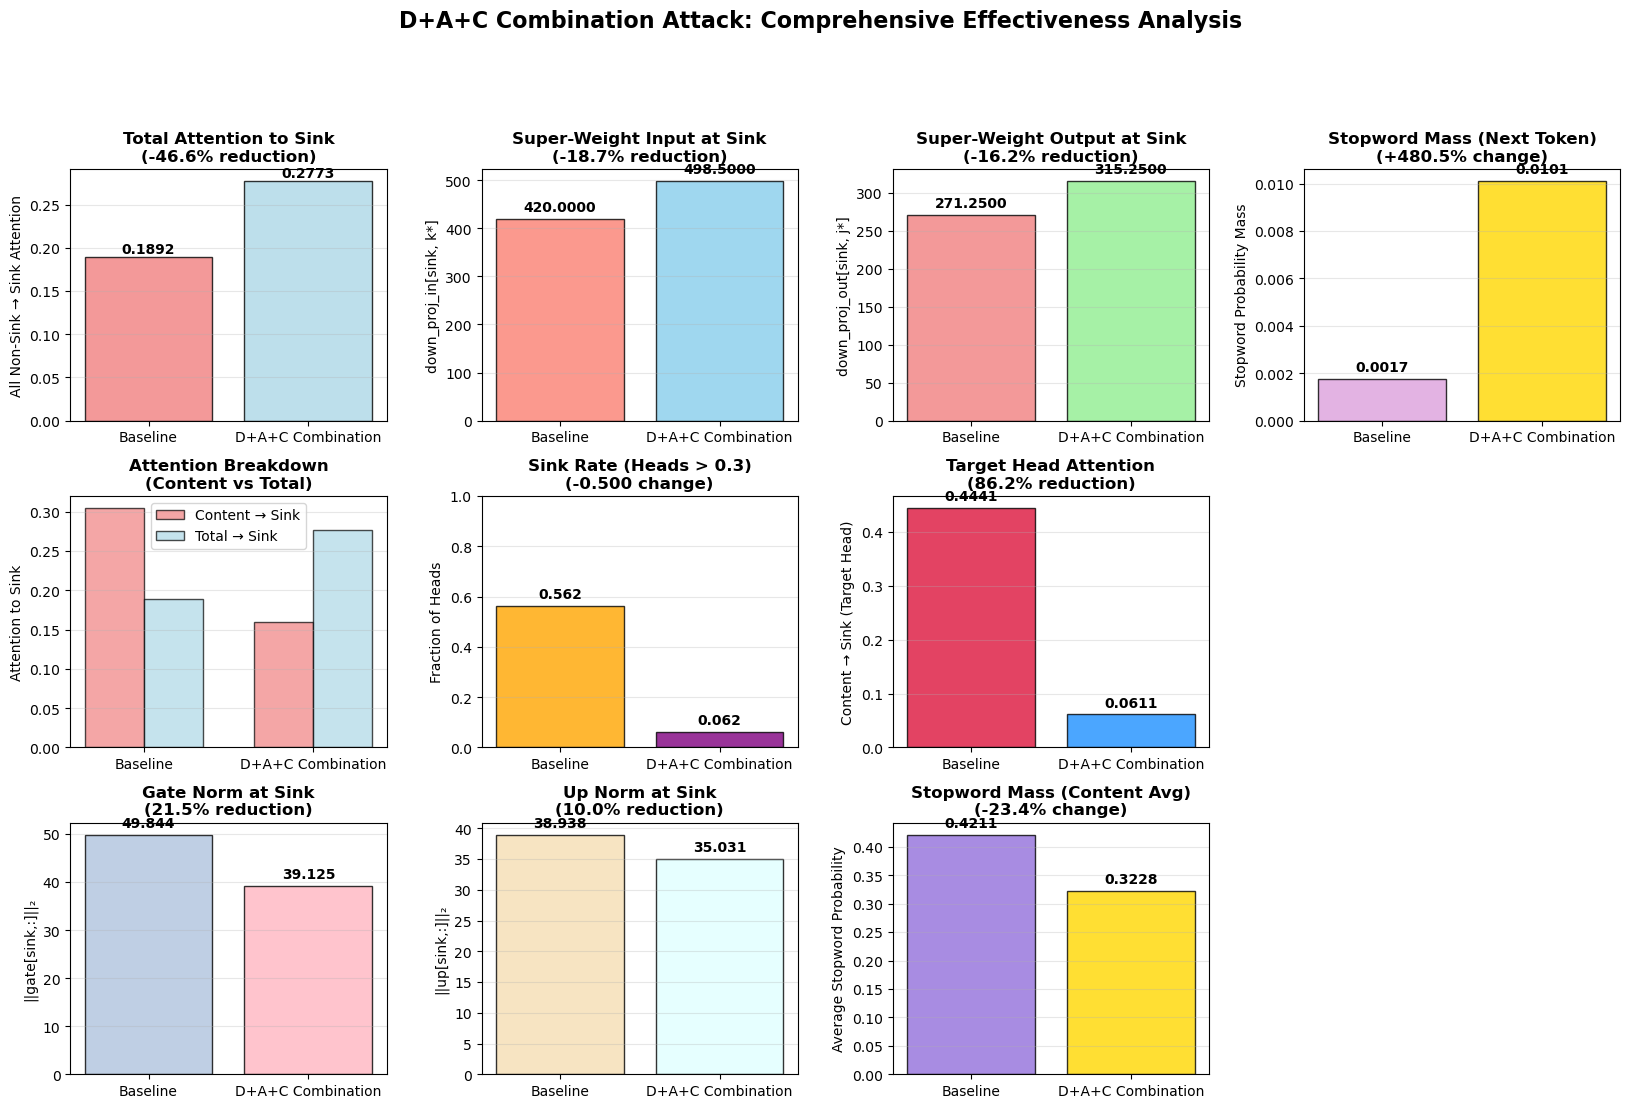


D+A+C COMBINATION ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: -46.58%
   Super-Weight Input Suppression: -18.69%
   Super-Weight Output Suppression: -16.22%
   Stopword Mass Change: +480.50%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.5000
   Gate Norm Reduction: 21.50%
   Up Norm Reduction: 10.03%


In [51]:
# Comprehensive visualization for Combination D+A+C
plot_comprehensive_attack_analysis(
    baseline_metrics=metrics_baseline_combo1,
    attack_metrics=metrics_combo1,
    attack_name='D+A+C Combination',
    attacker=attacker_combo1,
    prompt_text=prompt_text,
    adv_text=adv_text_combo1
)

### D + E (mean D with tiny E)

In [52]:
set_all_seeds(42)
session.model.eval()
# Test Combination D+E - Mean head reduction with tiny attention suppression
cfg_combo2 = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw),
    hypothesis='D',  # Primary hypothesis (required field)
    loss_weights={
        'D': 1.0,    # Mean over all heads
        'E': 0.10    # Tiny attention reduction 
    },
    head_reduction="mean",  # For Hypothesis D
    num_steps=100,
    adv_string_init="<bos> ~ <bos> ~ <bos>",
    search_width=256, top_k_search=128, batch_size=128,
    allow_non_ascii=True,
    prompt_text=prompt_text,
    placement='prefix'
)
attacker_combo2 = SuperWeightAttacker(session.model, session.tokenizer, cfg_combo2)
res_combo2 = attacker_combo2.attack()
res_combo2['final_adv_string']

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: No head_idx provided for hypothesis D - auto-selecting best head
[INFO] super_weights.attack: Selected attention-based head 10 (layer 1) with sink score 2.1094 (has_bos=False)
[INFO] super_weights.attack: Auto-selected head 10 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=['D', 'E'], placement=prefix, steps=100)


HypothesisD initialized with head_reduction='mean', topk=4, tau=0.5


Attacking Hypothesis D:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=-0.145630, final_adv=' prud reprodu relinqu badly-% downloadacketacketacketacketNews'


' prud reprodu relinqu badly-% downloadacketacketacketacketNews'

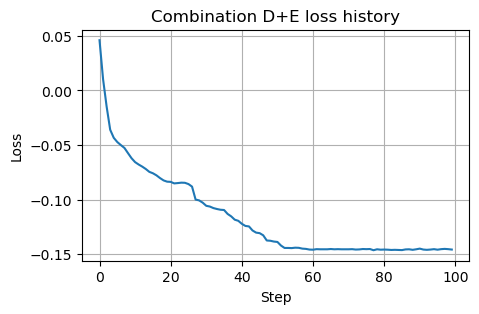

In [53]:
# Plot loss history for Combination D+E
plt.figure(figsize=(5,3))
plt.plot(res_combo2['loss_history'])
plt.title('Combination D+E loss history')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(True); plt.show()

In [54]:
# Evaluate metrics for Combination D+E
adv_text_combo2 = res_combo2['final_adv_string']
metrics_baseline_combo2 = attacker_combo2.eval_metrics(adv_text="")
metrics_combo2 = attacker_combo2.eval_metrics(adv_text=adv_text_combo2)
metrics_baseline_combo2, metrics_combo2

({'content_attn_to_sink_head': 0.444091796875,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.3515625,
  'content_attn_to_sink_all_heads_mean': 0.304931640625,
  'total_attn_to_sink_all_heads_mean': 0.189208984375,
  'sink_rate': 0.5625,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 420.0,
  'down_proj_out_row_at_sink': 271.25,
  'gate_norm_at_sink': 49.84375,
  'up_norm_at_sink': 38.9375,
  'stopword_mass_next_token': 0.0017414093017578125,
  'stopword_mass_content_mean': 0.421142578125,
  'layout': {'content_start': 0,
   'content_end': 7,
   'adv_start': 7,
   'adv_len': 0,
   'prompt_len': 7,
   'placement': 'prefix',
   'sink_pos': 0,
   'has_bos': False}},
 {'content_attn_to_sink_head': 0.0655517578125,
  'adv_attn_to_sink_head': 0.3095703125,
  'total_attn_to_sink_head': 0.16845703125,
  'content_attn_to_sink_all_heads_mean': 0.04071044921875,
  'total_attn_to_sink_all_heads_mean': 0.1287841796875,
  'sink_rate': 0.0,
  'attn_entropy_content': nan,

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


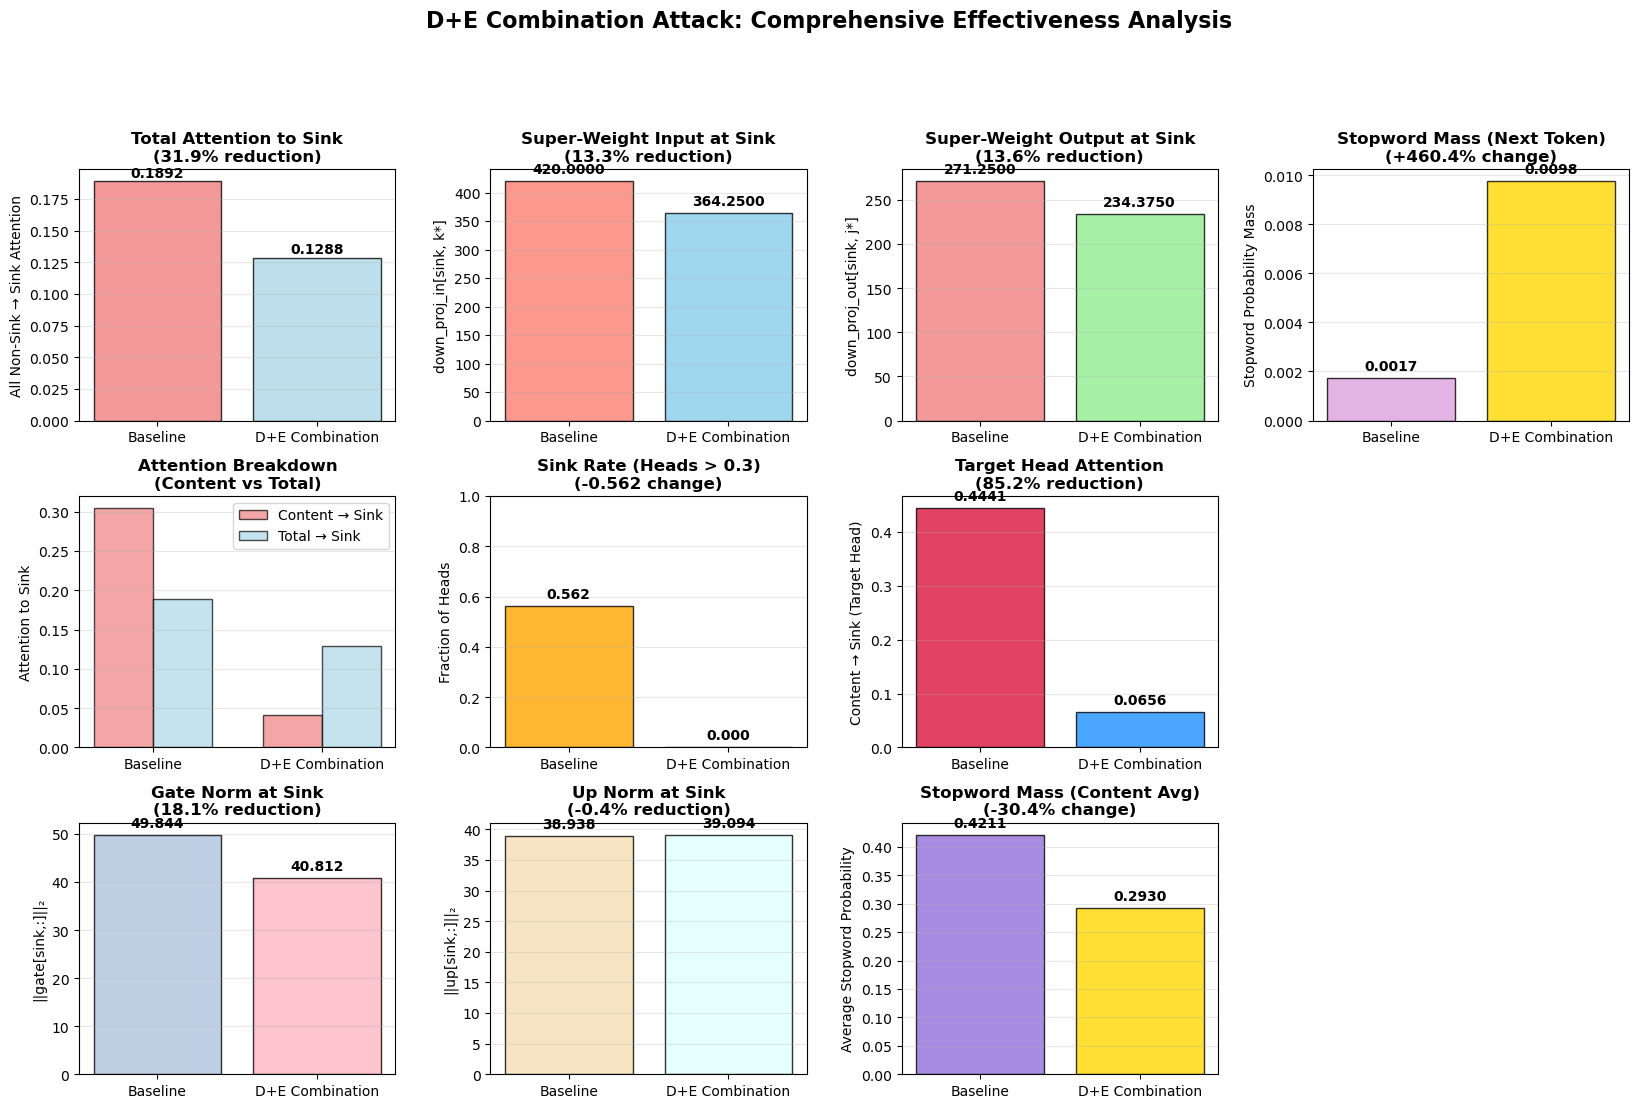


D+E COMBINATION ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: 31.94%
   Super-Weight Input Suppression: 13.27%
   Super-Weight Output Suppression: 13.59%
   Stopword Mass Change: +460.35%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.5625
   Gate Norm Reduction: 18.12%
   Up Norm Reduction: -0.40%


In [55]:
# Comprehensive visualization for Combination D+E
plot_comprehensive_attack_analysis(
    baseline_metrics=metrics_baseline_combo2,
    attack_metrics=metrics_combo2,
    attack_name='D+E Combination',
    attacker=attacker_combo2,
    prompt_text=prompt_text,
    adv_text=adv_text_combo2
)

### A + E (activation suppression + tiny attention reduction)

In [56]:
set_all_seeds(42)
session.model.eval()
# Test Combination A+E - Activation suppression with tiny attention reduction
cfg_combo3 = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw),
    hypothesis='A',  # Primary hypothesis (required field)
    loss_weights={
        'A': 1.0,    # Activation suppression
        'E': 0.10    # Tiny attention reduction
    },
    num_steps=100,
    adv_string_init="<bos> ~ <bos> ~ <bos>",
    search_width=256, top_k_search=128, batch_size=128,
    allow_non_ascii=True,
    prompt_text=prompt_text,
    placement='prefix'
)
attacker_combo3 = SuperWeightAttacker(session.model, session.tokenizer, cfg_combo3)
res_combo3 = attacker_combo3.attack()
res_combo3['final_adv_string']

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=['A', 'E'], placement=prefix, steps=100)


Attacking Hypothesis A:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=0.000015, final_adv=' nonland###-aking， What detailsSummary'


' nonland###-aking， What detailsSummary'

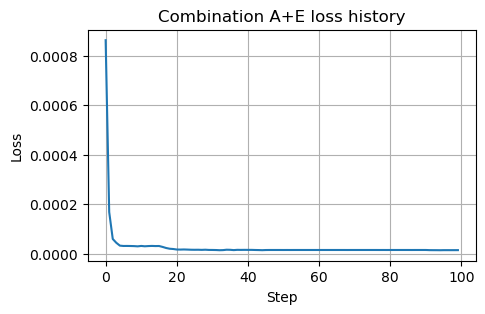

In [57]:
# Plot loss history for Combination A+E
plt.figure(figsize=(5,3))
plt.plot(res_combo3['loss_history'])
plt.title('Combination A+E loss history')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(True); plt.show()

In [58]:
# Evaluate metrics for Combination A+E
adv_text_combo3 = res_combo3['final_adv_string']
metrics_baseline_combo3 = attacker_combo3.eval_metrics(adv_text="")
metrics_combo3 = attacker_combo3.eval_metrics(adv_text=adv_text_combo3)
metrics_baseline_combo3, metrics_combo3

({'content_attn_to_sink_head': 0.0,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.0,
  'content_attn_to_sink_all_heads_mean': 0.304931640625,
  'total_attn_to_sink_all_heads_mean': 0.189208984375,
  'sink_rate': 0.5625,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 420.0,
  'down_proj_out_row_at_sink': 271.25,
  'gate_norm_at_sink': 49.84375,
  'up_norm_at_sink': 38.9375,
  'stopword_mass_next_token': 0.0017414093017578125,
  'stopword_mass_content_mean': 0.421142578125,
  'layout': {'content_start': 0,
   'content_end': 7,
   'adv_start': 7,
   'adv_len': 0,
   'prompt_len': 7,
   'placement': 'prefix',
   'sink_pos': 0,
   'has_bos': False}},
 {'content_attn_to_sink_head': 0.0,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.0,
  'content_attn_to_sink_all_heads_mean': 0.020355224609375,
  'total_attn_to_sink_all_heads_mean': 0.103759765625,
  'sink_rate': 0.0,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 408.5,
  'down_pr

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


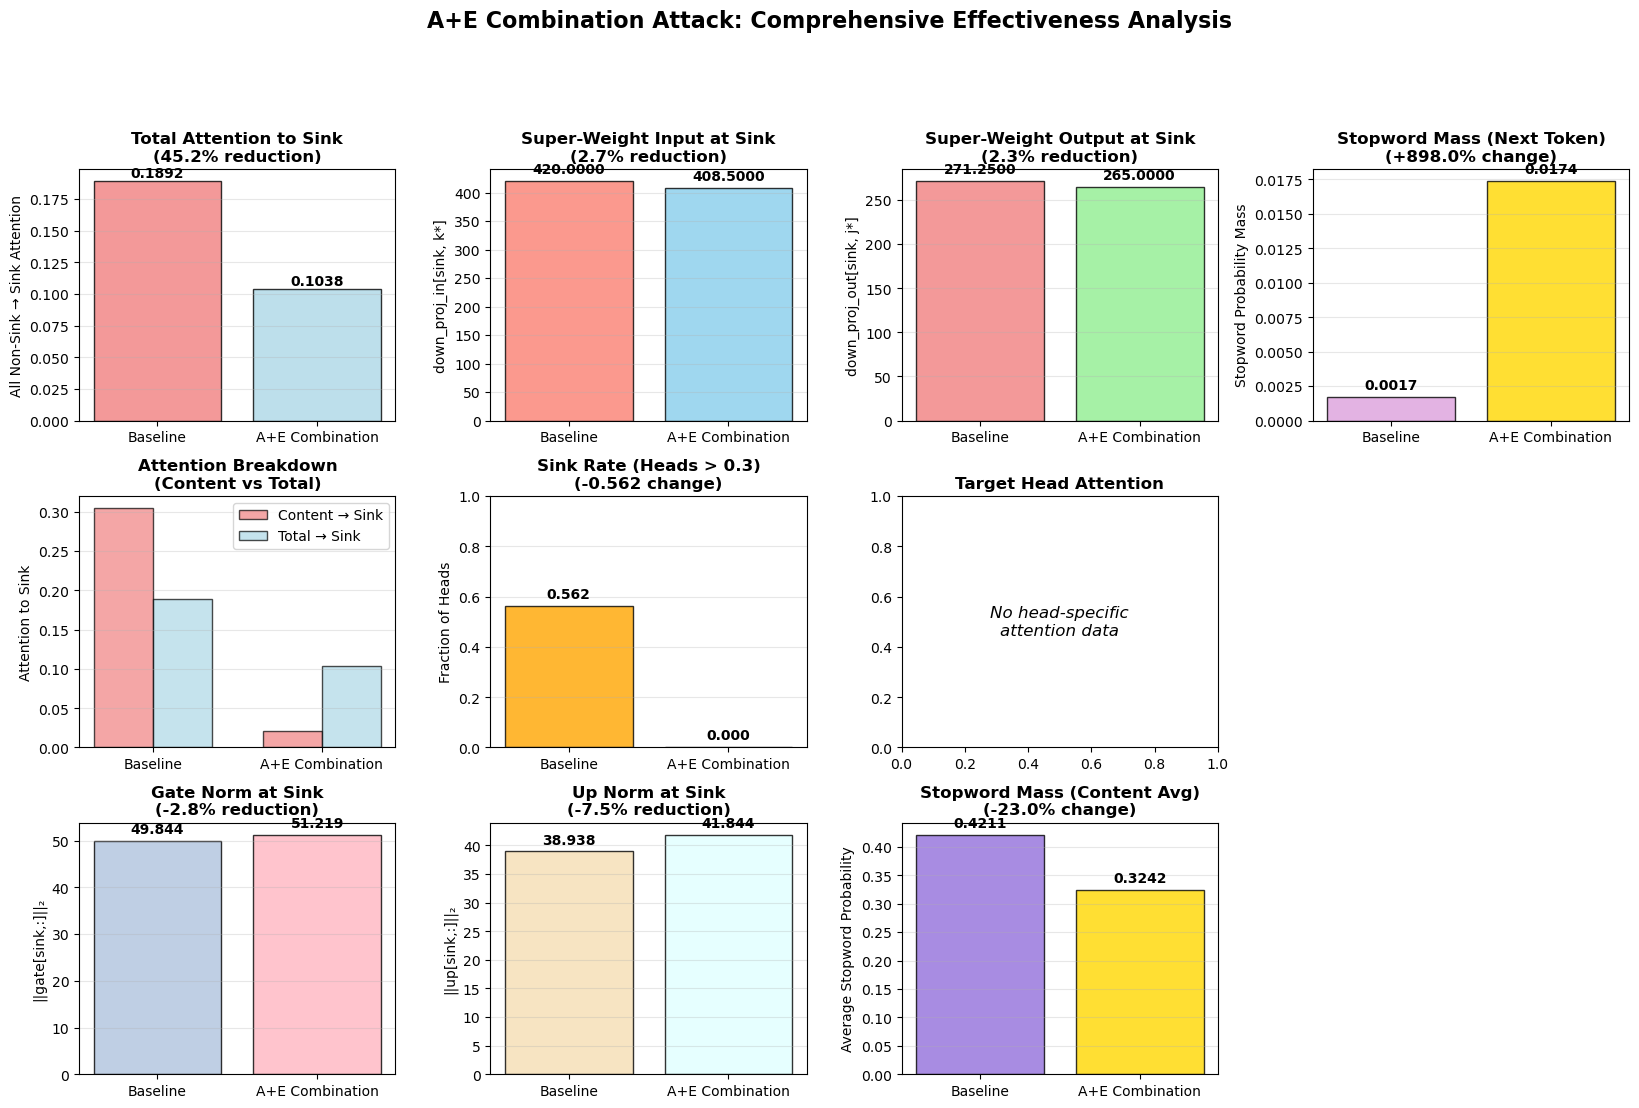


A+E COMBINATION ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: 45.16%
   Super-Weight Input Suppression: 2.74%
   Super-Weight Output Suppression: 2.30%
   Stopword Mass Change: +898.03%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.5625
   Gate Norm Reduction: -2.76%
   Up Norm Reduction: -7.46%


In [59]:
# Comprehensive visualization for Combination A+E
plot_comprehensive_attack_analysis(
    baseline_metrics=metrics_baseline_combo3,
    attack_metrics=metrics_combo3,
    attack_name='A+E Combination',
    attacker=attacker_combo3,
    prompt_text=prompt_text,
    adv_text=adv_text_combo3
)

### D + A + E (weighted D, activation suppression + tiny attention reduction)

In [60]:
set_all_seeds(42)
session.model.eval()
# Test Combination D+A+E (Alternative) - Weighted D with activation suppression and tiny attention reduction
cfg_combo4 = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw),
    hypothesis='D',  # Primary hypothesis (required field)
    loss_weights={
        'D': 1.0,    # Weighted head reduction 
        'A': 0.2,    # Activation suppression
        'E': 0.1     # Attention reduction
    },
    head_reduction="weighted",  # For Hypothesis D
    tau=2.0,
    num_steps=100,
    adv_string_init="<bos> ~ <bos> ~ <bos>",
    search_width=256, top_k_search=128, batch_size=128,
    allow_non_ascii=True,
    prompt_text=prompt_text,
    placement='prefix'
)
attacker_combo4 = SuperWeightAttacker(session.model, session.tokenizer, cfg_combo4)
res_combo4 = attacker_combo4.attack()
res_combo4['final_adv_string']

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: No head_idx provided for hypothesis D - auto-selecting best head
[INFO] super_weights.attack: Selected attention-based head 10 (layer 1) with sink score 2.1094 (has_bos=False)
[INFO] super_weights.attack: Auto-selected head 10 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Starting GCG attack (has_bos=False, hypotheses=['D', 'A', 'E'], placement=prefix, steps=100)


HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0


Attacking Hypothesis D:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Attack finished. final_loss=-0.100952, final_adv=' eyeb produ('¾的的的� merchand”).
'


" eyeb produ('¾的的的� merchand”).\n"

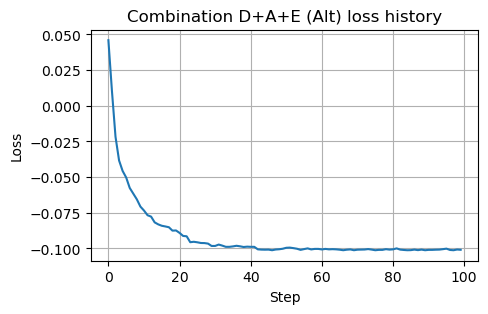

In [61]:
# Plot loss history for Combination D+A+E (Alternative)
plt.figure(figsize=(5,3))
plt.plot(res_combo4['loss_history'])
plt.title('Combination D+A+E (Alt) loss history')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(True); plt.show()

In [62]:
# Evaluate metrics for Combination D+A+E (Alternative)
adv_text_combo4 = res_combo4['final_adv_string']
metrics_baseline_combo4 = attacker_combo4.eval_metrics(adv_text="")
metrics_combo4 = attacker_combo4.eval_metrics(adv_text=adv_text_combo4)
metrics_baseline_combo4, metrics_combo4

({'content_attn_to_sink_head': 0.444091796875,
  'adv_attn_to_sink_head': 0.0,
  'total_attn_to_sink_head': 0.3515625,
  'content_attn_to_sink_all_heads_mean': 0.304931640625,
  'total_attn_to_sink_all_heads_mean': 0.189208984375,
  'sink_rate': 0.5625,
  'attn_entropy_content': nan,
  'down_proj_in_col_at_sink': 420.0,
  'down_proj_out_row_at_sink': 271.25,
  'gate_norm_at_sink': 49.84375,
  'up_norm_at_sink': 38.9375,
  'stopword_mass_next_token': 0.0017414093017578125,
  'stopword_mass_content_mean': 0.421142578125,
  'layout': {'content_start': 0,
   'content_end': 7,
   'adv_start': 7,
   'adv_len': 0,
   'prompt_len': 7,
   'placement': 'prefix',
   'sink_pos': 0,
   'has_bos': False}},
 {'content_attn_to_sink_head': 0.01910400390625,
  'adv_attn_to_sink_head': 0.2086181640625,
  'total_attn_to_sink_head': 0.08404541015625,
  'content_attn_to_sink_all_heads_mean': 0.016082763671875,
  'total_attn_to_sink_all_heads_mean': 0.091796875,
  'sink_rate': 0.0,
  'attn_entropy_content': 

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/2314699551.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


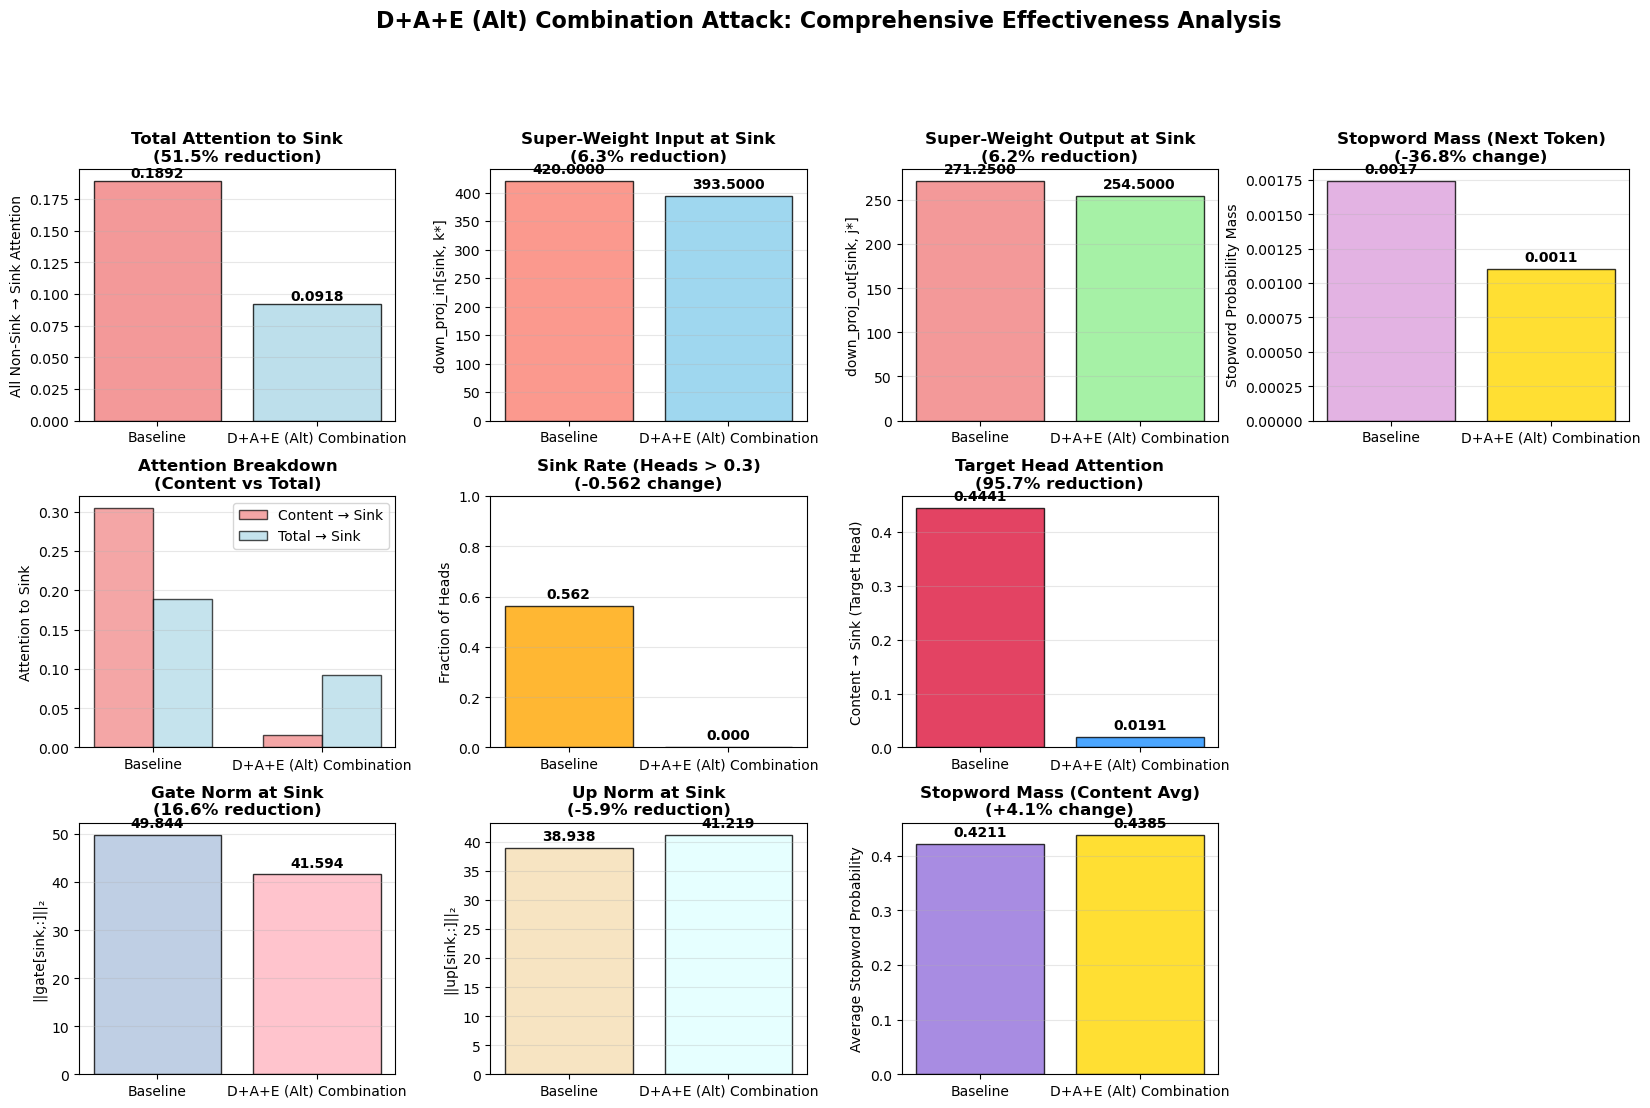


D+A+E (ALT) COMBINATION ATTACK EFFECTIVENESS REPORT
🎯 PRIMARY METRICS:
   Total Attention Reduction: 51.48%
   Super-Weight Input Suppression: 6.31%
   Super-Weight Output Suppression: 6.18%
   Stopword Mass Change: -36.80%

📊 SECONDARY METRICS:
   Sink Rate Change: -0.5625
   Gate Norm Reduction: 16.55%
   Up Norm Reduction: -5.86%


In [63]:
# Comprehensive visualization for Combination D+A+E (Alternative)
plot_comprehensive_attack_analysis(
    baseline_metrics=metrics_baseline_combo4,
    attack_metrics=metrics_combo4,
    attack_name='D+A+E (Alt) Combination',
    attacker=attacker_combo4,
    prompt_text=prompt_text,
    adv_text=adv_text_combo4
)

# Testing multiple Prompts
Above, we only optimized an adversarial string over a single prompt. Now, we will test the attack with multiple prompts to evaluate its robustness and generalization capabilities.

In [64]:
from typing import Dict

def plot_multi_prompt_analysis(multi_results: Dict, baseline_multi_metrics: Dict, attack_multi_metrics: Dict):
    """Comprehensive visualization for multi-prompt attack results."""
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # 1. Loss history
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(multi_results['loss_history'], linewidth=2, color='blue')
    ax1.set_title('Multi-Prompt Loss History', fontweight='bold')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Average Loss')
    ax1.grid(True, alpha=0.3)
    
    # 2. Per-prompt loss evolution
    ax2 = fig.add_subplot(gs[0, 1])
    for prompt_idx, losses in multi_results['per_prompt_losses'].items():
        if losses:  # Only plot if we have data
            steps = np.arange(0, len(multi_results['loss_history']), 10)[:len(losses)]
            ax2.plot(steps, losses, label=f'Prompt {prompt_idx}', alpha=0.7)
    ax2.set_title('Per-Prompt Loss Evolution', fontweight='bold')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Loss')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # 3. Aggregate attention reduction
    ax3 = fig.add_subplot(gs[0, 2])
    baseline_mean = baseline_multi_metrics['aggregate']['total_attn_to_sink_all_heads_mean_mean']
    attack_mean = attack_multi_metrics['aggregate']['total_attn_to_sink_all_heads_mean_mean']
    reduction_pct = ((baseline_mean - attack_mean) / baseline_mean * 100) if baseline_mean != 0 else 0
    
    bars = ax3.bar(['Baseline', 'Attack'], [baseline_mean, attack_mean],
                  color=['lightcoral', 'lightblue'], edgecolor='black', alpha=0.8)
    ax3.set_title(f'Avg Total Attention to Sink\n({reduction_pct:.1f}% reduction)', fontweight='bold')
    ax3.set_ylabel('Attention (Mean across prompts)')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add error bars
    baseline_std = baseline_multi_metrics['aggregate']['total_attn_to_sink_all_heads_mean_std']
    attack_std = attack_multi_metrics['aggregate']['total_attn_to_sink_all_heads_mean_std']
    ax3.errorbar(['Baseline', 'Attack'], [baseline_mean, attack_mean], 
                yerr=[baseline_std, attack_std], fmt='none', color='black', capsize=5)
    
    # 4. Per-prompt attention comparison
    ax4 = fig.add_subplot(gs[0, 3])
    prompt_indices = range(len(baseline_multi_metrics['per_prompt']))
    baseline_attns = [m['total_attn_to_sink_all_heads_mean'] for m in baseline_multi_metrics['per_prompt']]
    attack_attns = [m['total_attn_to_sink_all_heads_mean'] for m in attack_multi_metrics['per_prompt']]
    
    x = np.arange(len(prompt_indices))
    width = 0.35
    ax4.bar(x - width/2, baseline_attns, width, label='Baseline', alpha=0.7)
    ax4.bar(x + width/2, attack_attns, width, label='Attack', alpha=0.7)
    ax4.set_title('Per-Prompt Attention Comparison', fontweight='bold')
    ax4.set_xlabel('Prompt Index')
    ax4.set_ylabel('Total Attention to Sink')
    ax4.set_xticks(x)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    # 5. Super-weight input/output metrics
    ax5 = fig.add_subplot(gs[1, 0])
    sw_metrics = ['down_proj_in_col_at_sink_mean', 'down_proj_out_row_at_sink_mean']
    sw_labels = ['SW Input', 'SW Output']
    baseline_vals = [baseline_multi_metrics['aggregate'][k] for k in sw_metrics]
    attack_vals = [attack_multi_metrics['aggregate'][k] for k in sw_metrics]
    
    x = np.arange(len(sw_labels))
    ax5.bar(x - 0.2, baseline_vals, 0.4, label='Baseline', alpha=0.7)
    ax5.bar(x + 0.2, attack_vals, 0.4, label='Attack', alpha=0.7)
    ax5.set_title('Super-Weight Metrics (Avg)', fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(sw_labels)
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)
    
    # 6. Sink rate and entropy
    ax6 = fig.add_subplot(gs[1, 1])
    behavioral_metrics = ['sink_rate_mean', 'attn_entropy_content_mean']
    behavioral_labels = ['Sink Rate', 'Attention Entropy']
    baseline_behav = [baseline_multi_metrics['aggregate'][k] for k in behavioral_metrics]
    attack_behav = [attack_multi_metrics['aggregate'][k] for k in behavioral_metrics]
    
    # Normalize for comparison (since scales are different)
    baseline_norm = [v / baseline_behav[i] for i, v in enumerate(baseline_behav)]
    attack_norm = [v / baseline_behav[i] for i, v in enumerate(attack_behav)]
    
    x = np.arange(len(behavioral_labels))
    ax6.bar(x - 0.2, baseline_norm, 0.4, label='Baseline (normalized)', alpha=0.7)
    ax6.bar(x + 0.2, attack_norm, 0.4, label='Attack (normalized)', alpha=0.7)
    ax6.set_title('Behavioral Metrics (Normalized)', fontweight='bold')
    ax6.set_xticks(x)
    ax6.set_xticklabels(behavioral_labels)
    ax6.legend()
    ax6.grid(axis='y', alpha=0.3)
    
    # 7. Variation across prompts (box plot)
    ax7 = fig.add_subplot(gs[1, 2:])
    baseline_variations = [m['total_attn_to_sink_all_heads_mean'] for m in baseline_multi_metrics['per_prompt']]
    attack_variations = [m['total_attn_to_sink_all_heads_mean'] for m in attack_multi_metrics['per_prompt']]
    
    ax7.boxplot([baseline_variations, attack_variations], labels=['Baseline', 'Attack'])
    ax7.set_title('Attention Reduction Variation Across Prompts', fontweight='bold')
    ax7.set_ylabel('Total Attention to Sink')
    ax7.grid(axis='y', alpha=0.3)
    
    plt.suptitle('Multi-Prompt Attack Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    print(f"\n{'='*80}")
    print("MULTI-PROMPT ATTACK DETAILED RESULTS")
    print(f"{'='*80}")
    print(f"Number of prompts: {len(multi_results['prompt_texts'])}")
    print(f"Final adversarial string: '{multi_results['final_adv_string']}'")
    print(f"Average final loss: {multi_results['final_loss']:.6f}")
    print(f"Total attention reduction: {reduction_pct:.2f}%")
    print(f"{'='*80}")

## MultiPrompt attack with Hypothesis A

In [65]:
from attack.attack import MultiPromptSuperWeightAttacker

In [66]:
# Multi-prompt attack test with Hypothesis A
# Define your list of prompts
multi_prompts = [
    "What is the capital of Germany?",
    "Apple Inc. is a tech company.",
    "The quick brown fox jumps over the lazy dog.",
    "Climate change affects global weather patterns.",
    "Artificial intelligence transforms modern computing.",
    "Microsoft Corporation develops software solutions.",
    "In the morning, coffee tastes best with breakfast.",
    "Economic indicators suggest potential market volatility ahead.",
    "After finishing work, she decided to read a book.",
    "Before starting the meeting, everyone should review the agenda."
]

set_all_seeds(42)
session.model.eval()
# Configuration for multi-prompt Hypothesis A attack
cfg_A_multi = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw),
    hypothesis='A',
    num_steps=150,  # More steps since we're optimizing over multiple prompts
    adv_string_init="<bos> ~ <bos> ~ <bos>",
    search_width=256, 
    top_k_search=128, 
    batch_size=64,  # Smaller batch size to handle memory
    allow_non_ascii=True,
    prompt_text=multi_prompts[0],  # First prompt used for initialization
    placement='prefix'
)

# Create multi-prompt attacker
multi_attacker_A = MultiPromptSuperWeightAttacker(
    session.model, 
    session.tokenizer, 
    cfg_A_multi, 
    multi_prompts
)

print(f"Starting multi-prompt attack with {len(multi_prompts)} prompts...")
multi_results_A = multi_attacker_A.attack_multi_prompt()

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Multi-prompt attacker initialized with 10 prompts
[INFO] super_weights.attack: Starting multi-prompt GCG attack (has_bos=False, hypothesis=A, placement=prefix, steps=150)
[INFO] super_weights.attack: Optimizing over 10 prompts


Starting multi-prompt attack with 10 prompts...


Multi-Prompt Attack Hypothesis A:   0%|          | 0/150 [00:00<?, ?it/s]

[INFO] super_weights.attack: Early stopping at step 21 - no improvement for 20 steps
[INFO] super_weights.attack: Multi-prompt attack finished. final_avg_loss=0.143555, final_adv='(�b`"h@�73t'


Evaluating baseline metrics...
Evaluating attack metrics...
Creating comprehensive visualization...


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax7.boxplot([baseline_variations, attack_variations], labels=['Baseline', 'Attack'])
/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


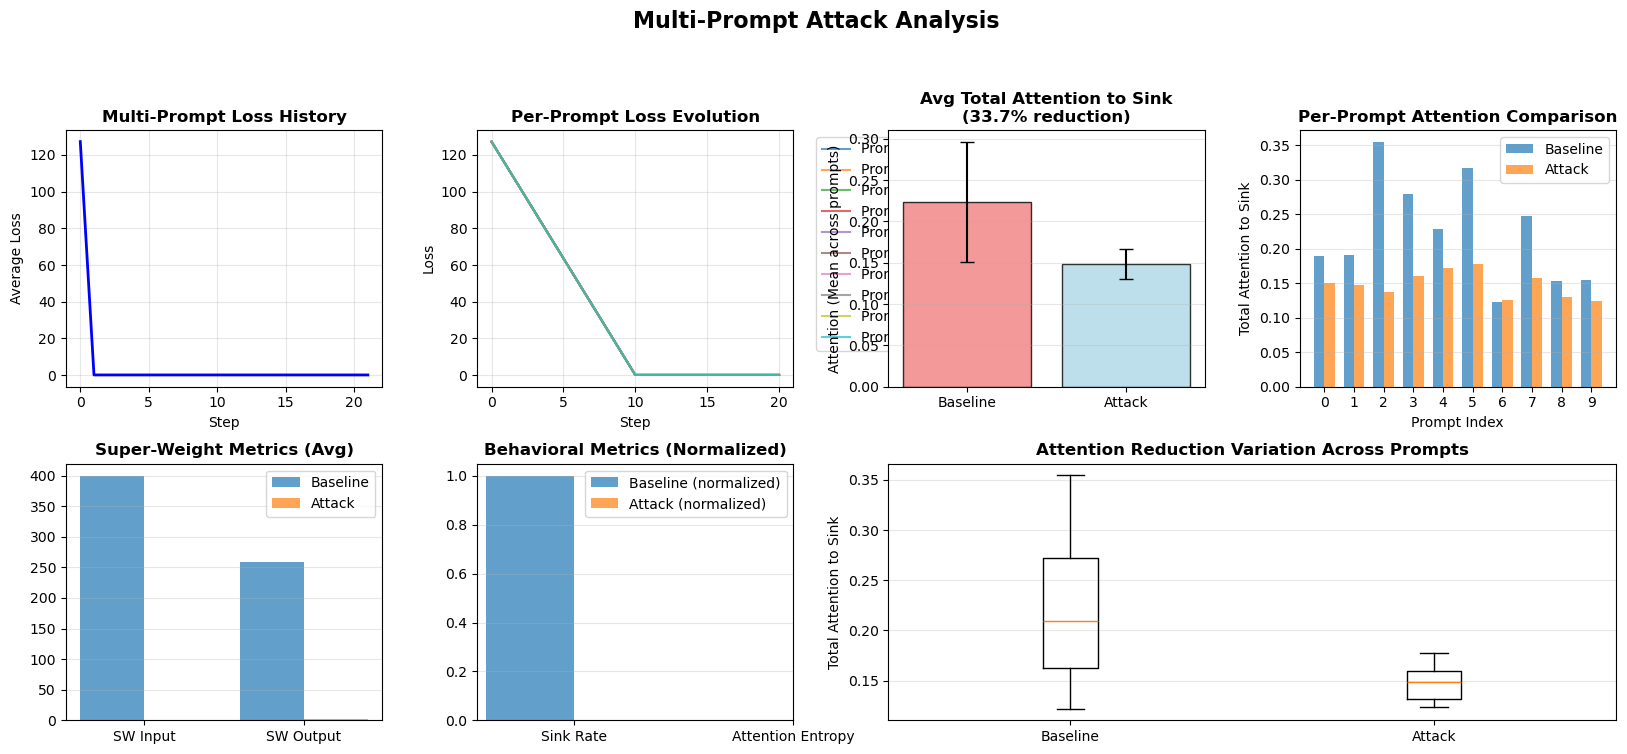


MULTI-PROMPT ATTACK DETAILED RESULTS
Number of prompts: 10
Final adversarial string: '(�b`"h@�73t'
Average final loss: 0.143555
Total attention reduction: 33.70%


In [67]:
# Evaluate multi-prompt attack effectiveness
print("Evaluating baseline metrics...")
baseline_multi_metrics_A = multi_attacker_A.eval_metrics_multi_prompt(adv_text="")

print("Evaluating attack metrics...")
attack_multi_metrics_A = multi_attacker_A.eval_metrics_multi_prompt(adv_text=multi_results_A['final_adv_string'])

print("Creating comprehensive visualization...")
plot_multi_prompt_analysis(multi_results_A, baseline_multi_metrics_A, attack_multi_metrics_A)

In [68]:
metrics_to_check = (
    'down_proj_in_col_at_sink',
    'down_proj_out_row_at_sink',
)

heldout_results = run_multi_seed_consistency_evaluation(
    session=session,
    attacker=multi_attacker_A,
    adv_string=multi_results_A['final_adv_string'],
    seeds=[41, 42, 43],
    n_prompts=100,
    min_tokens=6,
    max_tokens=40,
    metrics_of_interest=metrics_to_check,
    thresholds={
        'min_median_reduction': 20.0,       # 20%
        'min_p10_reduction': 10.0,          # 10%
        'median_variation_tolerance': 5.0   # +-5%
    },
    show_progress=True,
    set_all_seeds_fn=set_all_seeds
)

=== Multi-seed held-out evaluation ===
Seeds: [41, 42, 43]
Metrics: ('down_proj_in_col_at_sink', 'down_proj_out_row_at_sink')
Thresholds: {'min_median_reduction': 20.0, 'min_p10_reduction': 10.0, 'median_variation_tolerance': 5.0}
-------------------------------------

[Seed 41] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 99.96% (p10=99.96%, p90=99.97%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 99.20% (p10=99.14%, p90=99.23%) n_valid=100/100

[Seed 42] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 99.96% (p10=99.96%, p90=99.97%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 99.20% (p10=99.14%, p90=99.23%) n_valid=100/100

[Seed 43] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 99.96% (p10=99.96%, p90=99.97%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 99.20% (p10=99.14%, p90=99.23%) n_valid=100/100

=== PASS/FAIL SUMMARY ===
Metric: down_proj_in_col_at_sink
  Seed medians: ['99.96', '99.96', '99.96']
  Mean median: 99.96% | Max abs dev: 0.00%
  Min median observed: 99.96% (threshold 20.00%) -> pass=True
  Min p10 observed: 99.96% (threshold 10.00%) -> pass=True
  Stability pass (≤ 5.00%): True
  METRIC PASS: True
Metric: down_proj_out_row_at_sink
  Seed medians: ['99.20', '99.20', '99.20']
  Mean median: 99.20% | Max abs dev: 0.00%
  Min median observed: 99.20% (threshold 20.00%) -> pass=True
  Min p10 observed: 99.14% (threshold 10.00%) -> pass=True
  Stability pass (≤ 5.00%): True
  METRIC PASS: True

OVERALL PASS: True


## MultiPrompt Attack with Hypothesis C

In [69]:
# Multi-prompt attack test with Hypothesis C
# Configuration for multi-prompt Hypothesis C attack
cfg_C_multi = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw),
    hypothesis='C',
    num_steps=150,  # More steps since we're optimizing over multiple prompts
    adv_string_init="<bos> ~ <bos> ~ <bos>",
    search_width=256, 
    top_k_search=128, 
    batch_size=64,  # Smaller batch size to handle memory
    allow_non_ascii=True,
    prompt_text=multi_prompts[0],  # First prompt used for initialization
    placement='prefix'
)

# Create multi-prompt attacker
multi_attacker_C = MultiPromptSuperWeightAttacker(
    session.model, 
    session.tokenizer, 
    cfg_C_multi, 
    multi_prompts
)

print(f"Starting multi-prompt attack with {len(multi_prompts)} prompts...")
multi_results_C = multi_attacker_C.attack_multi_prompt()

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Multi-prompt attacker initialized with 10 prompts
[INFO] super_weights.attack: Starting multi-prompt GCG attack (has_bos=False, hypothesis=C, placement=prefix, steps=150)
[INFO] super_weights.attack: Optimizing over 10 prompts


Starting multi-prompt attack with 10 prompts...


Multi-Prompt Attack Hypothesis C:   0%|          | 0/150 [00:00<?, ?it/s]

[INFO] super_weights.attack: Early stopping at step 33 - no improvement for 20 steps
[INFO] super_weights.attack: Multi-prompt attack finished. final_avg_loss=26.390625, final_adv='(I�d����d�a'


Evaluating baseline metrics...
Evaluating attack metrics...
Creating comprehensive visualization...


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax7.boxplot([baseline_variations, attack_variations], labels=['Baseline', 'Attack'])
/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


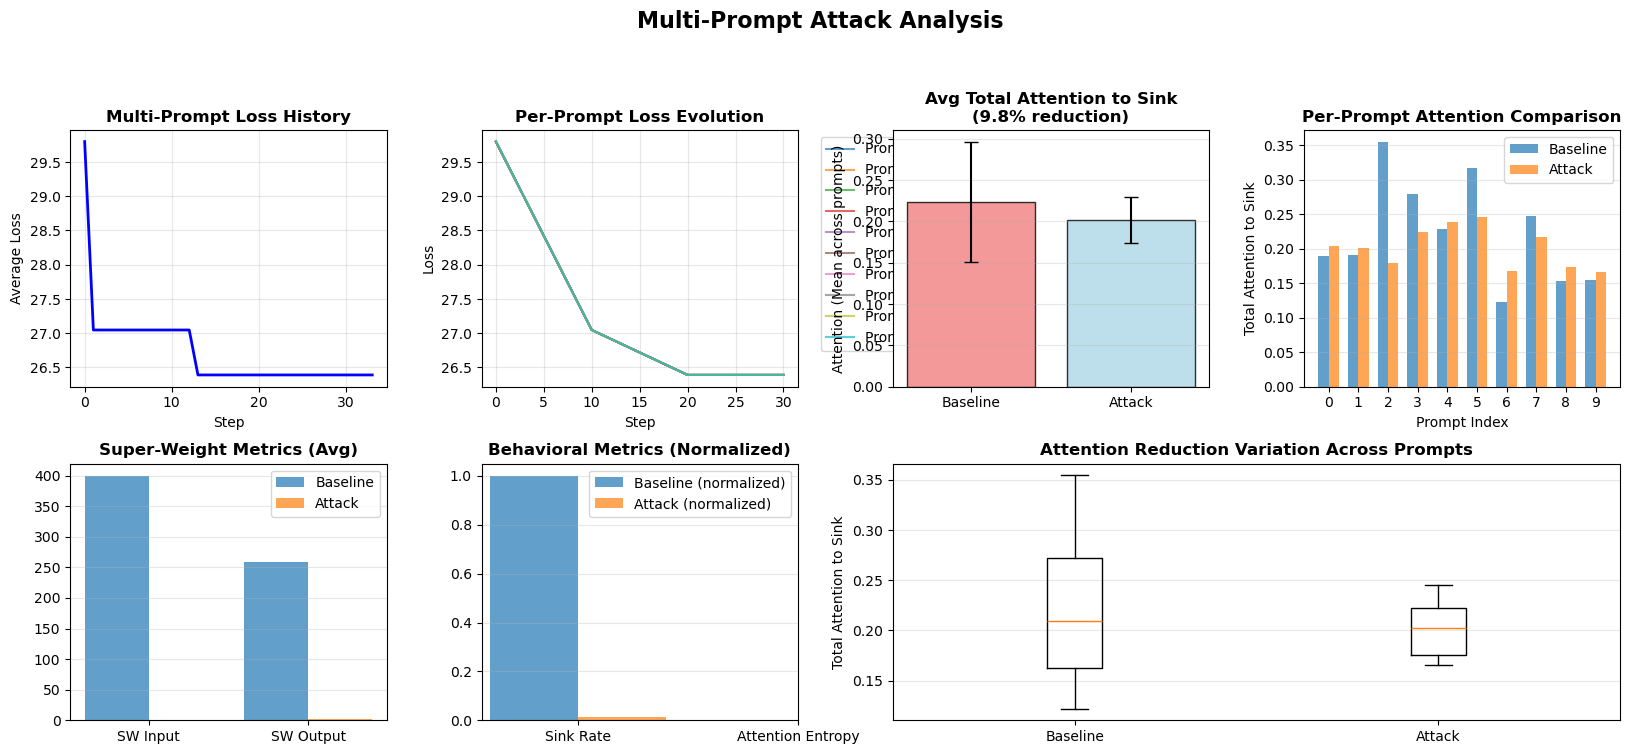


MULTI-PROMPT ATTACK DETAILED RESULTS
Number of prompts: 10
Final adversarial string: '(I�d����d�a'
Average final loss: 26.390625
Total attention reduction: 9.82%


In [70]:
# Evaluate multi-prompt attack effectiveness
print("Evaluating baseline metrics...")
baseline_multi_metrics_C = multi_attacker_C.eval_metrics_multi_prompt(adv_text="")

print("Evaluating attack metrics...")
attack_multi_metrics_C = multi_attacker_C.eval_metrics_multi_prompt(adv_text=multi_results_C['final_adv_string'])

print("Creating comprehensive visualization...")
plot_multi_prompt_analysis(multi_results_C, baseline_multi_metrics_C, attack_multi_metrics_C)

In [71]:
metrics_to_check = (
    'down_proj_in_col_at_sink',
    'down_proj_out_row_at_sink',
)

heldout_results = run_multi_seed_consistency_evaluation(
    session=session,
    attacker=multi_attacker_C,
    adv_string=multi_results_C['final_adv_string'],
    seeds=[41, 42, 43],
    n_prompts=100,
    min_tokens=6,
    max_tokens=40,
    metrics_of_interest=metrics_to_check,
    thresholds={
        'min_median_reduction': 20.0,       # 20%
        'min_p10_reduction': 10.0,          # 10%
        'median_variation_tolerance': 5.0   # +-5%
    },
    show_progress=True,
    set_all_seeds_fn=set_all_seeds
)

=== Multi-seed held-out evaluation ===
Seeds: [41, 42, 43]
Metrics: ('down_proj_in_col_at_sink', 'down_proj_out_row_at_sink')
Thresholds: {'min_median_reduction': 20.0, 'min_p10_reduction': 10.0, 'median_variation_tolerance': 5.0}
-------------------------------------

[Seed 41] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 99.96% (p10=99.96%, p90=99.97%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 99.20% (p10=99.14%, p90=99.23%) n_valid=100/100

[Seed 42] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 99.96% (p10=99.96%, p90=99.97%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 99.20% (p10=99.14%, p90=99.23%) n_valid=100/100

[Seed 43] Running held-out evaluation...


Evaluating prompts (baseline):   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating prompts (adv):   0%|          | 0/100 [00:00<?, ?it/s]

  Metric: down_proj_in_col_at_sink
    Median reduction: 99.96% (p10=99.96%, p90=99.97%) n_valid=100/100
  Metric: down_proj_out_row_at_sink
    Median reduction: 99.20% (p10=99.14%, p90=99.23%) n_valid=100/100

=== PASS/FAIL SUMMARY ===
Metric: down_proj_in_col_at_sink
  Seed medians: ['99.96', '99.96', '99.96']
  Mean median: 99.96% | Max abs dev: 0.00%
  Min median observed: 99.96% (threshold 20.00%) -> pass=True
  Min p10 observed: 99.96% (threshold 10.00%) -> pass=True
  Stability pass (≤ 5.00%): True
  METRIC PASS: True
Metric: down_proj_out_row_at_sink
  Seed medians: ['99.20', '99.20', '99.20']
  Mean median: 99.20% | Max abs dev: 0.00%
  Min median observed: 99.20% (threshold 20.00%) -> pass=True
  Min p10 observed: 99.14% (threshold 10.00%) -> pass=True
  Stability pass (≤ 5.00%): True
  METRIC PASS: True

OVERALL PASS: True


## MultiPrompt attack with Hypothesis D

In [72]:
# Multi-prompt attack test with Hypothesis D
# Define your list of prompts
multi_prompts = [
    "What is the capital of Germany?",
    "Apple Inc. is a tech company.",
    "The quick brown fox jumps over the lazy dog.",
    "Climate change affects global weather patterns.",
    "Artificial intelligence transforms modern computing.",
    "Microsoft Corporation develops software solutions.",
    "In the morning, coffee tastes best with breakfast.",
    "Economic indicators suggest potential market volatility ahead.",
    "After finishing work, she decided to read a book.",
    "Before starting the meeting, everyone should review the agenda."
]

# Configuration for multi-prompt Hypothesis D attack
cfg_D_multi = SuperWeightAttackConfig(
    target=SuperWeightTarget(super_weight=target_sw, head_idx=head_D),
    hypothesis='D',
    num_steps=150,  # More steps since we're optimizing over multiple prompts
    adv_string_init="<bos> ~ <bos> ~ <bos>",
    search_width=256, 
    top_k_search=128, 
    batch_size=64,  # Smaller batch size to handle memory
    allow_non_ascii=True,
    prompt_text=multi_prompts[0],  # First prompt used for initialization
    placement='prefix',
    # Hypothesis D specific parameters
    target_all_content_tokens=True,
    head_reduction="weighted",  # Use weighted head reduction for better multi-prompt performance
    tau=2.0
)

# Add early stopping parameters
cfg_D_multi.early_stopping_patience = 20
cfg_D_multi.min_improvement = 1e-6

# Create multi-prompt attacker
multi_attacker_D = MultiPromptSuperWeightAttacker(
    session.model, 
    session.tokenizer, 
    cfg_D_multi, 
    multi_prompts
)

print(f"Starting multi-prompt Hypothesis D attack with {len(multi_prompts)} prompts...")
multi_results_D = multi_attacker_D.attack_multi_prompt()

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Multi-prompt attacker initialized with 10 prompts
[INFO] super_weights.attack: Starting multi-prompt GCG attack (has_bos=False, hypothesis=D, placement=prefix, steps=150)
[INFO] super_weights.attack: Optimizing over 10 prompts


HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0
Starting multi-prompt Hypothesis D attack with 10 prompts...


Multi-Prompt Attack Hypothesis D:   0%|          | 0/150 [00:00<?, ?it/s]

[INFO] super_weights.attack: Early stopping at step 105 - no improvement for 20 steps
[INFO] super_weights.attack: Multi-prompt attack finished. final_avg_loss=-0.107788, final_adv=' privsusp genu pleth                    ¾的 east� THE?”'


Evaluating baseline metrics...
Evaluating attack metrics...
Creating comprehensive visualization...


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax7.boxplot([baseline_variations, attack_variations], labels=['Baseline', 'Attack'])
/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


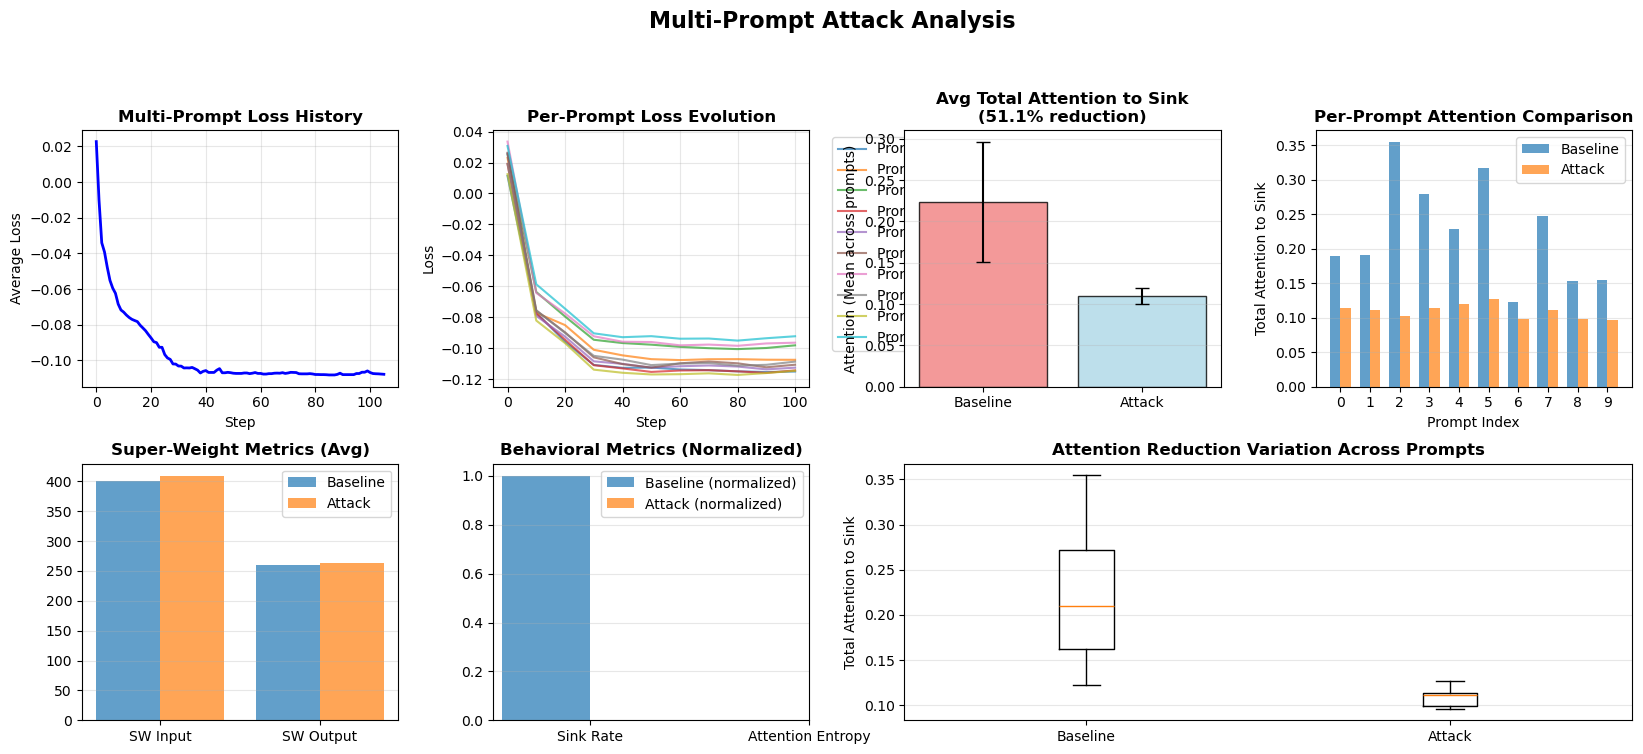


MULTI-PROMPT ATTACK DETAILED RESULTS
Number of prompts: 10
Final adversarial string: ' privsusp genu pleth                    ¾的 east� THE?”'
Average final loss: -0.107788
Total attention reduction: 51.14%


In [73]:
# Evaluate multi-prompt Hypothesis D attack effectiveness
print("Evaluating baseline metrics...")
baseline_multi_metrics_D = multi_attacker_D.eval_metrics_multi_prompt(adv_text="")

print("Evaluating attack metrics...")
attack_multi_metrics_D = multi_attacker_D.eval_metrics_multi_prompt(adv_text=multi_results_D['final_adv_string'])

print("Creating comprehensive visualization...")
plot_multi_prompt_analysis(multi_results_D, baseline_multi_metrics_D, attack_multi_metrics_D)

In [74]:
# Compare single vs multi-prompt Hypothesis D results
print("\n" + "="*60)
print("SINGLE vs MULTI-PROMPT HYPOTHESIS D COMPARISON")
print("="*60)

# Get the best single-prompt D result from your earlier experiments
# (assuming you ran the comprehensive head reduction test and 'weighted' was one of them)
if 'attack_results' in locals() and 'weighted' in attack_results:
    single_D_result = attack_results['weighted']
    single_adv_D = single_D_result['attack_result']['final_adv_string']
    single_metrics_D = single_D_result['attack_metrics']
else:
    # Fallback: run a quick single-prompt attack for comparison
    print("Running single-prompt Hypothesis D for comparison...")
    cfg_D_single = SuperWeightAttackConfig(
        target=SuperWeightTarget(super_weight=target_sw, head_idx=head_D),
        hypothesis='D',
        num_steps=100,
        adv_string_init="<bos> ~ <bos> ~ <bos>",
        search_width=256, top_k_search=128, batch_size=128,
        allow_non_ascii=True,
        prompt_text=multi_prompts[0],  # Same first prompt
        placement='prefix',
        target_all_content_tokens=True,
        head_reduction="weighted",
        tau=2.0
    )
    
    single_attacker_D = SuperWeightAttacker(session.model, session.tokenizer, cfg_D_single)
    single_results_D = single_attacker_D.attack()
    single_adv_D = single_results_D['final_adv_string']
    single_metrics_D = single_attacker_D.eval_metrics(adv_text=single_adv_D)

# Compare results
print(f"Single-prompt adversarial string: '{single_adv_D}'")
print(f"Multi-prompt adversarial string:  '{multi_results_D['final_adv_string']}'")
print(f"Single-prompt final loss: {single_results_D['final_loss'] if 'single_results_D' in locals() else 'N/A'}")
print(f"Multi-prompt final loss:  {multi_results_D['final_loss']:.6f}")

# Test both strings on all prompts to see generalization
print(f"\n{'Prompt':<50} {'Single-Prompt Attn':<20} {'Multi-Prompt Attn':<20} {'Improvement':<15}")
print("-" * 105)

for i, prompt in enumerate(multi_prompts):
    # Test single-prompt string on this prompt
    temp_config = SuperWeightAttackConfig(
        target=SuperWeightTarget(super_weight=target_sw, head_idx=head_D),
        hypothesis='D',
        num_steps=1,  # Just for evaluation
        adv_string_init="dummy",
        prompt_text=prompt,
        placement='prefix',
        target_all_content_tokens=True,
        head_reduction="weighted",
        tau=2.0
    )
    temp_attacker = SuperWeightAttacker(session.model, session.tokenizer, temp_config)
    
    single_test_metrics = temp_attacker.eval_metrics(adv_text=single_adv_D)
    multi_test_metrics = attack_multi_metrics_D['per_prompt'][i]
    
    single_attn = single_test_metrics['total_attn_to_sink_all_heads_mean']
    multi_attn = multi_test_metrics['total_attn_to_sink_all_heads_mean']
    improvement = ((single_attn - multi_attn) / single_attn * 100) if single_attn != 0 else 0
    
    print(f"{prompt[:47]+'...' if len(prompt) > 47 else prompt:<50} {single_attn:<20.4f} {multi_attn:<20.4f} {improvement:<15.1f}%")

print("="*105)

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[1:8], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[1:8], adv_start=0, prompt_len=7, adv_len=1



SINGLE vs MULTI-PROMPT HYPOTHESIS D COMPARISON
Single-prompt adversarial string: ' priv appro discipl                     lum� self and cam question THE'
Multi-prompt adversarial string:  ' privsusp genu pleth                    ¾的 east� THE?”'
Single-prompt final loss: N/A
Multi-prompt final loss:  -0.107788

Prompt                                             Single-Prompt Attn   Multi-Prompt Attn    Improvement    
---------------------------------------------------------------------------------------------------------
HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0


[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[1:9], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[1:9], adv_start=0, prompt_len=8, adv_len=1


What is the capital of Germany?                    0.1139               0.1141               -0.2           %
HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0
Apple Inc. is a tech company.                      0.1100               0.1114               -1.2           %


[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[1:11], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[1:11], adv_start=0, prompt_len=10, adv_len=1
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[1:9], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[1:9], adv_start=0, prompt_len=8, adv_len=1


HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0
The quick brown fox jumps over the lazy dog.       0.1011               0.1024               -1.3           %
HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0


[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[1:8], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[1:8], adv_start=0, prompt_len=7, adv_len=1
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[1:7], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[1:7], adv_start=0, prompt_len=6, adv_len=1


Climate change affects global weather patterns.    0.1107               0.1139               -2.9           %
HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0
Artificial intelligence transforms modern compu... 0.1161               0.1199               -3.3           %
HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0


[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[1:11], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[1:11], adv_start=0, prompt_len=10, adv_len=1
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[1:10], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[1:10], adv_start=0, prompt_len=9, adv_len=1


Microsoft Corporation develops software solutio... 0.1224               0.1266               -3.4           %
HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0
In the morning, coffee tastes best with breakfa... 0.0995               0.0984               1.0            %
HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0


[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[1:12], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[1:12], adv_start=0, prompt_len=11, adv_len=1


Economic indicators suggest potential market vo... 0.1071               0.1116               -4.3           %
HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0


[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[1:12], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[1:12], adv_start=0, prompt_len=11, adv_len=1


After finishing work, she decided to read a boo... 0.0967               0.0980               -1.3           %
HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0
Before starting the meeting, everyone should re... 0.0964               0.0964               0.0            %


### Test different head reduction methods for D in multi prompt setting

In [75]:
# Test different head reduction methods for multi-prompt Hypothesis D
print("\n" + "="*60)
print("MULTI-PROMPT HYPOTHESIS D: HEAD REDUCTION METHODS")
print("="*60)

head_reduction_methods = {
    'single': {'head_reduction': 'single', 'description': f'Single head ({head_D})'},
    'mean': {'head_reduction': 'mean', 'description': 'Average all heads'},
    'weighted': {'head_reduction': 'weighted', 'tau': 2.0, 'description': 'Attention-weighted'},
    'topk': {'head_reduction': 'topk', 'top_k_heads': 4, 'tau': 2.0, 'description': 'Top-4 heads'}
}

multi_d_results = {}

for method_name, method_config in head_reduction_methods.items():
    print(f"\nTesting {method_name.upper()} head reduction...")
    
    # Configuration for this method
    cfg = SuperWeightAttackConfig(
        target=SuperWeightTarget(super_weight=target_sw, head_idx=head_D),
        hypothesis='D',
        num_steps=100,  # Shorter for comparison
        adv_string_init="<bos> ~ <bos> ~ <bos>",
        search_width=128, 
        top_k_search=64, 
        batch_size=32,
        allow_non_ascii=True,
        prompt_text=multi_prompts[0],
        placement='prefix',
        target_all_content_tokens=True,
        **{k: v for k, v in method_config.items() if k != 'description'}
    )
    
    # Add early stopping
    cfg.early_stopping_patience = 15
    cfg.min_improvement = 1e-6
    
    # Run multi-prompt attack
    attacker = MultiPromptSuperWeightAttacker(session.model, session.tokenizer, cfg, multi_prompts)
    results = attacker.attack_multi_prompt()
    
    # Evaluate
    baseline_metrics = attacker.eval_metrics_multi_prompt(adv_text="")
    attack_metrics = attacker.eval_metrics_multi_prompt(adv_text=results['final_adv_string'])
    
    multi_d_results[method_name] = {
        'results': results,
        'baseline_metrics': baseline_metrics,
        'attack_metrics': attack_metrics,
        'description': method_config['description']
    }
    
    # Quick summary
    baseline_attn = baseline_metrics['aggregate']['total_attn_to_sink_all_heads_mean_mean']
    attack_attn = attack_metrics['aggregate']['total_attn_to_sink_all_heads_mean_mean']
    reduction_pct = ((baseline_attn - attack_attn) / baseline_attn * 100) if baseline_attn != 0 else 0
    
    print(f"✓ {method_name.upper()}: {reduction_pct:.1f}% attention reduction")
    print(f"  Final adversarial string: '{results['final_adv_string']}'")
    print(f"  Steps completed: {results['steps_completed']}")
    if results.get('early_stopped', False):
        print(f"  (Early stopped)")

[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Multi-prompt attacker initialized with 10 prompts
[INFO] super_weights.attack: Starting multi-prompt GCG attack (has_bos=False, hypothesis=D, placement=prefix, steps=100)
[INFO] super_weights.attack: Optimizing over 10 prompts



MULTI-PROMPT HYPOTHESIS D: HEAD REDUCTION METHODS

Testing SINGLE head reduction...
HypothesisD initialized with head_reduction='single', topk=4, tau=0.5


Multi-Prompt Attack Hypothesis D:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Early stopping at step 43 - no improvement for 15 steps
[INFO] super_weights.attack: Multi-prompt attack finished. final_avg_loss=0.236450, final_adv=Take   https    '
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Multi-prompt attacker initialized with 10 prompts
[INFO] super_weights.attack: Starting multi-prompt GCG attack (has_bos=False, hypothesis=D, placement=prefix, steps=100)
[INFO] super_weights.attack: Optimizing over 10 prompts


✓ SINGLE: 58.6% attention reduction
  Final adversarial string: Take   https    '
  Steps completed: 44
  (Early stopped)

Testing MEAN head reduction...
HypothesisD initialized with head_reduction='mean', topk=4, tau=0.5


Multi-Prompt Attack Hypothesis D:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Early stopping at step 42 - no improvement for 15 steps
[INFO] super_weights.attack: Multi-prompt attack finished. final_avg_loss=-0.062378, final_adv='xxxxxxxxret'
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Multi-prompt attacker initialized with 10 prompts
[INFO] super_weights.attack: Starting multi-prompt GCG attack (has_bos=False, hypothesis=D, placement=prefix, steps=100)
[INFO] super_weights.attack: Optimizing over 10 prompts


✓ MEAN: 74.1% attention reduction
  Final adversarial string: 'xxxxxxxxret'
  Steps completed: 43
  (Early stopped)

Testing WEIGHTED head reduction...
HypothesisD initialized with head_reduction='weighted', topk=4, tau=2.0


Multi-Prompt Attack Hypothesis D:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Early stopping at step 85 - no improvement for 15 steps
[INFO] super_weights.attack: Multi-prompt attack finished. final_avg_loss=-0.123657, final_adv=' Of su
age */�。estialblogger

'
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:18], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Using user-provided head_idx=2 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:18], adv_start=0, prompt_len=7, adv_len=11
[INFO] super_weights.attack: Multi-prompt attacker initialized with 10 prompts
[INFO] super_weights.attack: Starting multi-prompt GCG attack (has_bos=False, hypothesis=D, placement=prefix, steps=100)
[INFO] super_weights.attack: Optimizing over 10 prompts


✓ WEIGHTED: 63.9% attention reduction
  Final adversarial string: ' Of su
age */�。estialblogger

'
  Steps completed: 86
  (Early stopped)

Testing TOPK head reduction...
HypothesisD initialized with head_reduction='topk', topk=4, tau=2.0


Multi-Prompt Attack Hypothesis D:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] super_weights.attack: Early stopping at step 46 - no improvement for 15 steps
[INFO] super_weights.attack: Multi-prompt attack finished. final_avg_loss=0.214478, final_adv=' next caut_ speciallymsEarlyAs percol personal '


✓ TOPK: 58.0% attention reduction
  Final adversarial string: ' next caut_ speciallymsEarlyAs percol personal '
  Steps completed: 47
  (Early stopped)


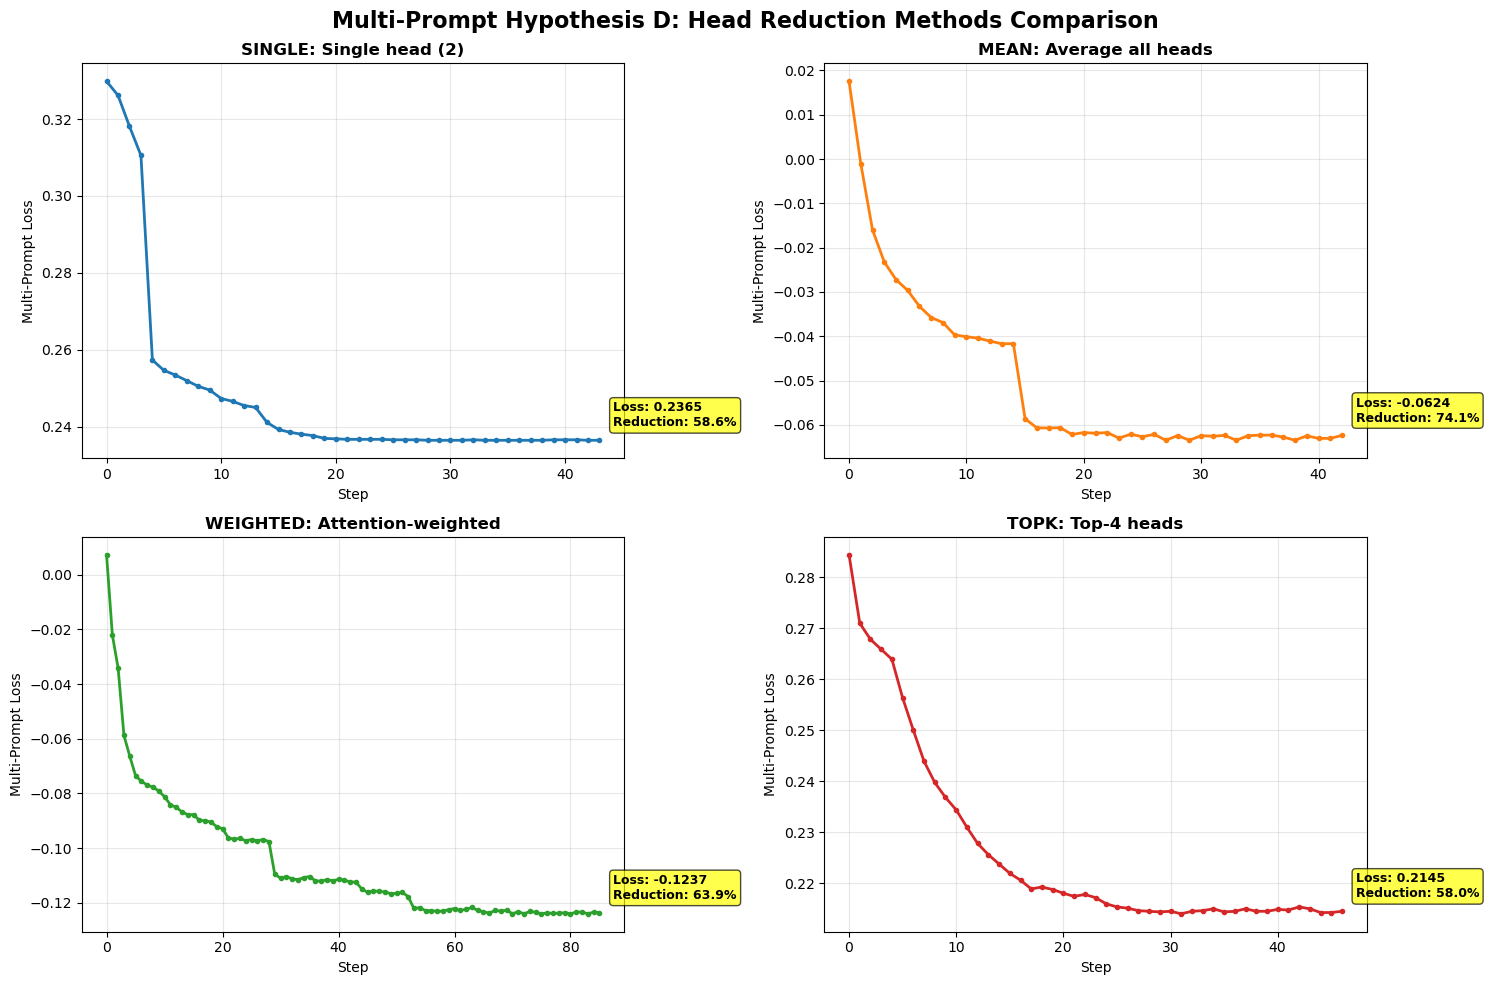


Method       Description               Final Loss   Attention Reduction  Steps   
single       Single head (2)           0.236450     58.6                % 44      
mean         Average all heads         -0.062378    74.1                % 43      
weighted     Attention-weighted        -0.123657    63.9                % 86      
topk         Top-4 heads               0.214478     58.0                % 47      


In [76]:
# Plot comparison of head reduction methods for multi-prompt Hypothesis D
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (method_name, result) in enumerate(multi_d_results.items()):
    ax = axes[i]
    loss_history = result['results']['loss_history']
    
    ax.plot(loss_history, linewidth=2, marker='o', markersize=3, color=f'C{i}')
    ax.set_title(f'{method_name.upper()}: {result["description"]}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Step')
    ax.set_ylabel('Multi-Prompt Loss')
    ax.grid(True, alpha=0.3)
    
    # Add final loss and reduction annotations
    final_loss = loss_history[-1]
    baseline_attn = result['baseline_metrics']['aggregate']['total_attn_to_sink_all_heads_mean_mean']
    attack_attn = result['attack_metrics']['aggregate']['total_attn_to_sink_all_heads_mean_mean']
    reduction_pct = ((baseline_attn - attack_attn) / baseline_attn * 100) if baseline_attn != 0 else 0
    
    ax.annotate(f'Loss: {final_loss:.4f}\nReduction: {reduction_pct:.1f}%', 
               xy=(len(loss_history)-1, final_loss),
               xytext=(10, 10), textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
               fontsize=9, fontweight='bold')

plt.suptitle('Multi-Prompt Hypothesis D: Head Reduction Methods Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'='*90}")
print(f"{'Method':<12} {'Description':<25} {'Final Loss':<12} {'Attention Reduction':<20} {'Steps':<8}")
print(f"{'='*90}")

for method_name, result in multi_d_results.items():
    final_loss = result['results']['final_loss']
    steps = result['results']['steps_completed']
    desc = result['description']
    
    baseline_attn = result['baseline_metrics']['aggregate']['total_attn_to_sink_all_heads_mean_mean']
    attack_attn = result['attack_metrics']['aggregate']['total_attn_to_sink_all_heads_mean_mean']
    reduction_pct = ((baseline_attn - attack_attn) / baseline_attn * 100) if baseline_attn != 0 else 0
    
    print(f"{method_name:<12} {desc:<25} {final_loss:<12.6f} {reduction_pct:<20.1f}% {steps:<8}")

print(f"{'='*90}")

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/3372321107.py:260: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax13.boxplot(all_prompt_reductions, labels=labels, patch_artist=True)
/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/3372321107.py:275: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


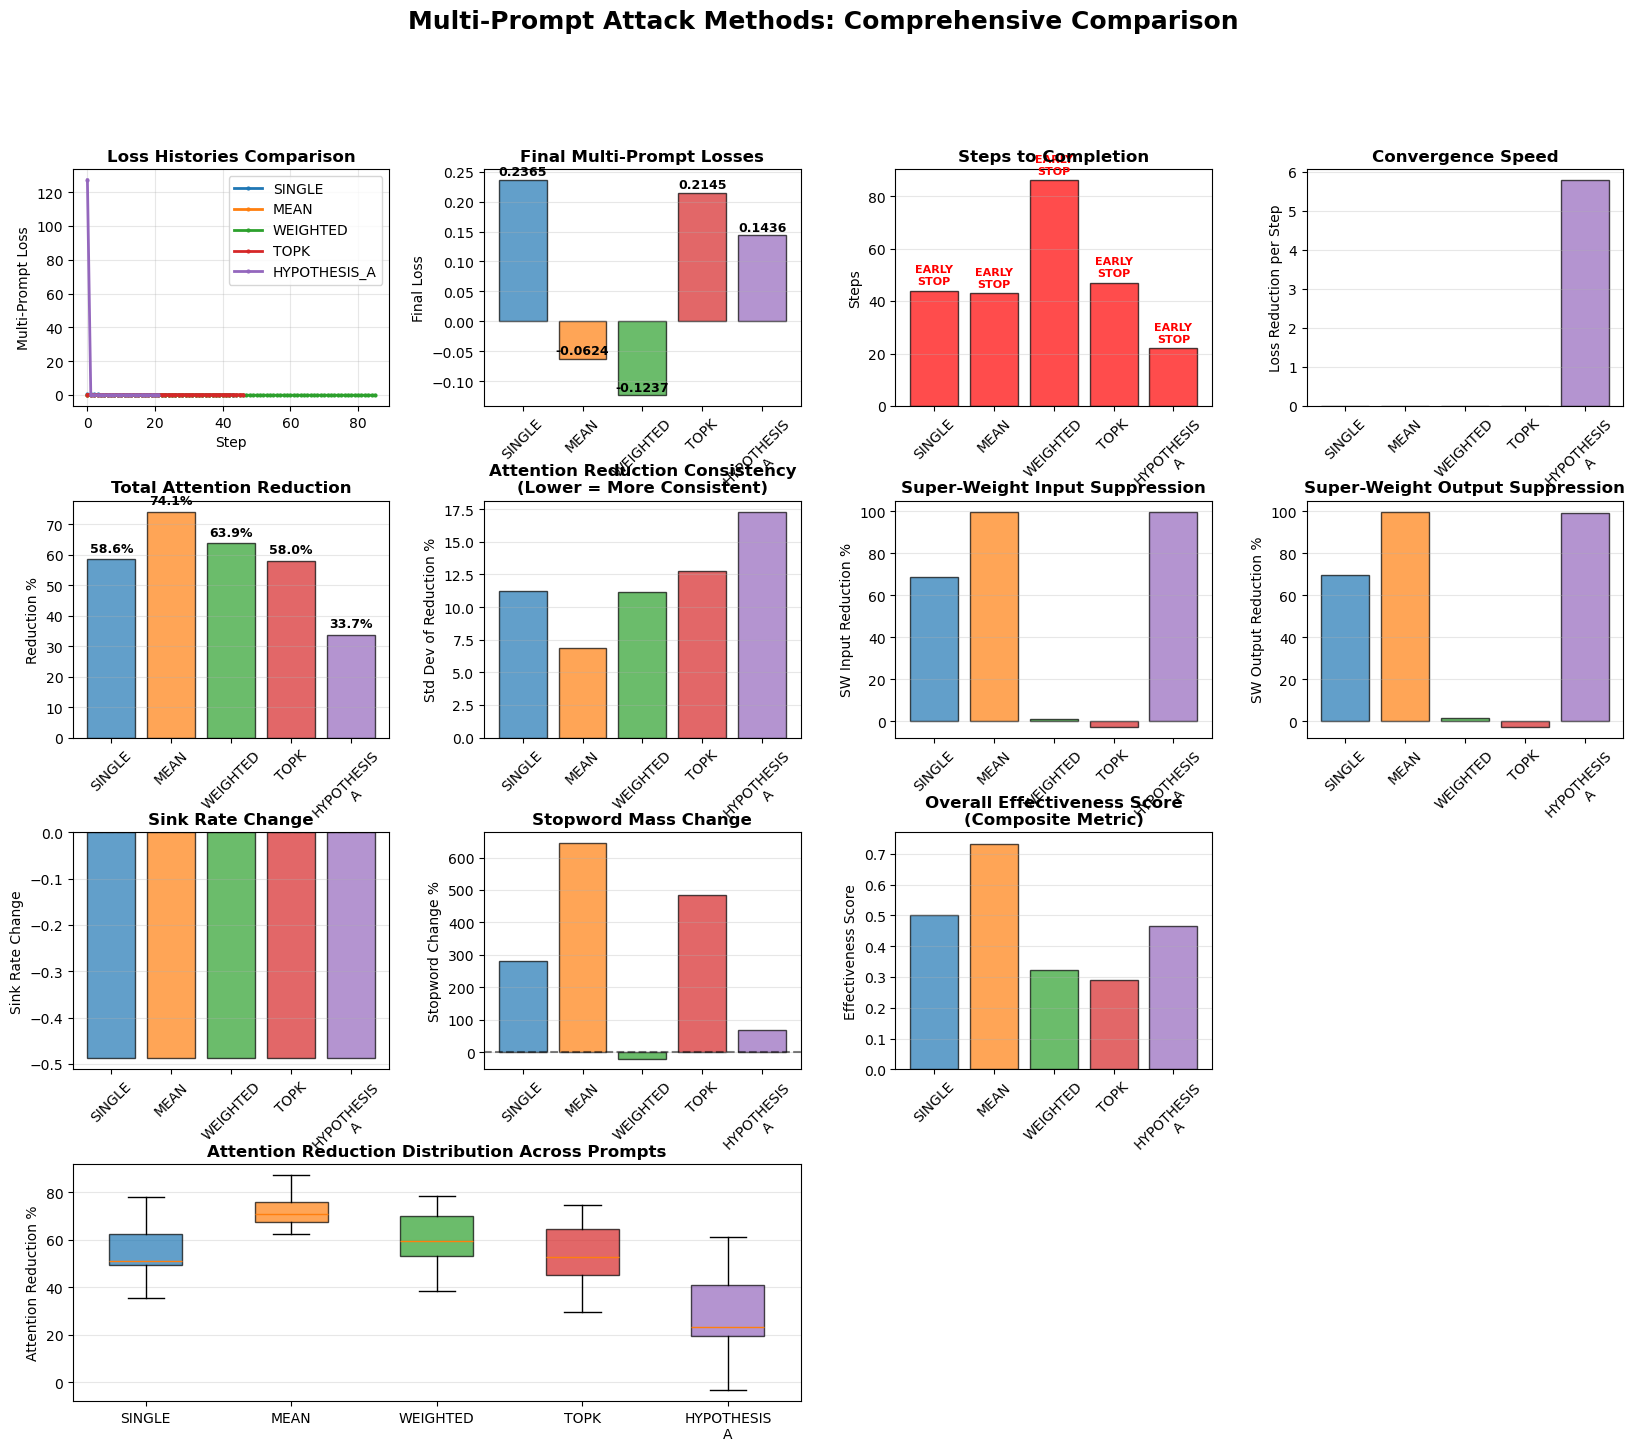


MULTI-PROMPT ATTACK METHODS: DETAILED COMPARISON
Method          Final Loss   Attn Red%  Consistency  SW In Red% SW Out Red% Steps    Effectiveness
Single          0.236450     58.6       11.23        68.8       69.4        44       (E) 0.500       
Mean            -0.062378    74.1       6.86         99.9       99.9        43       (E) 0.733       
Weighted        -0.123657    63.9       11.16        1.3        1.4         86       (E) 0.323       
Topk            0.214478     58.0       12.75        -2.7       -2.8        47       (E) 0.290       
Hypothesis A    0.143555     33.7       17.28        100.0      99.2        22       (E) 0.467       
Legend: (E) = Early stopped, Consistency = Std dev of attention reduction across prompts (lower = better)


In [77]:
# Comprehensive comparison of multi-prompt head reduction methods + Hypothesis A
def plot_comprehensive_multi_prompt_comparison(multi_d_results, multi_results_A, baseline_multi_metrics_A, attack_multi_metrics_A):
    """
    Comprehensive comparison of multi-prompt attacks across different methods.
    """
    
    # Add Hypothesis A to the comparison
    all_results = dict(multi_d_results)
    all_results['hypothesis_A'] = {
        'results': multi_results_A,
        'baseline_metrics': baseline_multi_metrics_A,
        'attack_metrics': attack_multi_metrics_A,
        'description': 'Hypothesis A (Activation Suppression)'
    }
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)
    
    # ============================
    # 1. LOSS HISTORIES (Top Row)
    # ============================
    colors = ['C0', 'C1', 'C2', 'C3', 'C4']
    
    # 1a. All loss histories overlaid
    ax1 = fig.add_subplot(gs[0, 0])
    for i, (method_name, result) in enumerate(all_results.items()):
        loss_history = result['results']['loss_history']
        ax1.plot(loss_history, linewidth=2, marker='o', markersize=2, 
                label=method_name.upper(), color=colors[i % len(colors)])
    ax1.set_title('Loss Histories Comparison', fontweight='bold')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Multi-Prompt Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 1b. Final losses bar chart
    ax2 = fig.add_subplot(gs[0, 1])
    method_names = list(all_results.keys())
    final_losses = [result['results']['final_loss'] for result in all_results.values()]
    
    bars = ax2.bar(range(len(method_names)), final_losses, 
                   color=[colors[i % len(colors)] for i in range(len(method_names))],
                   alpha=0.7, edgecolor='black')
    ax2.set_title('Final Multi-Prompt Losses', fontweight='bold')
    ax2.set_ylabel('Final Loss')
    ax2.set_xticks(range(len(method_names)))
    ax2.set_xticklabels([name.replace('_', '\n').upper() for name in method_names], rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, final_losses)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(final_losses) * 0.01, 
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 1c. Steps to completion
    ax3 = fig.add_subplot(gs[0, 2])
    steps_completed = [result['results']['steps_completed'] for result in all_results.values()]
    early_stopped = [result['results'].get('early_stopped', False) for result in all_results.values()]
    
    bars = ax3.bar(range(len(method_names)), steps_completed,
                   color=['red' if stopped else colors[i % len(colors)] for i, stopped in enumerate(early_stopped)],
                   alpha=0.7, edgecolor='black')
    ax3.set_title('Steps to Completion', fontweight='bold')
    ax3.set_ylabel('Steps')
    ax3.set_xticks(range(len(method_names)))
    ax3.set_xticklabels([name.replace('_', '\n').upper() for name in method_names], rotation=45)
    ax3.grid(axis='y', alpha=0.3)
    
    # Add early stopping indicators
    for i, (bar, stopped) in enumerate(zip(bars, early_stopped)):
        if stopped:
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(steps_completed) * 0.02, 
                    'EARLY\nSTOP', ha='center', va='bottom', fontweight='bold', fontsize=8, color='red')
    
    # 1d. Convergence speed (loss reduction per step)
    ax4 = fig.add_subplot(gs[0, 3])
    convergence_speeds = []
    for result in all_results.values():
        loss_hist = result['results']['loss_history']
        if len(loss_hist) > 1:
            initial_loss = loss_hist[0]
            final_loss = loss_hist[-1]
            steps = len(loss_hist)
            speed = (initial_loss - final_loss) / steps
            convergence_speeds.append(speed)
        else:
            convergence_speeds.append(0)
    
    bars = ax4.bar(range(len(method_names)), convergence_speeds,
                   color=[colors[i % len(colors)] for i in range(len(method_names))],
                   alpha=0.7, edgecolor='black')
    ax4.set_title('Convergence Speed', fontweight='bold')
    ax4.set_ylabel('Loss Reduction per Step')
    ax4.set_xticks(range(len(method_names)))
    ax4.set_xticklabels([name.replace('_', '\n').upper() for name in method_names], rotation=45)
    ax4.grid(axis='y', alpha=0.3)
    
    # =======================================
    # 2. ATTENTION REDUCTION METRICS (Row 2)
    # =======================================
    
    # 2a. Total attention reduction
    ax5 = fig.add_subplot(gs[1, 0])
    attention_reductions = []
    for result in all_results.values():
        baseline_attn = result['baseline_metrics']['aggregate']['total_attn_to_sink_all_heads_mean_mean']
        attack_attn = result['attack_metrics']['aggregate']['total_attn_to_sink_all_heads_mean_mean']
        reduction_pct = ((baseline_attn - attack_attn) / baseline_attn * 100) if baseline_attn != 0 else 0
        attention_reductions.append(reduction_pct)
    
    bars = ax5.bar(range(len(method_names)), attention_reductions,
                   color=[colors[i % len(colors)] for i in range(len(method_names))],
                   alpha=0.7, edgecolor='black')
    ax5.set_title('Total Attention Reduction', fontweight='bold')
    ax5.set_ylabel('Reduction %')
    ax5.set_xticks(range(len(method_names)))
    ax5.set_xticklabels([name.replace('_', '\n').upper() for name in method_names], rotation=45)
    ax5.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, attention_reductions)):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(attention_reductions) * 0.02, 
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 2b. Attention reduction consistency (std across prompts)
    ax6 = fig.add_subplot(gs[1, 1])
    attention_stds = []
    for result in all_results.values():
        baseline_attns = [m['total_attn_to_sink_all_heads_mean'] for m in result['baseline_metrics']['per_prompt']]
        attack_attns = [m['total_attn_to_sink_all_heads_mean'] for m in result['attack_metrics']['per_prompt']]
        reductions = [((b - a) / b * 100) if b != 0 else 0 for b, a in zip(baseline_attns, attack_attns)]
        attention_stds.append(np.std(reductions))
    
    bars = ax6.bar(range(len(method_names)), attention_stds,
                   color=[colors[i % len(colors)] for i in range(len(method_names))],
                   alpha=0.7, edgecolor='black')
    ax6.set_title('Attention Reduction Consistency\n(Lower = More Consistent)', fontweight='bold')
    ax6.set_ylabel('Std Dev of Reduction %')
    ax6.set_xticks(range(len(method_names)))
    ax6.set_xticklabels([name.replace('_', '\n').upper() for name in method_names], rotation=45)
    ax6.grid(axis='y', alpha=0.3)
    
    # 2c. Super-weight input suppression
    ax7 = fig.add_subplot(gs[1, 2])
    sw_input_reductions = []
    for result in all_results.values():
        baseline_sw = result['baseline_metrics']['aggregate']['down_proj_in_col_at_sink_mean']
        attack_sw = result['attack_metrics']['aggregate']['down_proj_in_col_at_sink_mean']
        reduction_pct = ((baseline_sw - attack_sw) / baseline_sw * 100) if baseline_sw != 0 else 0
        sw_input_reductions.append(reduction_pct)
    
    bars = ax7.bar(range(len(method_names)), sw_input_reductions,
                   color=[colors[i % len(colors)] for i in range(len(method_names))],
                   alpha=0.7, edgecolor='black')
    ax7.set_title('Super-Weight Input Suppression', fontweight='bold')
    ax7.set_ylabel('SW Input Reduction %')
    ax7.set_xticks(range(len(method_names)))
    ax7.set_xticklabels([name.replace('_', '\n').upper() for name in method_names], rotation=45)
    ax7.grid(axis='y', alpha=0.3)
    
    # 2d. Super-weight output suppression  
    ax8 = fig.add_subplot(gs[1, 3])
    sw_output_reductions = []
    for result in all_results.values():
        baseline_sw = result['baseline_metrics']['aggregate']['down_proj_out_row_at_sink_mean']
        attack_sw = result['attack_metrics']['aggregate']['down_proj_out_row_at_sink_mean']
        reduction_pct = ((baseline_sw - attack_sw) / baseline_sw * 100) if baseline_sw != 0 else 0
        sw_output_reductions.append(reduction_pct)
    
    bars = ax8.bar(range(len(method_names)), sw_output_reductions,
                   color=[colors[i % len(colors)] for i in range(len(method_names))],
                   alpha=0.7, edgecolor='black')
    ax8.set_title('Super-Weight Output Suppression', fontweight='bold')
    ax8.set_ylabel('SW Output Reduction %')
    ax8.set_xticks(range(len(method_names)))
    ax8.set_xticklabels([name.replace('_', '\n').upper() for name in method_names], rotation=45)
    ax8.grid(axis='y', alpha=0.3)
    
    # =====================================
    # 3. BEHAVIORAL METRICS (Row 3)
    # =====================================
    
    # 3a. Sink rate changes
    ax9 = fig.add_subplot(gs[2, 0])
    sink_rate_changes = []
    for result in all_results.values():
        baseline_sr = result['baseline_metrics']['aggregate']['sink_rate_mean']
        attack_sr = result['attack_metrics']['aggregate']['sink_rate_mean']
        change = attack_sr - baseline_sr
        sink_rate_changes.append(change)
    
    bars = ax9.bar(range(len(method_names)), sink_rate_changes,
                   color=[colors[i % len(colors)] for i in range(len(method_names))],
                   alpha=0.7, edgecolor='black')
    ax9.set_title('Sink Rate Change', fontweight='bold')
    ax9.set_ylabel('Sink Rate Change')
    ax9.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax9.set_xticks(range(len(method_names)))
    ax9.set_xticklabels([name.replace('_', '\n').upper() for name in method_names], rotation=45)
    ax9.grid(axis='y', alpha=0.3)
    
    # 3c. Stopword mass changes
    ax11 = fig.add_subplot(gs[2, 1])
    stopword_changes = []
    for result in all_results.values():
        baseline_sw = result['baseline_metrics']['aggregate']['stopword_mass_next_token_mean']
        attack_sw = result['attack_metrics']['aggregate']['stopword_mass_next_token_mean']
        change_pct = ((attack_sw - baseline_sw) / baseline_sw * 100) if baseline_sw != 0 else 0
        stopword_changes.append(change_pct)
    
    bars = ax11.bar(range(len(method_names)), stopword_changes,
                    color=[colors[i % len(colors)] for i in range(len(method_names))],
                    alpha=0.7, edgecolor='black')
    ax11.set_title('Stopword Mass Change', fontweight='bold')
    ax11.set_ylabel('Stopword Change %')
    ax11.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax11.set_xticks(range(len(method_names)))
    ax11.set_xticklabels([name.replace('_', '\n').upper() for name in method_names], rotation=45)
    ax11.grid(axis='y', alpha=0.3)
    
    # 3d. Overall effectiveness score (composite)
    ax12 = fig.add_subplot(gs[2, 2])
    effectiveness_scores = []
    for i, result in enumerate(all_results.values()):
        # Composite score: attention reduction (primary) + SW suppression + consistency bonus
        attn_score = attention_reductions[i] / 100  # Normalize to 0-1
        consistency_bonus = max(0, (10 - attention_stds[i]) / 10)  # Higher consistency = higher bonus
        sw_input_score = max(0, sw_input_reductions[i] / 100)
        sw_output_score = max(0, sw_output_reductions[i] / 100)
        
        composite_score = (0.5 * attn_score + 0.2 * consistency_bonus + 
                          0.15 * sw_input_score + 0.15 * sw_output_score)
        effectiveness_scores.append(composite_score)
    
    bars = ax12.bar(range(len(method_names)), effectiveness_scores,
                    color=[colors[i % len(colors)] for i in range(len(method_names))],
                    alpha=0.7, edgecolor='black')
    ax12.set_title('Overall Effectiveness Score\n(Composite Metric)', fontweight='bold')
    ax12.set_ylabel('Effectiveness Score')
    ax12.set_xticks(range(len(method_names)))
    ax12.set_xticklabels([name.replace('_', '\n').upper() for name in method_names], rotation=45)
    ax12.grid(axis='y', alpha=0.3)
    
    # ===================================
    # 4. PER-PROMPT VARIATION (Row 4)
    # ===================================
    
    # 4a. Box plot of attention reductions across prompts
    ax13 = fig.add_subplot(gs[3, 0:2])
    all_prompt_reductions = []
    labels = []
    
    for method_name, result in all_results.items():
        baseline_attns = [m['total_attn_to_sink_all_heads_mean'] for m in result['baseline_metrics']['per_prompt']]
        attack_attns = [m['total_attn_to_sink_all_heads_mean'] for m in result['attack_metrics']['per_prompt']]
        reductions = [((b - a) / b * 100) if b != 0 else 0 for b, a in zip(baseline_attns, attack_attns)]
        all_prompt_reductions.append(reductions)
        labels.append(method_name.replace('_', '\n').upper())
    
    bp = ax13.boxplot(all_prompt_reductions, labels=labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax13.set_title('Attention Reduction Distribution Across Prompts', fontweight='bold')
    ax13.set_ylabel('Attention Reduction %')
    ax13.grid(axis='y', alpha=0.3)
    
    # 4b. Summary ranking table
    ax14 = fig.add_subplot(gs[3, 2:])
    ax14.axis('off')
    
    plt.suptitle('Multi-Prompt Attack Methods: Comprehensive Comparison', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison table
    print(f"\n{'='*120}")
    print("MULTI-PROMPT ATTACK METHODS: DETAILED COMPARISON")
    print(f"{'='*120}")
    print(f"{'Method':<15} {'Final Loss':<12} {'Attn Red%':<10} {'Consistency':<12} {'SW In Red%':<10} {'SW Out Red%':<11} {'Steps':<8} {'Effectiveness':<12}")
    print(f"{'='*120}")
    
    for i, (method_name, result) in enumerate(all_results.items()):
        method_display = method_name.replace('_', ' ').title()[:14]
        final_loss = result['results']['final_loss']
        steps = result['results']['steps_completed']
        early = " (E)" if result['results'].get('early_stopped', False) else ""
        
        print(f"{method_display:<15} {final_loss:<12.6f} {attention_reductions[i]:<10.1f} {attention_stds[i]:<12.2f} "
              f"{sw_input_reductions[i]:<10.1f} {sw_output_reductions[i]:<11.1f} {steps:<8}{early} {effectiveness_scores[i]:<12.3f}")
    
    print(f"{'='*120}")
    print("Legend: (E) = Early stopped, Consistency = Std dev of attention reduction across prompts (lower = better)")
    
    return all_results

# Run the comprehensive comparison
comprehensive_results = plot_comprehensive_multi_prompt_comparison(
    multi_d_results, 
    multi_results_A, 
    baseline_multi_metrics_A, 
    attack_multi_metrics_A
)

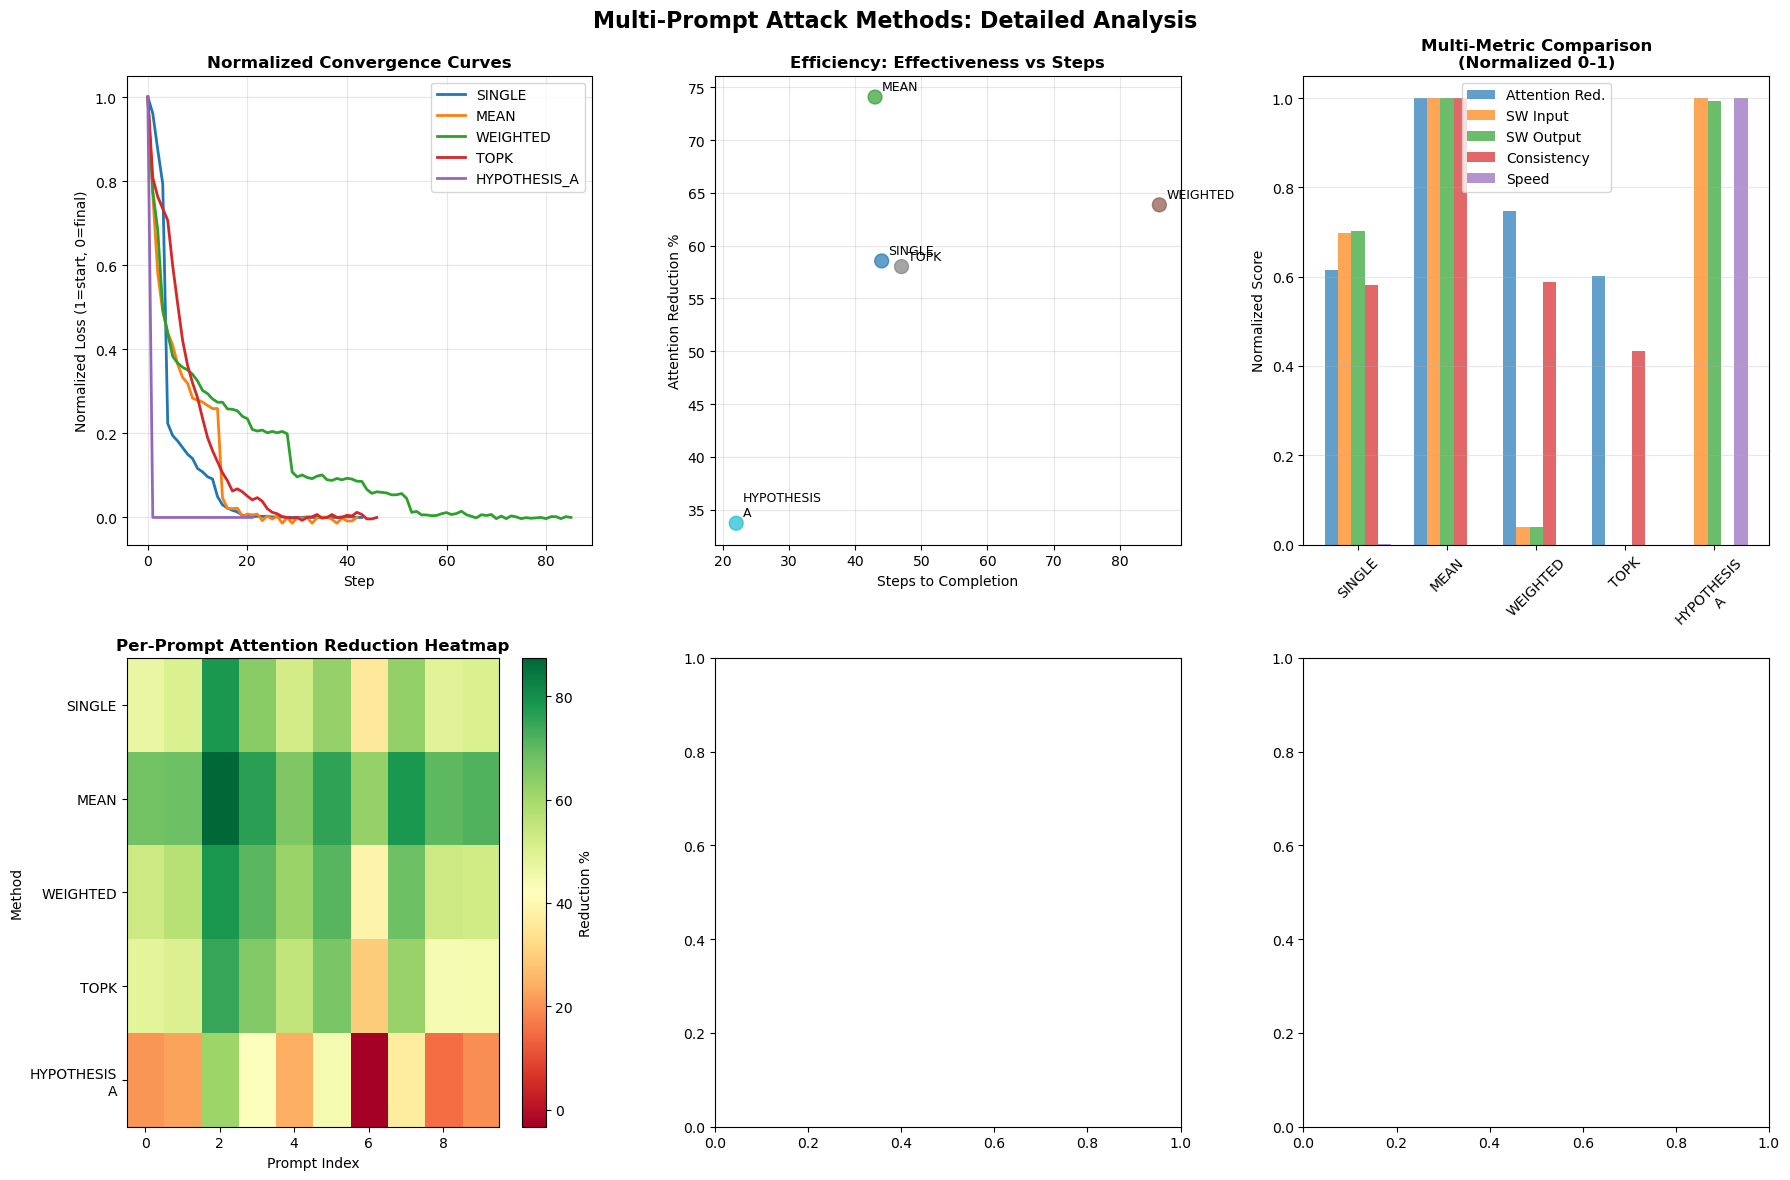

In [78]:
# Additional focused comparison plots
def plot_method_specific_analysis(all_results):
    """Create focused plots for specific aspects of the comparison."""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    method_names = list(all_results.keys())
    colors = ['C0', 'C1', 'C2', 'C3', 'C4']
    
    # 1. Convergence curves (normalized)
    ax1 = axes[0, 0]
    for i, (method_name, result) in enumerate(all_results.items()):
        loss_hist = result['results']['loss_history']
        # Normalize to 0-1 scale
        normalized_loss = [(l - loss_hist[-1]) / (loss_hist[0] - loss_hist[-1]) for l in loss_hist]
        ax1.plot(normalized_loss, label=method_name.upper(), linewidth=2, color=colors[i % len(colors)])
    
    ax1.set_title('Normalized Convergence Curves', fontweight='bold')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Normalized Loss (1=start, 0=final)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Efficiency scatter plot (effectiveness vs steps)
    ax2 = axes[0, 1]
    effectiveness_scores = []
    steps_taken = []
    
    for result in all_results.values():
        baseline_attn = result['baseline_metrics']['aggregate']['total_attn_to_sink_all_heads_mean_mean']
        attack_attn = result['attack_metrics']['aggregate']['total_attn_to_sink_all_heads_mean_mean']
        effectiveness = ((baseline_attn - attack_attn) / baseline_attn * 100) if baseline_attn != 0 else 0
        effectiveness_scores.append(effectiveness)
        steps_taken.append(result['results']['steps_completed'])
    
    scatter = ax2.scatter(steps_taken, effectiveness_scores, 
                         c=range(len(all_results)), s=100, alpha=0.7, cmap='tab10')
    
    for i, (steps, eff) in enumerate(zip(steps_taken, effectiveness_scores)):
        ax2.annotate(list(all_results.keys())[i].replace('_', '\n').upper(), 
                    (steps, eff), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax2.set_title('Efficiency: Effectiveness vs Steps', fontweight='bold')
    ax2.set_xlabel('Steps to Completion')
    ax2.set_ylabel('Attention Reduction %')
    ax2.grid(True, alpha=0.3)
    
    # 3. Multi-metric radar chart preparation
    ax3 = axes[0, 2]
    metrics = ['Attention\nReduction', 'SW Input\nSuppression', 'SW Output\nSuppression', 
               'Consistency', 'Speed']
    
    # Normalize all metrics to 0-1 scale for radar chart
    all_attention_red = [((result['baseline_metrics']['aggregate']['total_attn_to_sink_all_heads_mean_mean'] - 
                          result['attack_metrics']['aggregate']['total_attn_to_sink_all_heads_mean_mean']) / 
                         result['baseline_metrics']['aggregate']['total_attn_to_sink_all_heads_mean_mean'] * 100) 
                        for result in all_results.values()]
    
    all_sw_input_red = [((result['baseline_metrics']['aggregate']['down_proj_in_col_at_sink_mean'] - 
                         result['attack_metrics']['aggregate']['down_proj_in_col_at_sink_mean']) / 
                        result['baseline_metrics']['aggregate']['down_proj_in_col_at_sink_mean'] * 100) 
                       for result in all_results.values()]
    
    all_sw_output_red = [((result['baseline_metrics']['aggregate']['down_proj_out_row_at_sink_mean'] - 
                          result['attack_metrics']['aggregate']['down_proj_out_row_at_sink_mean']) / 
                         result['baseline_metrics']['aggregate']['down_proj_out_row_at_sink_mean'] * 100) 
                        for result in all_results.values()]
    
    all_consistency = [10 - np.std([((b['total_attn_to_sink_all_heads_mean'] - a['total_attn_to_sink_all_heads_mean']) / 
                                    b['total_attn_to_sink_all_heads_mean'] * 100) 
                                   for b, a in zip(result['baseline_metrics']['per_prompt'], 
                                                  result['attack_metrics']['per_prompt'])]) 
                      for result in all_results.values()]
    
    all_speed = [(result['results']['loss_history'][0] - result['results']['loss_history'][-1]) / 
                result['results']['steps_completed'] for result in all_results.values()]
    
    # Normalize to 0-1
    def normalize_list(lst):
        min_val, max_val = min(lst), max(lst)
        return [(x - min_val) / (max_val - min_val) if max_val > min_val else 0.5 for x in lst]
    
    norm_attention = normalize_list(all_attention_red)
    norm_sw_input = normalize_list(all_sw_input_red)
    norm_sw_output = normalize_list(all_sw_output_red)
    norm_consistency = normalize_list(all_consistency)
    norm_speed = normalize_list(all_speed)
    
    # Simple bar chart instead of radar (easier to read)
    x_pos = np.arange(len(method_names))
    width = 0.15
    
    ax3.bar(x_pos - 2*width, norm_attention, width, label='Attention Red.', alpha=0.7)
    ax3.bar(x_pos - width, norm_sw_input, width, label='SW Input', alpha=0.7)
    ax3.bar(x_pos, norm_sw_output, width, label='SW Output', alpha=0.7)
    ax3.bar(x_pos + width, norm_consistency, width, label='Consistency', alpha=0.7)
    ax3.bar(x_pos + 2*width, norm_speed, width, label='Speed', alpha=0.7)
    
    ax3.set_title('Multi-Metric Comparison\n(Normalized 0-1)', fontweight='bold')
    ax3.set_ylabel('Normalized Score')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([name.replace('_', '\n').upper() for name in method_names], rotation=45)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Per-prompt heatmap
    ax4 = axes[1, 0]
    prompt_reduction_matrix = []
    
    for result in all_results.values():
        baseline_attns = [m['total_attn_to_sink_all_heads_mean'] for m in result['baseline_metrics']['per_prompt']]
        attack_attns = [m['total_attn_to_sink_all_heads_mean'] for m in result['attack_metrics']['per_prompt']]
        reductions = [((b - a) / b * 100) if b != 0 else 0 for b, a in zip(baseline_attns, attack_attns)]
        prompt_reduction_matrix.append(reductions)
    
    im = ax4.imshow(prompt_reduction_matrix, aspect='auto', cmap='RdYlGn')
    ax4.set_title('Per-Prompt Attention Reduction Heatmap', fontweight='bold')
    ax4.set_ylabel('Method')
    ax4.set_xlabel('Prompt Index')
    ax4.set_yticks(range(len(method_names)))
    ax4.set_yticklabels([name.replace('_', '\n').upper() for name in method_names])
    plt.colorbar(im, ax=ax4, label='Reduction %')
    
    plt.suptitle('Multi-Prompt Attack Methods: Detailed Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create the detailed analysis plots
plot_method_specific_analysis(comprehensive_results)


DETAILED ANALYSIS: SINGLE


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax7.boxplot([baseline_variations, attack_variations], labels=['Baseline', 'Attack'])
/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


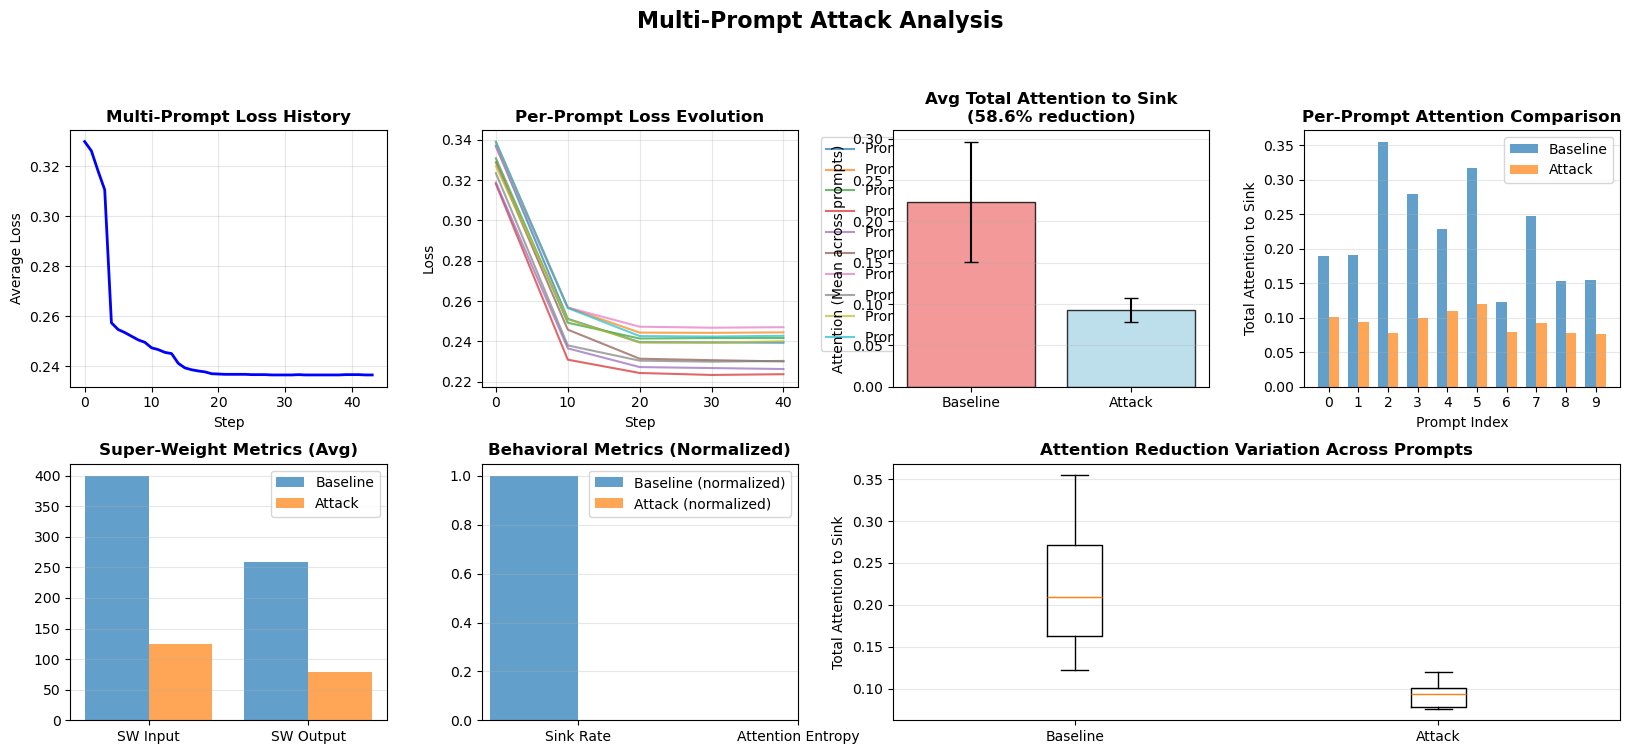


MULTI-PROMPT ATTACK DETAILED RESULTS
Number of prompts: 10
Final adversarial string: Take   https    '
Average final loss: 0.236450
Total attention reduction: 58.55%

DETAILED ANALYSIS: MEAN


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax7.boxplot([baseline_variations, attack_variations], labels=['Baseline', 'Attack'])
/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


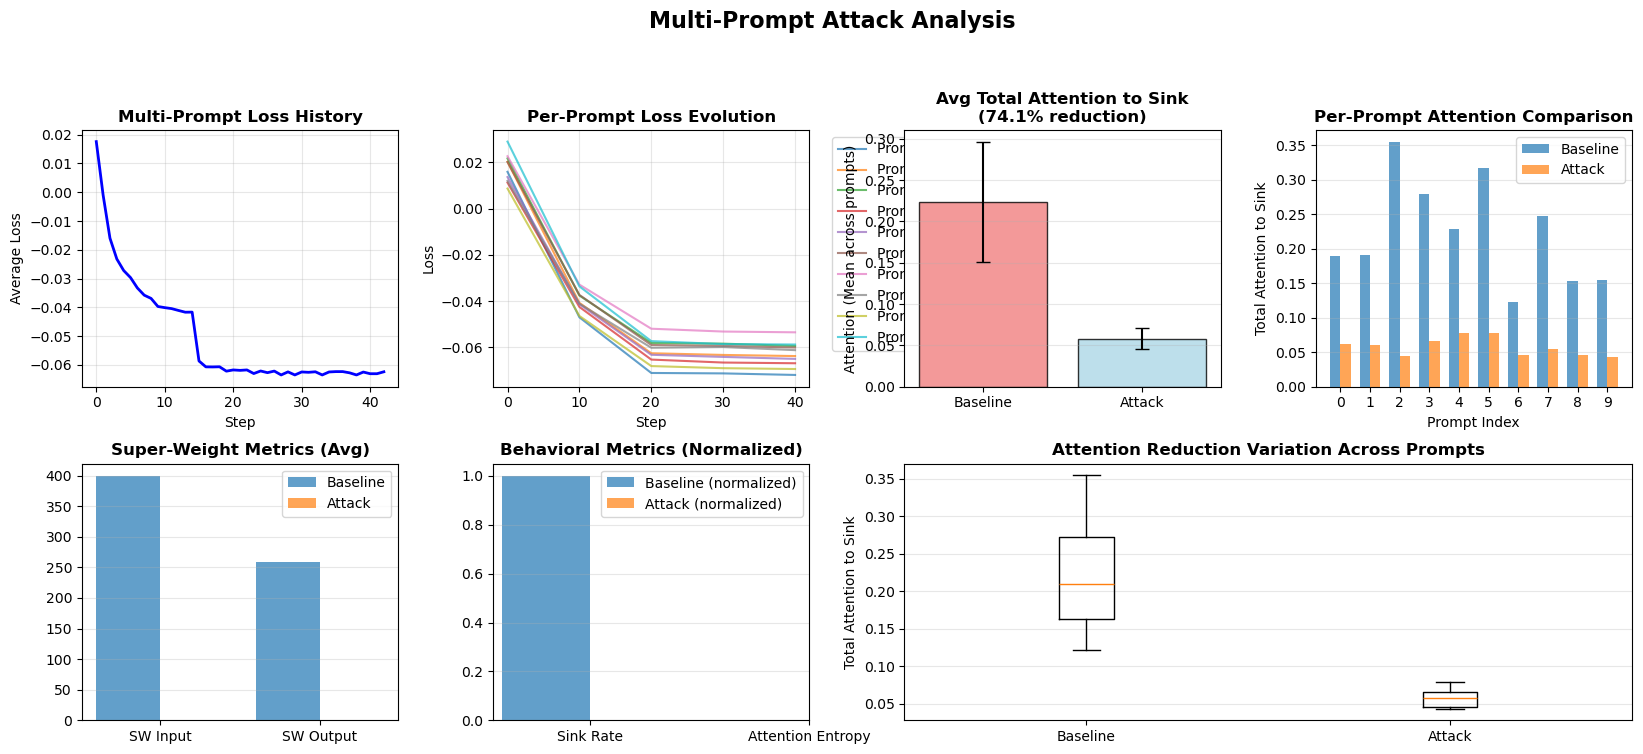


MULTI-PROMPT ATTACK DETAILED RESULTS
Number of prompts: 10
Final adversarial string: 'xxxxxxxxret'
Average final loss: -0.062378
Total attention reduction: 74.08%

DETAILED ANALYSIS: WEIGHTED


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax7.boxplot([baseline_variations, attack_variations], labels=['Baseline', 'Attack'])
/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


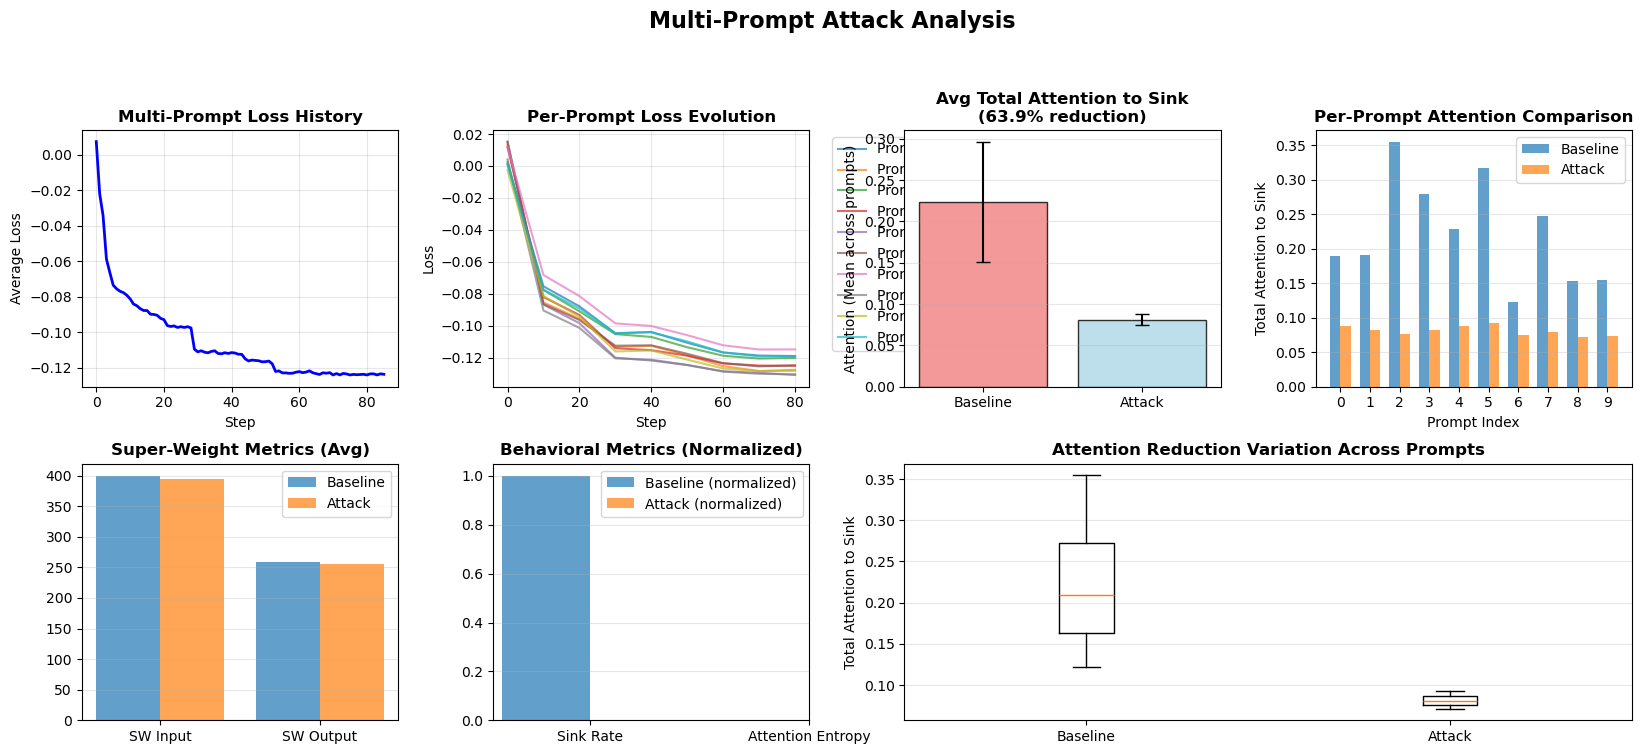


MULTI-PROMPT ATTACK DETAILED RESULTS
Number of prompts: 10
Final adversarial string: ' Of su
age */�。estialblogger

'
Average final loss: -0.123657
Total attention reduction: 63.87%

DETAILED ANALYSIS: TOPK


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax7.boxplot([baseline_variations, attack_variations], labels=['Baseline', 'Attack'])
/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


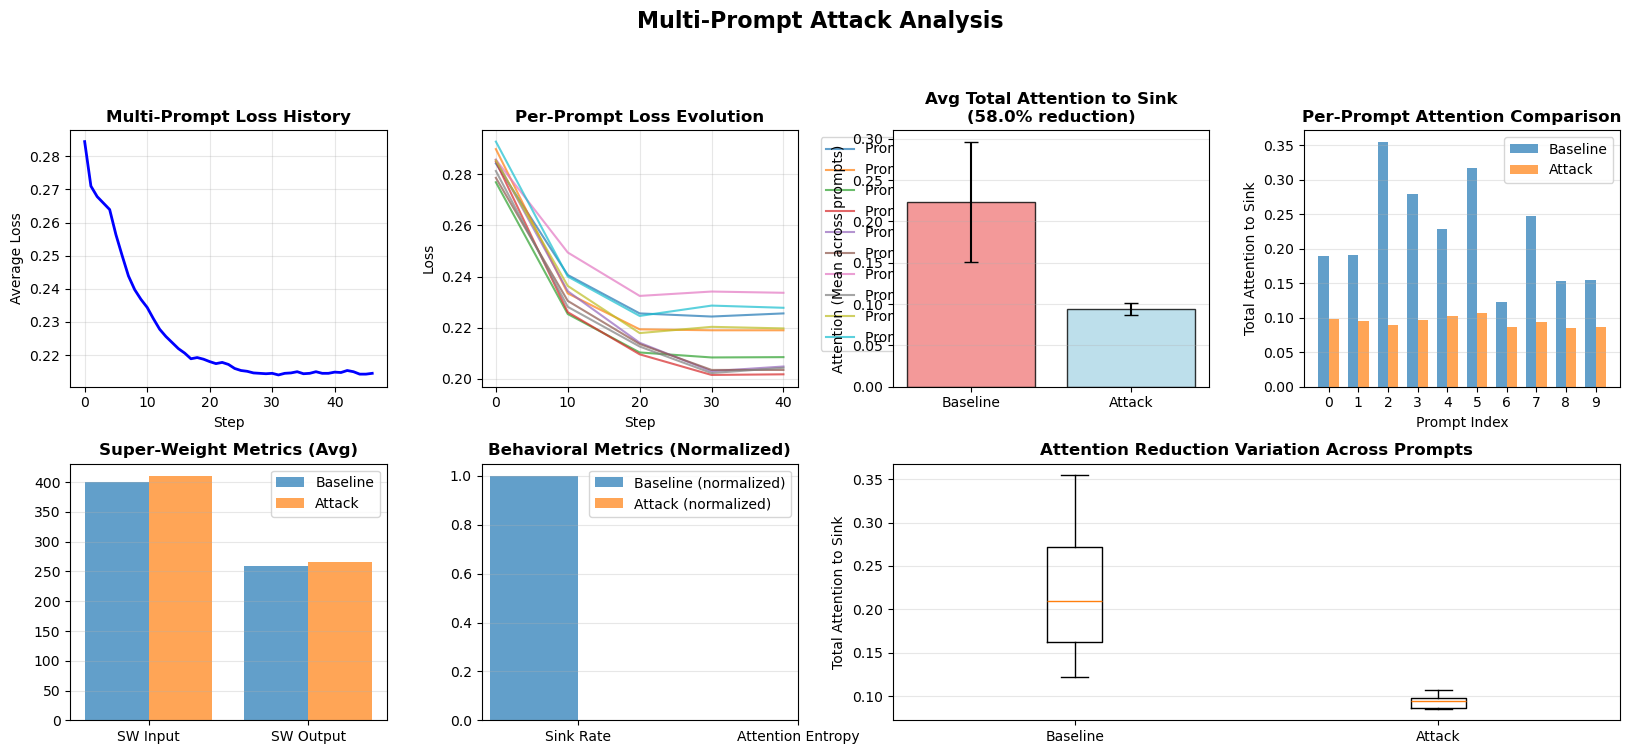


MULTI-PROMPT ATTACK DETAILED RESULTS
Number of prompts: 10
Final adversarial string: ' next caut_ speciallymsEarlyAs percol personal '
Average final loss: 0.214478
Total attention reduction: 58.02%

DETAILED ANALYSIS: HYPOTHESIS A


/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax7.boxplot([baseline_variations, attack_variations], labels=['Baseline', 'Attack'])
/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1843795540.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


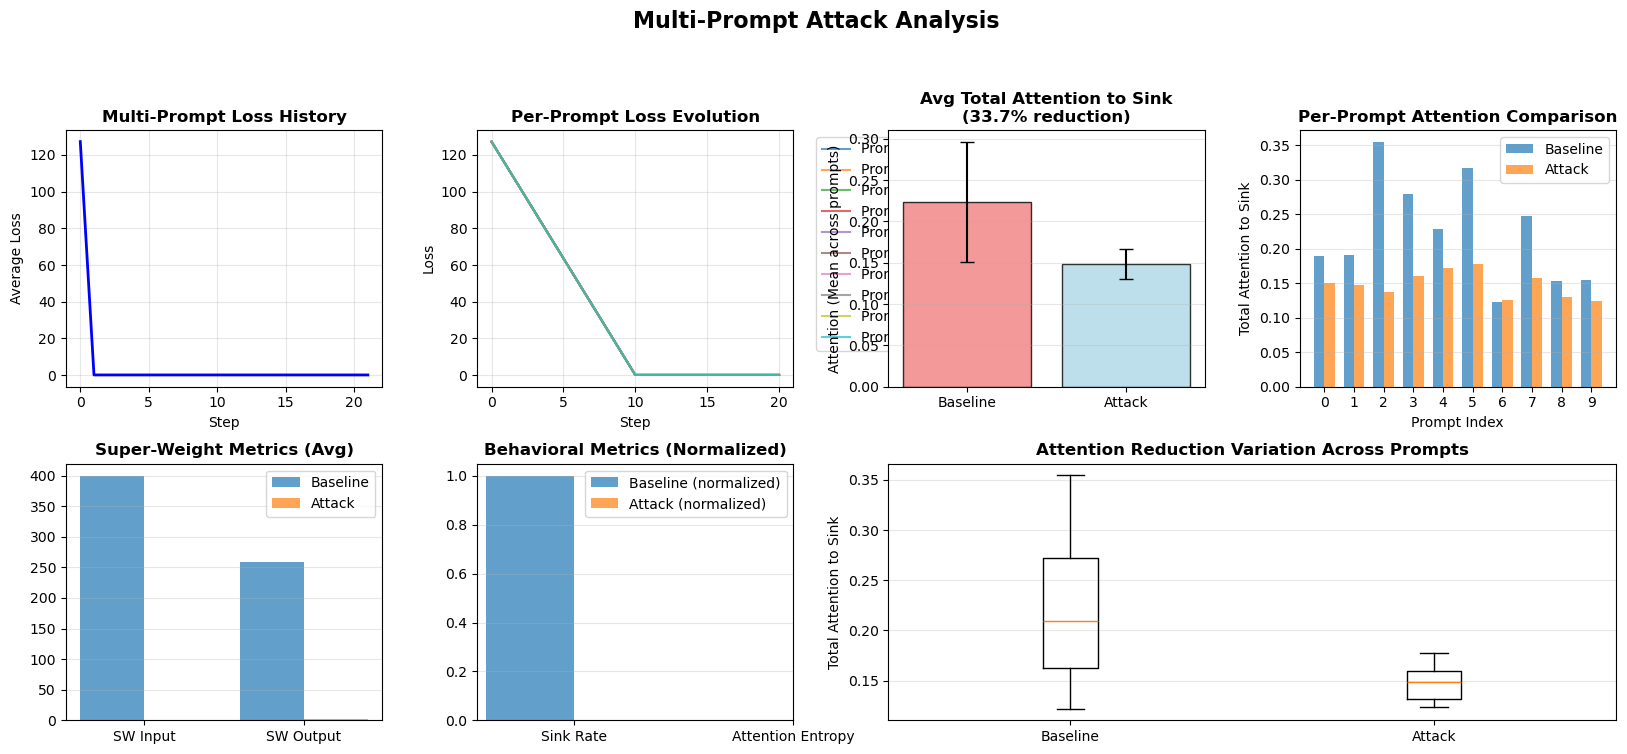


MULTI-PROMPT ATTACK DETAILED RESULTS
Number of prompts: 10
Final adversarial string: '(�b`"h@�73t'
Average final loss: 0.143555
Total attention reduction: 33.70%


In [79]:
# Create individual method visualizations (like your previous single-method plots)
def plot_individual_method_comparisons(all_results):
    """Create the typical comprehensive plots for each method, for easy comparison."""
    
    for method_name, result in all_results.items():
        print(f"\n{'='*60}")
        print(f"DETAILED ANALYSIS: {method_name.replace('_', ' ').upper()}")
        print(f"{'='*60}")
        
        plot_multi_prompt_analysis(
            result['results'],
            result['baseline_metrics'],
            result['attack_metrics']
        )

# Uncomment to run individual plots for each method
plot_individual_method_comparisons(comprehensive_results)

# Running Attack on Wikitext

In [10]:
# Clean WikiText perplexity experiment using existing infrastructure
import random
from datasets import load_dataset
from typing import List, Dict, Any
from attack.attack import SuperWeightAttackConfig, SuperWeightTarget, MultiPromptSuperWeightAttacker

def run_clean_wikitext_perplexity_experiment(session, target_sw, train_prompts: int = 64, test_prompts: int = 128,
                                           attack_steps: int = 200, seed: int = 42) -> Dict[str, Any]:
    """
    Complete WikiText perplexity experiment using existing session infrastructure.
    
    Five conditions:
    1. Baseline: Clean model, no modifications
    2. Super-weight zeroed: Target super-weight disabled 
    3. Hypothesis A attack: Optimized adversarial prefix (activation suppression)
    4. Hypothesis D attack: Optimized adversarial prefix (mean head reduction)
    5. Random control: Random string prefix of same length
    
    Returns complete experiment results with statistical analysis.
    """
    
    print("="*80)
    print("WIKITEXT PERPLEXITY EXPERIMENT - COMPREHENSIVE ANALYSIS")
    print("="*80)
    
    # Set random seed for reproducibility
    random.seed(seed)
    
    # 1. Sample WikiText-2 prompts for training attacks
    print(f"\n1. Sampling WikiText-2 training prompts...")
    train_prompts = sample_wikitext_prompts(num_prompts=train_prompts, seed=seed, 
                                           dataset_config='wikitext-2-raw-v1')
    
    # 2. Sample different test prompts for perplexity evaluation
    print(f"\n2. Sampling WikiText-2 test prompts...")
    test_prompts = sample_wikitext_prompts(num_prompts=test_prompts, seed=seed+1000,
                                          dataset_config='wikitext-2-raw-v1')
    
    print(f"Training prompts: {len(train_prompts)}")
    print(f"Test prompts: {len(test_prompts)}")
    print(f"Example test prompt: '{test_prompts[0][:100]}...'")
    
    # 3. Run Hypothesis A multi-prompt attack
    print(f"\n3. Running Hypothesis A attack (activation suppression)...")
    cfg_A = SuperWeightAttackConfig(
        target=SuperWeightTarget(super_weight=target_sw),
        hypothesis='A',
        num_steps=attack_steps,
        adv_string_init="<bos> ~ <bos> ~ <bos>",
        search_width=256, 
        top_k_search=128, 
        batch_size=32,
        allow_non_ascii=True,
        prompt_text=train_prompts[0],
        placement='prefix'
    )
    cfg_A.early_stopping_patience = 25
    cfg_A.min_improvement = 1e-6
    
    attacker_A = MultiPromptSuperWeightAttacker(session.model, session.tokenizer, cfg_A, train_prompts)
    attack_results_A = attacker_A.attack_multi_prompt()
    adversarial_A = attack_results_A['final_adv_string']
    
    print(f"✓ Hypothesis A completed: '{adversarial_A}' (loss: {attack_results_A['final_loss']:.6f})")
    
    # 4. Run Hypothesis D multi-prompt attack (mean head reduction)
    print(f"\n4. Running Hypothesis D attack (mean head reduction)...")
    cfg_D = SuperWeightAttackConfig(
        target=SuperWeightTarget(super_weight=target_sw),
        hypothesis='D',
        num_steps=attack_steps,
        adv_string_init="<bos> ~ <bos> ~ <bos>",
        search_width=256,
        top_k_search=128,
        batch_size=32,
        allow_non_ascii=True,
        prompt_text=train_prompts[0],
        placement='prefix',
        head_reduction='mean'  # Mean head reduction
    )
    cfg_D.early_stopping_patience = 25
    cfg_D.min_improvement = 1e-6
    
    attacker_D = MultiPromptSuperWeightAttacker(session.model, session.tokenizer, cfg_D, train_prompts)
    attack_results_D = attacker_D.attack_multi_prompt()
    adversarial_D = attack_results_D['final_adv_string']
    
    print(f"✓ Hypothesis D completed: '{adversarial_D}' (loss: {attack_results_D['final_loss']:.6f})")
    
    # 5. Generate random control string
    print(f"\n5. Generating random control string...")
    # Use the longer of the two adversarial strings for control length
    control_template = adversarial_A if len(adversarial_A) > len(adversarial_D) else adversarial_D
    random_control = generate_random_control_string(control_template, session.tokenizer, seed=seed)
    
    print(f"✓ Random control: '{random_control}'")
    
    # 6. Evaluate all five conditions
    print(f"\n6. Evaluating perplexity across all conditions...")
    
    conditions = {
        'baseline': {
            'description': 'Clean model (no modifications)',
            'prefix': '',
            'zero_super_weight': False
        },
        'super_weight_zeroed': {
            'description': 'Super-weight disabled',
            'prefix': '',
            'zero_super_weight': True
        },
        'hypothesis_a_attack': {
            'description': 'Hypothesis A adversarial prefix',
            'prefix': adversarial_A,
            'zero_super_weight': False
        },
        'hypothesis_d_attack': {
            'description': 'Hypothesis D adversarial prefix',
            'prefix': adversarial_D,
            'zero_super_weight': False
        },
        'random_control': {
            'description': 'Random control prefix',
            'prefix': random_control,
            'zero_super_weight': False
        }
    }
    
    results = {
        'experiment_config': {
            'num_training_prompts': len(train_prompts),
            'num_test_prompts': len(test_prompts),
            'attack_steps': attack_steps,
            'seed': seed,
            'target_super_weight': target_sw,
        },
        'attack_results': {
            'hypothesis_a': attack_results_A,
            'hypothesis_d': attack_results_D
        },
        'adversarial_strings': {
            'hypothesis_a': adversarial_A,
            'hypothesis_d': adversarial_D,
            'random_control': random_control
        },
        'perplexity_results': {},
        'test_prompts_sample': test_prompts[:5]
    }
    
    # Evaluate each condition
    for condition_name, condition_config in conditions.items():
        print(f"   Evaluating: {condition_config['description']}...")
        
        # Prepare texts with prefix if needed
        if condition_config['prefix']:
            prefixed_texts = [condition_config['prefix'] + text for text in test_prompts]
        else:
            prefixed_texts = test_prompts
        
        # Compute perplexity with optional super-weight zeroing
        if condition_config['zero_super_weight']:
            with session.manager.temporary_zero([target_sw]):
                ppl = session.analyzer.metrics_analyzer._compute_perplexity(prefixed_texts, max_length=512)
        else:
            ppl = session.analyzer.metrics_analyzer._compute_perplexity(prefixed_texts, max_length=512)
        
        results['perplexity_results'][condition_name] = {
            'perplexity': ppl,
            'description': condition_config['description'],
            'prefix': condition_config['prefix'],
            'zero_super_weight': condition_config['zero_super_weight']
        }
        
        print(f"     Perplexity: {ppl:.2f}")
    
    # 7. Calculate relative effects
    print(f"\n7. Computing relative effects...")
    baseline_ppl = results['perplexity_results']['baseline']['perplexity']
    
    for condition_name, condition_results in results['perplexity_results'].items():
        if condition_name != 'baseline':
            ppl = condition_results['perplexity']
            effect_percent = ((ppl - baseline_ppl) / baseline_ppl) * 100
            condition_results['effect_percent'] = effect_percent
            condition_results['perplexity_ratio'] = ppl / baseline_ppl
    
    # 8. Statistical analysis
    print(f"\n8. Statistical analysis...")
    
    # Compare adversarial effects vs controls
    hyp_a_effect = results['perplexity_results']['hypothesis_a_attack']['effect_percent']
    hyp_d_effect = results['perplexity_results']['hypothesis_d_attack']['effect_percent']
    random_effect = results['perplexity_results']['random_control']['effect_percent']
    sw_zero_effect = results['perplexity_results']['super_weight_zeroed']['effect_percent']
    
    results['statistical_analysis'] = {
        'hypothesis_a_vs_random': hyp_a_effect - random_effect,
        'hypothesis_d_vs_random': hyp_d_effect - random_effect,
        'hypothesis_a_vs_d': hyp_a_effect - hyp_d_effect,
        'best_attack_vs_sw_zero': max(hyp_a_effect, hyp_d_effect) - sw_zero_effect,
        'attack_effectiveness': {
            'hypothesis_a': classify_attack_effectiveness(hyp_a_effect, random_effect),
            'hypothesis_d': classify_attack_effectiveness(hyp_d_effect, random_effect)
        }
    }
    
    # 9. Print comprehensive summary
    print_experiment_summary(results)
    
    return results

def sample_wikitext_prompts(num_prompts: int = 64, min_length: int = 50, max_length: int = 200, 
                           seed: int = 42, dataset_config: str = 'wikitext-2-raw-v1') -> List[str]:
    """Sample prompts from WikiText dataset."""
    random.seed(seed)
    
    dataset = load_dataset('wikitext', dataset_config, split='validation', streaming=True)
    dataset = dataset.shuffle(seed=seed)
    
    valid_texts = []
    for item in dataset:
        text = item['text'].strip()
        if len(text) >= min_length and len(text) <= max_length:
            if not text.startswith('=') and not text.startswith('\n'):  # Skip headers
                valid_texts.append(text)
                if len(valid_texts) >= num_prompts * 2:  # Get extra for filtering
                    break
    
    # Sample the requested number
    sampled = random.sample(valid_texts, min(num_prompts, len(valid_texts)))
    return sampled

def generate_random_control_string(template_string: str, tokenizer, seed: int = 42) -> str:
    """Generate random control string with similar token count to template."""
    template_tokens = tokenizer.encode(template_string, add_special_tokens=False)
    target_length = len(template_tokens)
    
    # Sample random tokens from vocabulary (excluding special tokens)
    vocab_size = tokenizer.vocab_size
    special_ids = set(tokenizer.all_special_ids)
    valid_ids = [i for i in range(vocab_size) if i not in special_ids]
    
    random.seed(seed)
    random_token_ids = random.choices(valid_ids, k=target_length)
    random_string = tokenizer.decode(random_token_ids, skip_special_tokens=True)
    
    return random_string

def classify_attack_effectiveness(attack_effect: float, random_effect: float) -> str:
    """Classify attack effectiveness compared to random baseline."""
    specific_effect = attack_effect - random_effect
    
    if abs(specific_effect) > 3.0:
        return "strong"
    elif abs(specific_effect) > 1.5:
        return "moderate"  
    elif abs(specific_effect) > 0.5:
        return "weak"
    else:
        return "negligible"

def print_experiment_summary(results: Dict[str, Any]):
    """Print comprehensive experiment summary."""
    
    print(f"\n{'='*80}")
    print("COMPREHENSIVE EXPERIMENT RESULTS")
    print(f"{'='*80}")
    
    # Experiment setup
    config = results['experiment_config']
    print(f"🎯 EXPERIMENT SETUP:")
    print(f"   Target super-weight: Layer {config['target_super_weight'].layer}, Column {config['target_super_weight'].column}")
    print(f"   Training prompts: {config['num_training_prompts']}")
    print(f"   Test prompts: {config['num_test_prompts']}")
    print(f"   Attack steps: {config['attack_steps']}")
    print(f"   Random seed: {config['seed']}")
    
    # Attack results
    print(f"\n🔍 ATTACK OPTIMIZATION RESULTS:")
    attack_res = results['attack_results']
    adv_strings = results['adversarial_strings']
    
    print(f"   Hypothesis A (Activation Suppression):")
    print(f"     Final loss: {attack_res['hypothesis_a']['final_loss']:.6f}")
    print(f"     Steps: {attack_res['hypothesis_a']['steps_completed']}")
    print(f"     String: '{adv_strings['hypothesis_a']}'")
    
    print(f"   Hypothesis D (Mean Head Reduction):")
    print(f"     Final loss: {attack_res['hypothesis_d']['final_loss']:.6f}")
    print(f"     Steps: {attack_res['hypothesis_d']['steps_completed']}")
    print(f"     String: '{adv_strings['hypothesis_d']}'")
    
    print(f"   Random Control:")
    print(f"     String: '{adv_strings['random_control']}'")
    
    # Perplexity results
    print(f"\n📊 PERPLEXITY EVALUATION RESULTS:")
    ppl_results = results['perplexity_results']
    baseline_ppl = ppl_results['baseline']['perplexity']
    
    print(f"   {'Condition':<25} {'Perplexity':<12} {'Effect':<12} {'Ratio':<8}")
    print(f"   {'-'*60}")
    
    for condition_name, condition_data in ppl_results.items():
        ppl = condition_data['perplexity']
        effect = condition_data.get('effect_percent', 0.0)
        ratio = condition_data.get('perplexity_ratio', 1.0)
        
        effect_str = f"{effect:+.1f}%" if condition_name != 'baseline' else "baseline"
        ratio_str = f"{ratio:.2f}x" if condition_name != 'baseline' else "1.00x"
        
        print(f"   {condition_data['description']:<25} {ppl:<12.2f} {effect_str:<12} {ratio_str:<8}")
    
    # Statistical analysis
    print(f"\n🧮 STATISTICAL ANALYSIS:")
    stats = results['statistical_analysis']
    
    print(f"   Hypothesis A vs Random Control: {stats['hypothesis_a_vs_random']:+.1f}% specific effect")
    print(f"   Hypothesis D vs Random Control: {stats['hypothesis_d_vs_random']:+.1f}% specific effect")
    print(f"   Hypothesis A vs Hypothesis D:   {stats['hypothesis_a_vs_d']:+.1f}% difference")
    print(f"   Best Attack vs Super-weight Zero: {stats['best_attack_vs_sw_zero']:+.1f}% difference")
    
    print(f"\n✨ ATTACK EFFECTIVENESS:")
    effectiveness = stats['attack_effectiveness']
    print(f"   Hypothesis A: {effectiveness['hypothesis_a'].upper()}")
    print(f"   Hypothesis D: {effectiveness['hypothesis_d'].upper()}")
    
    # Conclusions
    print(f"\n🏆 KEY FINDINGS:")
    
    hyp_a_effect = ppl_results['hypothesis_a_attack']['effect_percent']
    hyp_d_effect = ppl_results['hypothesis_d_attack']['effect_percent']
    random_effect = ppl_results['random_control']['effect_percent']
    sw_zero_effect = ppl_results['super_weight_zeroed']['effect_percent']
    
    if stats['hypothesis_a_vs_random'] > 1.0:
        print(f"   ✅ Hypothesis A shows meaningful effect beyond random noise ({stats['hypothesis_a_vs_random']:+.1f}%)")
    else:
        print(f"   ❌ Hypothesis A effect is similar to random noise ({stats['hypothesis_a_vs_random']:+.1f}%)")
    
    if stats['hypothesis_d_vs_random'] > 1.0:
        print(f"   ✅ Hypothesis D shows meaningful effect beyond random noise ({stats['hypothesis_d_vs_random']:+.1f}%)")
    else:
        print(f"   ❌ Hypothesis D effect is similar to random noise ({stats['hypothesis_d_vs_random']:+.1f}%)")
    
    if abs(stats['hypothesis_a_vs_d']) > 1.0:
        better = "Hypothesis A" if stats['hypothesis_a_vs_d'] > 0 else "Hypothesis D"
        print(f"   🎯 {better} is more effective ({abs(stats['hypothesis_a_vs_d']):.1f}% difference)")
    else:
        print(f"   ⚖️  Both hypotheses show similar effectiveness ({abs(stats['hypothesis_a_vs_d']):.1f}% difference)")
    
    print(f"   📈 Super-weight zeroing caused {sw_zero_effect:+.1f}% perplexity change")
    print(f"   🔬 Experiment validates super-weight importance: {'Yes' if abs(sw_zero_effect) > 1.0 else 'Unclear'}")
    
    print(f"{'='*80}")

# Run the complete experiment
experiment_results = run_clean_wikitext_perplexity_experiment(
    session=session,
    target_sw=target_sw,
    train_prompts=16,
    test_prompts=128,
    attack_steps=200,
    seed=42
)

WIKITEXT PERPLEXITY EXPERIMENT - COMPREHENSIVE ANALYSIS

1. Sampling WikiText-2 training prompts...

2. Sampling WikiText-2 test prompts...


[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:34], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Content layout: content_tokens[11:34], adv_start=0, prompt_len=23, adv_len=11


Training prompts: 16
Test prompts: 128
Example test prompt: 'Stela 43 is paired with Altar 35 . It is a plain monument at the base of the stairway of Temple IV ....'

3. Running Hypothesis A attack (activation suppression)...


[INFO] super_weights.attack: Multi-prompt attacker initialized with 16 prompts
[INFO] super_weights.attack: Starting multi-prompt GCG attack (has_bos=False, hypothesis=A, placement=prefix, steps=200)
[INFO] super_weights.attack: Optimizing over 16 prompts


Multi-Prompt Attack Hypothesis A:   0%|          | 0/200 [00:00<?, ?it/s]

[INFO] super_weights.attack: Early stopping at step 29 - no improvement for 25 steps
[INFO] super_weights.attack: Multi-prompt attack finished. final_avg_loss=0.000001, final_adv='ray�; ~3�w� <�>'
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[11:34], adv_start=0, sink_pos=0
[INFO] super_weights.attack: No head_idx provided for hypothesis D - auto-selecting best head
[INFO] super_weights.attack: Selected attention-based head 13 (layer 1) with sink score 3.7793 (has_bos=False)
[INFO] super_weights.attack: Auto-selected head 13 for hypothesis D
[INFO] super_weights.attack: Content layout: content_tokens[11:34], adv_start=0, prompt_len=23, adv_len=11
[INFO] super_weights.attack: Multi-prompt attacker initialized with 16 prompts
[INFO] super_weights.attack: Starting multi-prompt GCG attack (has_bos=False, hypothesis=D, placement=prefix, steps=200)
[INFO] super_weights.attack: Optimizing over 16 prompts


✓ Hypothesis A completed: 'ray�; ~3�w� <�>' (loss: 0.000001)

4. Running Hypothesis D attack (mean head reduction)...
HypothesisD initialized with head_reduction='mean', topk=4, tau=2.0


Multi-Prompt Attack Hypothesis D:   0%|          | 0/200 [00:00<?, ?it/s]

[INFO] super_weights.attack: Early stopping at step 63 - no improvement for 25 steps
[INFO] super_weights.attack: Multi-prompt attack finished. final_avg_loss=-0.084473, final_adv='
   Appellee thexymatrixAppellee


		
	 thejsfiddle


'


✓ Hypothesis D completed: '
   Appellee thexymatrixAppellee


		
	 thejsfiddle


' (loss: -0.084473)

5. Generating random control string...
✓ Random control: 'amotofl preparingEm Presidential assassination Export ----------------Statistical slGODEFAULT'

6. Evaluating perplexity across all conditions...
   Evaluating: Clean model (no modifications)...


2025-08-28 22:18:14,435 - SuperWeightManager_4395995376 - INFO - Successfully scaled 1/1 super weights by 0.000


     Perplexity: 52.06
   Evaluating: Super-weight disabled...


2025-08-28 22:18:21,630 - SuperWeightManager_4395995376 - INFO - Restored 1/1 weights


     Perplexity: 1843.67
   Evaluating: Hypothesis A adversarial prefix...
     Perplexity: 128.35
   Evaluating: Hypothesis D adversarial prefix...
     Perplexity: 326.14
   Evaluating: Random control prefix...
     Perplexity: 778.84

7. Computing relative effects...

8. Statistical analysis...

COMPREHENSIVE EXPERIMENT RESULTS
🎯 EXPERIMENT SETUP:
   Target super-weight: Layer 1, Column 1710
   Training prompts: 16
   Test prompts: 128
   Attack steps: 200
   Random seed: 42

🔍 ATTACK OPTIMIZATION RESULTS:
   Hypothesis A (Activation Suppression):
     Final loss: 0.000001
     Steps: 30
     String: 'ray�; ~3�w� <�>'
   Hypothesis D (Mean Head Reduction):
     Final loss: -0.084473
     Steps: 64
     String: '
   Appellee thexymatrixAppellee


		
	 thejsfiddle


'
   Random Control:
     String: 'amotofl preparingEm Presidential assassination Export ----------------Statistical slGODEFAULT'

📊 PERPLEXITY EVALUATION RESULTS:
   Condition                 Perplexity   Effect       Rat

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_96649/375644688.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


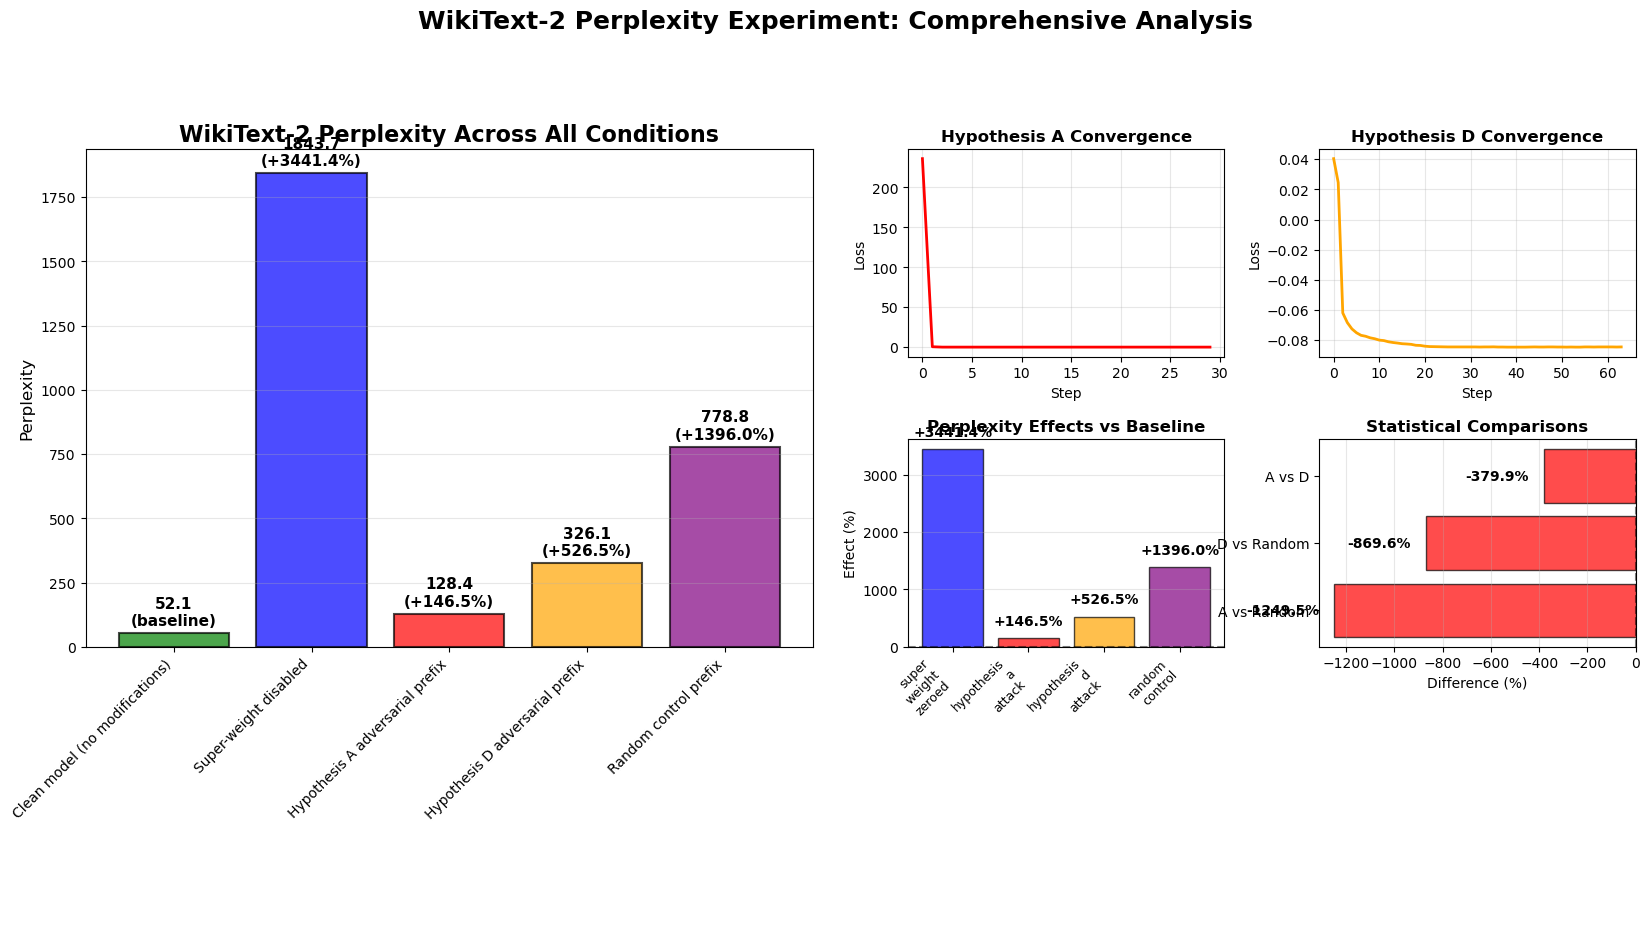

In [15]:
# Additional visualization for the clean experiment
def plot_clean_experiment_results(results: Dict[str, Any]):
    """Create visualization for the comprehensive perplexity experiment."""
    
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)
    
    ppl_results = results['perplexity_results']
    
    # 1. Main perplexity comparison (large plot)
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    
    conditions = list(ppl_results.keys())
    perplexities = [ppl_results[c]['perplexity'] for c in conditions]
    colors = ['green', 'blue', 'red', 'orange', 'purple']
    
    bars = ax1.bar(range(len(conditions)), perplexities, 
                   color=colors[:len(conditions)], alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add effect percentages as annotations
    baseline_ppl = ppl_results['baseline']['perplexity']
    for i, (bar, condition) in enumerate(zip(bars, conditions)):
        ppl = perplexities[i]
        if condition != 'baseline':
            effect = ((ppl - baseline_ppl) / baseline_ppl) * 100
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(perplexities) * 0.01,
                    f'{ppl:.1f}\n({effect:+.1f}%)', ha='center', va='bottom', 
                    fontweight='bold', fontsize=11)
        else:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(perplexities) * 0.01,
                    f'{ppl:.1f}\n(baseline)', ha='center', va='bottom', 
                    fontweight='bold', fontsize=11)
    
    ax1.set_title('WikiText-2 Perplexity Across All Conditions', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Perplexity', fontsize=12)
    ax1.set_xticks(range(len(conditions)))
    ax1.set_xticklabels([ppl_results[c]['description'] for c in conditions], 
                       rotation=45, ha='right', fontsize=10)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Attack convergence plots
    ax2 = fig.add_subplot(gs[0, 2])
    attack_results = results['attack_results']
    
    hyp_a_loss = attack_results['hypothesis_a']['loss_history']
    ax2.plot(hyp_a_loss, color='red', linewidth=2, label='Hypothesis A')
    ax2.set_title('Hypothesis A Convergence', fontweight='bold')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(gs[0, 3])
    hyp_d_loss = attack_results['hypothesis_d']['loss_history']
    ax3.plot(hyp_d_loss, color='orange', linewidth=2, label='Hypothesis D')
    ax3.set_title('Hypothesis D Convergence', fontweight='bold')
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Loss')
    ax3.grid(True, alpha=0.3)
    
    # 3. Effect size comparison
    ax4 = fig.add_subplot(gs[1, 2])
    
    effects = []
    effect_labels = []
    for condition in conditions:
        if condition != 'baseline':
            effect = ppl_results[condition].get('effect_percent', 0)
            effects.append(effect)
            effect_labels.append(condition.replace('_', '\n'))
    
    colors_effects = [c for i, c in enumerate(colors[1:]) if i < len(effects)]
    bars = ax4.bar(range(len(effects)), effects, color=colors_effects, alpha=0.7, edgecolor='black')
    
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('Perplexity Effects vs Baseline', fontweight='bold')
    ax4.set_ylabel('Effect (%)')
    ax4.set_xticks(range(len(effects)))
    ax4.set_xticklabels(effect_labels, rotation=45, ha='right', fontsize=9)
    ax4.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, effects):
        ax4.text(bar.get_x() + bar.get_width()/2, 
                val + (max(effects) * 0.05 if val >= 0 else min(effects) * 0.05),
                f'{val:+.1f}%', ha='center', va='bottom' if val >= 0 else 'top', 
                fontweight='bold', fontsize=10)
    
    # 4. Statistical comparison
    ax5 = fig.add_subplot(gs[1, 3])
    stats = results['statistical_analysis']
    
    comparisons = [
        ('A vs Random', stats['hypothesis_a_vs_random']),
        ('D vs Random', stats['hypothesis_d_vs_random']),
        ('A vs D', stats['hypothesis_a_vs_d']),
    ]
    
    comp_names, comp_values = zip(*comparisons)
    comp_colors = ['green' if v > 1 else 'red' if v < -1 else 'gray' for v in comp_values]
    
    bars = ax5.barh(range(len(comp_names)), comp_values, color=comp_colors, alpha=0.7, edgecolor='black')
    ax5.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax5.set_title('Statistical Comparisons', fontweight='bold')
    ax5.set_xlabel('Difference (%)')
    ax5.set_yticks(range(len(comp_names)))
    ax5.set_yticklabels(comp_names, fontsize=10)
    ax5.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, comp_values):
        label_x = val + (max(comp_values) * 0.05 if val >= 0 else min(comp_values) * 0.05)
        ax5.text(label_x, bar.get_y() + bar.get_height()/2, 
                f'{val:+.1f}%', ha='left' if val >= 0 else 'right', va='center', 
                fontweight='bold', fontsize=10)
    
    # 5. Attack strings comparison
    ax6 = fig.add_subplot(gs[2, :2])
    ax6.axis('off')
    
    strings_text = "OPTIMIZED ATTACK STRINGS\n" + "="*50 + "\n\n"
    strings_text += f"🔴 Hypothesis A (Activation Suppression):\n"
    strings_text += f"'{results['adversarial_strings']['hypothesis_a']}'\n\n"
    strings_text += f"🟠 Hypothesis D (Mean Head Reduction):\n"
    strings_text += f"'{results['adversarial_strings']['hypothesis_d']}'\n\n"
    strings_text += f"🟣 Random Control:\n"
    strings_text += f"'{results['adversarial_strings']['random_control']}'\n\n"

    plt.suptitle('WikiText-2 Perplexity Experiment: Comprehensive Analysis',
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Visualize the results
plot_clean_experiment_results(experiment_results)

In [80]:
print(multi_results_A['final_adv_string'])

(�b`"h@�73t


In [106]:
from heldout_eval import sample_wikitext_prompts_filtered, run_perplexity_bakeoff, ppl_for_prompts

In [109]:
heldout_prompts = sample_wikitext_prompts_filtered(
    tokenizer=session.tokenizer,
    num_prompts=100,
    seed=777,
    min_tokens=50,
    max_tokens=150
)

adv_string = multi_results_A['final_adv_string']
bake = run_perplexity_bakeoff(
    session=session,
    attacker=multi_attacker_A,
    target_sw=target_sw,
    adv_prefix=adv_string,
    prompts=heldout_prompts,
    seed=777,
    activation_metric='down_proj_in_col_at_sink',
)

# Quick print
for c, d in bake['conditions'].items():
    s = d['summary']['ppl']
    print(f"{c}: mean PPL={s['mean']:.2f} median={s['median']:.2f} p25={s['p25']:.2f} p75={s['p75']:.2f}")

print("\nComparisons:")
for k, v in bake['comparisons'].items():
    print(f"{k}: ΔmeanPPL={v['delta_mean_ppl']:.2f} ({v['delta_mean_ppl_pct']:+.2f}%) "
          f"p(t,PPL)={v['ppl_t_test']['p']:.3g} corr(Δact,Δppl)={v['activation_corr_delta_ppl']:.3f}")

[WARN] Only collected 88 prompts (wanted 100). Consider adjusting token limits or using a different dataset.
Dataset: wikitext (wikitext-2-raw-v1, validation)
Adversarial prefix: '(�b`"h@�73t'
Random prefix: ' 26 colony award 290 awkito text és� Hugo'
Evaluating 88 prompts across conditions...
Computing baseline perplexities...


[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:90], adv_start=0, sink_pos=0


Computing adversarial perplexities...


[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:79], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:71], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:133], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:105], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:125], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:69], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:75], adv_start=0, sink_pos=0
[INFO] super_weights.att

Computing random prefix perplexities...


[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:71], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:133], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:105], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:125], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:69], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:75], adv_start=0, sink_pos=0
[INFO] super_weights.attack: Tokenizer has BOS: False
[INFO] super_weights.attack: Content layout: content[10:64], adv_start=0, sink_pos=0
[INFO] super_weights.att

Computing zero super-weight perplexities...


2025-08-29 13:36:25,043 - SuperWeightManager_4487174400 - INFO - Restored 1/1 weights


2025-08-29 13:39:45,917 - SuperWeightManager_4487174400 - INFO - Successfully scaled 1/1 super weights by 0.000
2025-08-29 13:40:10,392 - SuperWeightManager_4487174400 - INFO - Restored 1/1 weights


baseline: mean PPL=18.60 median=15.98 p25=12.17 p75=22.94
adv: mean PPL=22.96 median=19.99 p25=14.65 p75=28.49
random: mean PPL=21.33 median=18.27 p25=13.91 p75=25.94
zeroSW: mean PPL=4416.36 median=3903.39 p25=2667.04 p75=5450.82

Comparisons:
adv_vs_baseline: ΔmeanPPL=4.35 (+23.41%) p(t,PPL)=2.96e-16 corr(Δact,Δppl)=0.093
random_vs_baseline: ΔmeanPPL=2.73 (+14.66%) p(t,PPL)=6.92e-17 corr(Δact,Δppl)=0.211
adv_vs_random: ΔmeanPPL=1.63 (+7.63%) p(t,PPL)=1.59e-05 corr(Δact,Δppl)=nan
zeroSW_vs_baseline: ΔmeanPPL=4397.76 (+23641.30%) p(t,PPL)=1.39e-30 corr(Δact,Δppl)=nan


In [111]:
from typing import Any

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1100190318.py:131: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(box_data, labels=box_labels, patch_artist=True,


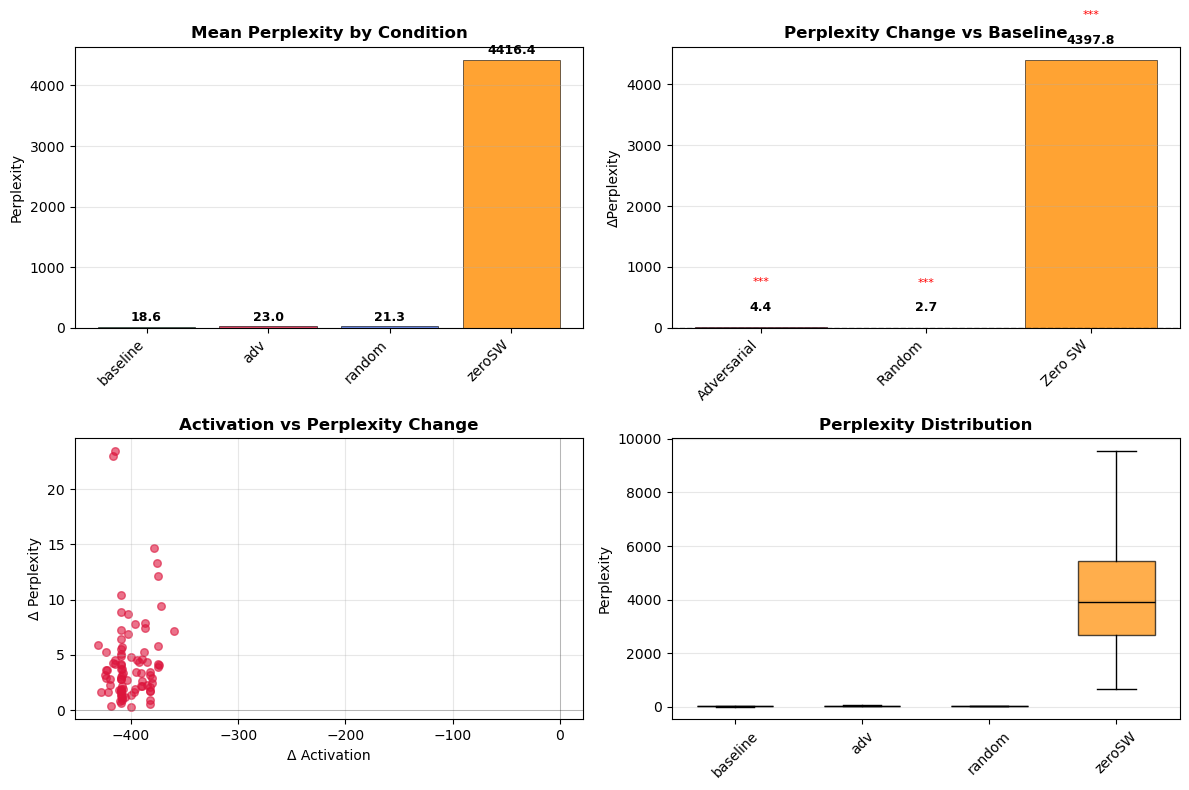


Key Statistics:
--------------------------------------------------
adv_vs_baseline: ΔPL=+4.35 (p=2.96e-16) ***
random_vs_baseline: ΔPL=+2.73 (p=6.92e-17) ***
adv_vs_random: ΔPL=+1.63 (p=1.59e-05) ***


In [112]:
def plot_perplexity_bakeoff(bake_results: Dict[str, Any], figsize=(12, 8)):
    """
    Minimalist visualization of perplexity bake-off results.
    
    Args:
        bake_results: Output from run_perplexity_bakeoff()
        figsize: Figure size tuple
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    conditions = bake_results['conditions']
    comparisons = bake_results['comparisons']
    
    # Color scheme
    colors = {
        'baseline': '#2E8B57',    # Sea green
        'adv': '#DC143C',         # Crimson  
        'random': '#4169E1',      # Royal blue
        'zeroSW': '#FF8C00'       # Dark orange
    }
    
    # 1. Mean Perplexity by Condition
    ax1 = axes[0, 0]
    condition_names = list(conditions.keys())
    mean_ppls = [conditions[name]['summary']['ppl']['mean'] for name in condition_names]
    
    bars = ax1.bar(range(len(condition_names)), mean_ppls, 
                   color=[colors[name] for name in condition_names], 
                   alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax1.set_title('Mean Perplexity by Condition', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Perplexity')
    ax1.set_xticks(range(len(condition_names)))
    ax1.set_xticklabels(condition_names, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars, mean_ppls):
        if not np.isnan(val):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mean_ppls) * 0.01,
                    f'{val:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 2. Perplexity Change vs Baseline
    ax2 = axes[0, 1]
    comparisons_to_plot = ['adv_vs_baseline', 'random_vs_baseline', 'zeroSW_vs_baseline']
    comp_labels = ['Adversarial', 'Random', 'Zero SW']
    comp_colors = ['#DC143C', '#4169E1', '#FF8C00']
    
    delta_ppls = [comparisons[comp]['delta_mean_ppl'] for comp in comparisons_to_plot]
    p_values = [comparisons[comp]['ppl_t_test']['p'] for comp in comparisons_to_plot]
    
    bars = ax2.bar(range(len(comp_labels)), delta_ppls, 
                   color=comp_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax2.set_title('Perplexity Change vs Baseline', fontsize=12, fontweight='bold')
    ax2.set_ylabel('ΔPerplexity')
    ax2.set_xticks(range(len(comp_labels)))
    ax2.set_xticklabels(comp_labels, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add significance indicators
    for i, (bar, val, p) in enumerate(zip(bars, delta_ppls, p_values)):
        if not np.isnan(val):
            ax2.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_height() + (max(delta_ppls) * 0.05 if val >= 0 else min(delta_ppls) * 0.05),
                    f'{val:.1f}', ha='center', va='bottom' if val >= 0 else 'top', 
                    fontsize=9, fontweight='bold')
            # Add significance stars
            if not np.isnan(p):
                stars = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
                if stars:
                    ax2.text(bar.get_x() + bar.get_width()/2,
                            bar.get_height() + (max(delta_ppls) * 0.15 if val >= 0 else min(delta_ppls) * 0.15),
                            stars, ha='center', va='bottom' if val >= 0 else 'top', 
                            fontsize=8, color='red')
    
    # 3. Activation Change vs Perplexity Change Correlation
    ax3 = axes[1, 0]
    
    # Use adversarial vs baseline comparison for correlation plot
    adv_baseline_comp = comparisons['adv_vs_baseline']
    
    if 'activation_corr_delta_ppl' in adv_baseline_comp and not np.isnan(adv_baseline_comp['activation_corr_delta_ppl']):
        # Get the raw data for scatter plot
        baseline_cond = conditions['baseline']
        adv_cond = conditions['adv']
        
        # Filter valid data
        valid_mask = ~(np.isnan(baseline_cond['ppl']) | np.isnan(adv_cond['ppl']) | 
                      np.isnan(baseline_cond['activation']) | np.isnan(adv_cond['activation']))
        
        if np.any(valid_mask):
            ppl_change = adv_cond['ppl'][valid_mask] - baseline_cond['ppl'][valid_mask]
            act_change = adv_cond['activation'][valid_mask] - baseline_cond['activation'][valid_mask]
            
            ax3.scatter(act_change, ppl_change, alpha=0.6, color='#DC143C', s=30)
            
            # Add correlation line if significant correlation
            corr = adv_baseline_comp['activation_corr_delta_ppl']
            if abs(corr) > 0.1:  # Only show line if correlation is meaningful
                z = np.polyfit(act_change, ppl_change, 1)
                p = np.poly1d(z)
                x_line = np.linspace(act_change.min(), act_change.max(), 100)
                ax3.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=1)
    
    ax3.set_title('Activation vs Perplexity Change', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Δ Activation')
    ax3.set_ylabel('Δ Perplexity')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    ax3.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    
    # 4. Distribution Comparison (Box plot)
    ax4 = axes[1, 1]
    
    # Prepare data for box plot
    box_data = []
    box_labels = []
    box_colors = []
    
    for name in ['baseline', 'adv', 'random', 'zeroSW']:
        if name in conditions:
            valid_ppl = conditions[name]['ppl'][~np.isnan(conditions[name]['ppl'])]
            if len(valid_ppl) > 0:
                box_data.append(valid_ppl)
                box_labels.append(name)
                box_colors.append(colors[name])
    
    if box_data:
        bp = ax4.boxplot(box_data, labels=box_labels, patch_artist=True, 
                        showfliers=False, widths=0.6)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Style other elements
        for element in ['whiskers', 'caps', 'medians']:
            for item in bp[element]:
                item.set_color('black')
                item.set_linewidth(1)
    
    ax4.set_title('Perplexity Distribution', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Perplexity')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print key statistics
    print("\nKey Statistics:")
    print("-" * 50)
    for comp_name, comp_data in comparisons.items():
        if comp_name in ['adv_vs_baseline', 'random_vs_baseline', 'adv_vs_random']:
            delta_ppl = comp_data['delta_mean_ppl']
            p_val = comp_data['ppl_t_test']['p']
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            print(f"{comp_name}: ΔPL={delta_ppl:+.2f} (p={p_val:.3g}) {significance}")

# Use it with your bake results
plot_perplexity_bakeoff(bake)

/var/folders/92/vn97p82j2sq0hx9c9xlrq70w0000gn/T/ipykernel_63013/1906456771.py:142: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(box_data, labels=box_labels, patch_artist=True,


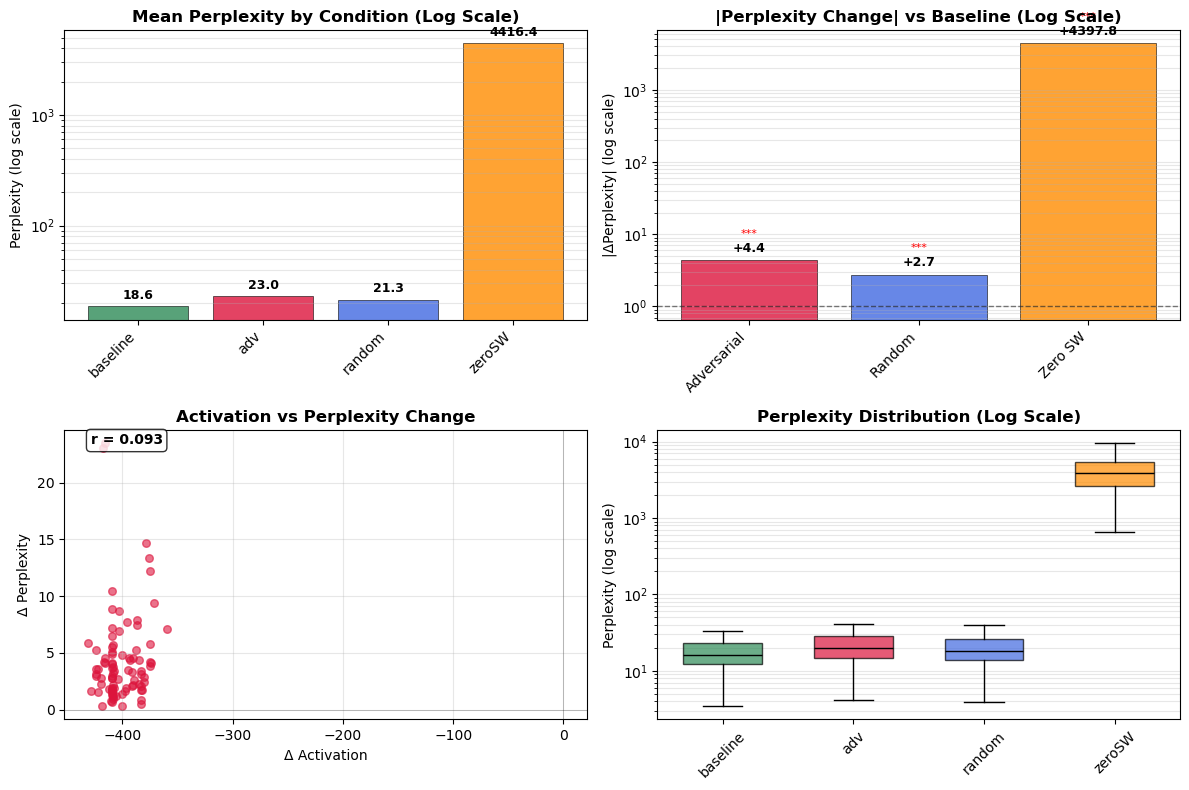


Key Statistics:
------------------------------------------------------------
adv_vs_baseline     : ΔPL=   +4.35 (p=2.96e-16) ***
random_vs_baseline  : ΔPL=   +2.73 (p=6.92e-17) ***
adv_vs_random       : ΔPL=   +1.63 (p=1.59e-05) ***


In [113]:
def plot_perplexity_bakeoff(bake_results: Dict[str, Any], figsize=(12, 8)):
    """
    Minimalist visualization of perplexity bake-off results with log scale for large differences.
    
    Args:
        bake_results: Output from run_perplexity_bakeoff()
        figsize: Figure size tuple
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    conditions = bake_results['conditions']
    comparisons = bake_results['comparisons']
    
    # Color scheme
    colors = {
        'baseline': '#2E8B57',    # Sea green
        'adv': '#DC143C',         # Crimson  
        'random': '#4169E1',      # Royal blue
        'zeroSW': '#FF8C00'       # Dark orange
    }
    
    # 1. Mean Perplexity by Condition (LOG SCALE)
    ax1 = axes[0, 0]
    condition_names = list(conditions.keys())
    mean_ppls = [conditions[name]['summary']['ppl']['mean'] for name in condition_names]
    
    bars = ax1.bar(range(len(condition_names)), mean_ppls, 
                   color=[colors[name] for name in condition_names], 
                   alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax1.set_yscale('log')  # LOG SCALE
    ax1.set_title('Mean Perplexity by Condition (Log Scale)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Perplexity (log scale)')
    ax1.set_xticks(range(len(condition_names)))
    ax1.set_xticklabels(condition_names, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3, which='both')
    
    # Add value labels on bars
    for bar, val in zip(bars, mean_ppls):
        if not np.isnan(val):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
                    f'{val:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 2. Perplexity Change vs Baseline (SYMLOG SCALE for negative values)
    ax2 = axes[0, 1]
    comparisons_to_plot = ['adv_vs_baseline', 'random_vs_baseline', 'zeroSW_vs_baseline']
    comp_labels = ['Adversarial', 'Random', 'Zero SW']
    comp_colors = ['#DC143C', '#4169E1', '#FF8C00']
    
    delta_ppls = [comparisons[comp]['delta_mean_ppl'] for comp in comparisons_to_plot]
    p_values = [comparisons[comp]['ppl_t_test']['p'] for comp in comparisons_to_plot]
    
    # Use absolute values for bar heights, track signs separately
    abs_delta_ppls = [abs(d) for d in delta_ppls]
    bar_colors = [comp_colors[i] if delta_ppls[i] >= 0 else 'lightgray' for i in range(len(delta_ppls))]
    
    bars = ax2.bar(range(len(comp_labels)), abs_delta_ppls, 
                   color=bar_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax2.set_yscale('log')  # LOG SCALE for absolute values
    ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, linewidth=1)  # Reference line at |1|
    ax2.set_title('|Perplexity Change| vs Baseline (Log Scale)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('|ΔPerplexity| (log scale)')
    ax2.set_xticks(range(len(comp_labels)))
    ax2.set_xticklabels(comp_labels, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3, which='both')
    
    # Add significance indicators and values
    for i, (bar, val, abs_val, p) in enumerate(zip(bars, delta_ppls, abs_delta_ppls, p_values)):
        if not np.isnan(val):
            # Show actual signed value
            sign = '+' if val >= 0 else ''
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.2,
                    f'{sign}{val:.1f}', ha='center', va='bottom', 
                    fontsize=9, fontweight='bold')
            # Add significance stars
            if not np.isnan(p):
                stars = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
                if stars:
                    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 2.0,
                            stars, ha='center', va='bottom', 
                            fontsize=8, color='red')
    
    # 3. Activation Change vs Perplexity Change Correlation
    ax3 = axes[1, 0]
    
    # Use adversarial vs baseline comparison for correlation plot
    adv_baseline_comp = comparisons['adv_vs_baseline']
    
    if 'activation_corr_delta_ppl' in adv_baseline_comp and not np.isnan(adv_baseline_comp['activation_corr_delta_ppl']):
        # Get the raw data for scatter plot
        baseline_cond = conditions['baseline']
        adv_cond = conditions['adv']
        
        # Filter valid data
        valid_mask = ~(np.isnan(baseline_cond['ppl']) | np.isnan(adv_cond['ppl']) | 
                      np.isnan(baseline_cond['activation']) | np.isnan(adv_cond['activation']))
        
        if np.any(valid_mask):
            ppl_change = adv_cond['ppl'][valid_mask] - baseline_cond['ppl'][valid_mask]
            act_change = adv_cond['activation'][valid_mask] - baseline_cond['activation'][valid_mask]
            
            ax3.scatter(act_change, ppl_change, alpha=0.6, color='#DC143C', s=30)
            
            # Add correlation line if significant correlation
            corr = adv_baseline_comp['activation_corr_delta_ppl']
            if abs(corr) > 0.1:  # Only show line if correlation is meaningful
                z = np.polyfit(act_change, ppl_change, 1)
                p = np.poly1d(z)
                x_line = np.linspace(act_change.min(), act_change.max(), 100)
                ax3.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=1)
            
            # Add correlation coefficient text
            ax3.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax3.transAxes, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    fontsize=10, fontweight='bold')
    
    ax3.set_title('Activation vs Perplexity Change', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Δ Activation')
    ax3.set_ylabel('Δ Perplexity')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    ax3.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    
    # 4. Distribution Comparison (Box plot with LOG SCALE)
    ax4 = axes[1, 1]
    
    # Prepare data for box plot
    box_data = []
    box_labels = []
    box_colors = []
    
    for name in ['baseline', 'adv', 'random', 'zeroSW']:
        if name in conditions:
            valid_ppl = conditions[name]['ppl'][~np.isnan(conditions[name]['ppl'])]
            if len(valid_ppl) > 0:
                box_data.append(valid_ppl)
                box_labels.append(name)
                box_colors.append(colors[name])
    
    if box_data:
        bp = ax4.boxplot(box_data, labels=box_labels, patch_artist=True, 
                        showfliers=False, widths=0.6)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Style other elements
        for element in ['whiskers', 'caps', 'medians']:
            for item in bp[element]:
                item.set_color('black')
                item.set_linewidth(1)
    
    ax4.set_yscale('log')  # LOG SCALE
    ax4.set_title('Perplexity Distribution (Log Scale)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Perplexity (log scale)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(axis='y', alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()
    
    # Print key statistics with better formatting for large ranges
    print("\nKey Statistics:")
    print("-" * 60)
    for comp_name, comp_data in comparisons.items():
        if comp_name in ['adv_vs_baseline', 'random_vs_baseline', 'adv_vs_random']:
            delta_ppl = comp_data['delta_mean_ppl']
            p_val = comp_data['ppl_t_test']['p']
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            
            # Format large numbers more readably
            if abs(delta_ppl) >= 100:
                delta_str = f"{delta_ppl:+,.0f}"
            else:
                delta_str = f"{delta_ppl:+.2f}"
                
            print(f"{comp_name:20s}: ΔPL={delta_str:>8s} (p={p_val:.3g}) {significance}")

# Use it with your bake results
plot_perplexity_bakeoff(bake)

In [90]:
# run super weight detection again, with the adv string
prompt_text = adv_string + "Apple Inc. is a worldwide tech company"
sw_attacked = session.detect_super_weights(spike_threshold=70.0, input_text=prompt_text)
sw_attacked

2025-08-29 03:07:06,778 - SuperWeightResearch_13286225184 - INFO - Starting super weight detection
2025-08-29 03:07:06,779 - SuperWeightDetector_13392054160 - INFO - Starting super weight detection
2025-08-29 03:07:06,779 - SuperWeightDetector_13392054160 - INFO - Parameters: threshold=70.0, max_iterations=10
2025-08-29 03:07:06,785 - SuperWeightDetector_13392054160 - INFO - === Iteration 1 ===
2025-08-29 03:07:08,210 - SuperWeightDetector_13392054160 - INFO - Found 2 potential super weights in iteration 1
2025-08-29 03:07:08,210 - SuperWeightDetector_13392054160 - INFO - Found 2 new super weights:
2025-08-29 03:07:08,211 - SuperWeightDetector_13392054160 - INFO -   1. Layer 3 mlp.down_proj.weight[1764, 1902] - Input: -109.25, Output: -107.19
2025-08-29 03:07:08,211 - SuperWeightDetector_13392054160 - INFO -   2. Layer 15 mlp.down_proj.weight[1764, 6840] - Input: -195.00, Output: 212.75
2025-08-29 03:07:08,211 - SuperWeightDetector_13392054160 - INFO - === Iteration 2 ===
2025-08-29 03

[SuperWeight(layer=3, coords=[1764, 1902], input=-109.25, output=-107.19),
 SuperWeight(layer=15, coords=[1764, 6840], input=-195.00, output=212.75)]

In [103]:
# original super weights from beginning of notebook
sw

[SuperWeight(layer=1, coords=[1764, 1710], input=-401.50, output=-262.00),
 SuperWeight(layer=15, coords=[1764, 6840], input=-283.00, output=415.00)]